In [1]:
import os
import glob
import pysam
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

## Load data

In [5]:
joanito_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding = "ISO-8859-1")
joanito_metadata = joanito_metadata[joanito_metadata['dataset'].isin(['CRC-SG1', 'KUL5', 'KUL3'])].copy()
joanito_metadata = joanito_metadata[joanito_metadata['MSS_MSI']=='MSI-H'].copy()
joanito_metadata

dataset patient.ID Gender  Age at recruitment MSS_MSI              Site  \
12  CRC-SG1    CRC2783      F                31.0   MSI-H  Transverse colon   
22  CRC-SG1    CRC2817      M                67.0   MSI-H            Caecum   
26     KUL3      SC001      F                81.0   MSI-H            Caecum   
35     KUL5      SC035      M                44.0   MSI-H   Ascending colon   
39     KUL5      SC044      F                80.0   MSI-H            Caecum   

   Sidedness Group Stage        Stage TNM iCMS.transcriptomic iCMS.inferCNV  \
12         R           3   T3N1b(2/62)M0                iCMS3         iCMS3   
22         R           3  T4bN1b(3/71)M0                iCMS3         iCMS3   
26         R         IIB           pT4aN0               iCMS3         iCMS3   
35         R          II           T3N0M0               iCMS3         iCMS3   
39         R         III           T3N1M0               iCMS3         iCMS3   

   KRAS BRAF TP53  APC PIK3CA  LymphNode  Normal  Tumor   CMS  
12  mut   wt  mut  mut    mut          1       1      4  CMS1  
22  mut   wt   wt   wt    mut          2       1      8  CMS1  
26   wt  mut   wt  mut    NaN          0       1      2   NaN  
35   wt   wt   wt  mut    NaN          1       1      2  CMS1  
39   wt   wt   wt   wt    NaN          0       2      3  CMS1

In [3]:
PATH_SG1_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/EGAD00001008555-metadata/organized_metadata.tsv"
PATH_KUL_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/organized_metadata.tsv"

SG1_metadata = pd.read_csv(PATH_SG1_metadata, sep='\t')
KUL_metadata = pd.read_csv(PATH_KUL_metadata, sep='\t')

In [6]:
# adata_epi = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

## Re-cluster SC035 cells

In [7]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [8]:
adata_SC035 = adata[adata.obs['PatientID']=='SC035'].copy()
adata_SC035 = adata_SC035.raw.to_adata()
adata_SC035.raw = adata_SC035.copy()

sc.pp.normalize_total(adata_SC035)
sc.pp.log1p(adata_SC035)
sc.pp.highly_variable_genes(adata_SC035, n_top_genes=2000, batch_key="SampleID")

adata_SC035 = adata_SC035[:, adata_SC035.var.highly_variable]

sc.pp.scale(adata_SC035, max_value=10)
sc.tl.pca(adata_SC035, svd_solver="arpack")

sc.pp.neighbors(adata_SC035, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata_SC035, random_state=0)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-03-09 21:14:03.506305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 21:14:03.507744: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 21:14:03.588005: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 21:14:03.603850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 

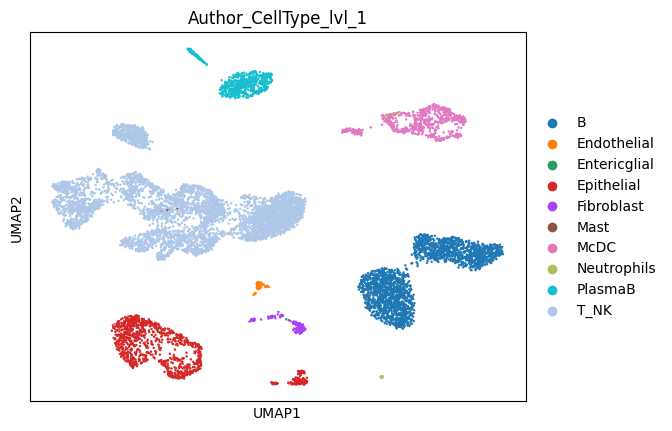

In [82]:
sc.pl.umap(adata_SC035, color=['Author_CellType_lvl_1'])

In [51]:
adata_SC035.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.SC035.h5ad')

In [9]:
# adata_epi_tumor_SC035 = adata_epi[(adata_epi.obs['PatientID']=='SC035') & (adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_tumor_SC035 = adata_SC035[(adata_SC035.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_tumor_SC035 = adata_epi_tumor_SC035.raw.to_adata()

sc.pp.normalize_total(adata_epi_tumor_SC035)
sc.pp.log1p(adata_epi_tumor_SC035)
sc.pp.highly_variable_genes(adata_epi_tumor_SC035, n_top_genes=2000, batch_key="SampleID")

adata_epi_tumor_SC035.raw = adata_epi_tumor_SC035.copy()
adata_epi_tumor_SC035 = adata_epi_tumor_SC035[:, adata_epi_tumor_SC035.var.highly_variable]

sc.pp.scale(adata_epi_tumor_SC035, max_value=10)
sc.tl.pca(adata_epi_tumor_SC035, svd_solver="arpack")

sc.pp.neighbors(adata_epi_tumor_SC035, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_tumor_SC035, random_state=0)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.tl.leiden(adata_epi_tumor_SC035, key_added='SC035_subLeiden', resolution=.1,)

/tmp/ipykernel_192035/2096942889.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_epi_tumor_SC035, key_added='SC035_subLeiden', resolution=.1,)


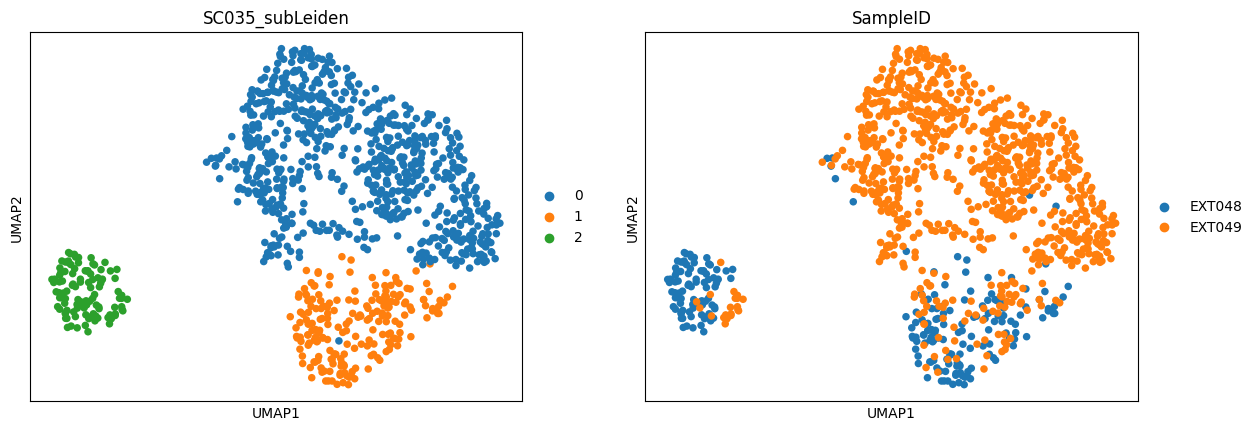

In [88]:
sc.pl.umap(adata_epi_tumor_SC035, color=['SC035_subLeiden', 'SampleID'])

### Check if MSI score difference among tumor-subclusters are significant

<Axes: xlabel='Manual_CellType_lvl_1', ylabel='MSI_score'>

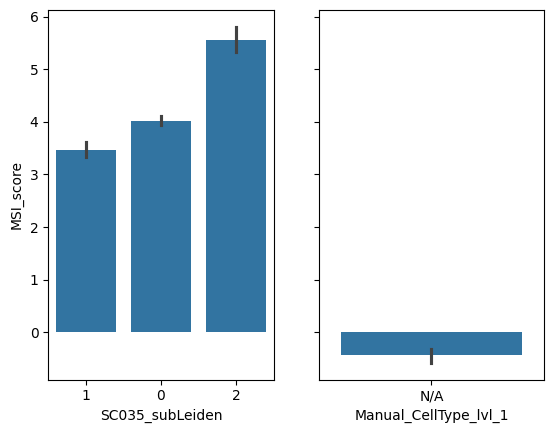

In [101]:
fig, axes = plt.subplots(1, 2, sharey=True)
sns.barplot(data=adata_epi_tumor_SC035.obs, x='SC035_subLeiden', y='MSI_score', order=['1', '0', '2'],ax=axes[0])
sns.barplot(data=adata_SC035.obs[adata_SC035.obs['Manual_CellType_lvl_1']=='N/A'], 
               x='Manual_CellType_lvl_1', y='MSI_score', order=['N/A'], ax=axes[1])

In [105]:
pval_tumor_0_1 = stats.mannwhitneyu(adata_epi_tumor_SC035.obs[(adata_epi_tumor_SC035.obs['SC035_subLeiden']=='0')]['MSI_score'], 
                                    adata_epi_tumor_SC035.obs[(adata_epi_tumor_SC035.obs['SC035_subLeiden']=='1')]['MSI_score'])[1]
pval_tumor_0_2 = stats.mannwhitneyu(adata_epi_tumor_SC035.obs[(adata_epi_tumor_SC035.obs['SC035_subLeiden']=='0')]['MSI_score'], 
                                    adata_epi_tumor_SC035.obs[(adata_epi_tumor_SC035.obs['SC035_subLeiden']=='2')]['MSI_score'])[1]
pval_tumor_1_2 = stats.mannwhitneyu(adata_epi_tumor_SC035.obs[(adata_epi_tumor_SC035.obs['SC035_subLeiden']=='1')]['MSI_score'], 
                                    adata_epi_tumor_SC035.obs[(adata_epi_tumor_SC035.obs['SC035_subLeiden']=='2')]['MSI_score'])[1]
print(pval_tumor_0_1, pval_tumor_0_2, pval_tumor_1_2)

5.1806648601698565e-09 2.3694173428915283e-26 1.674600534409174e-30


### Create new column to label cell types for SComatic

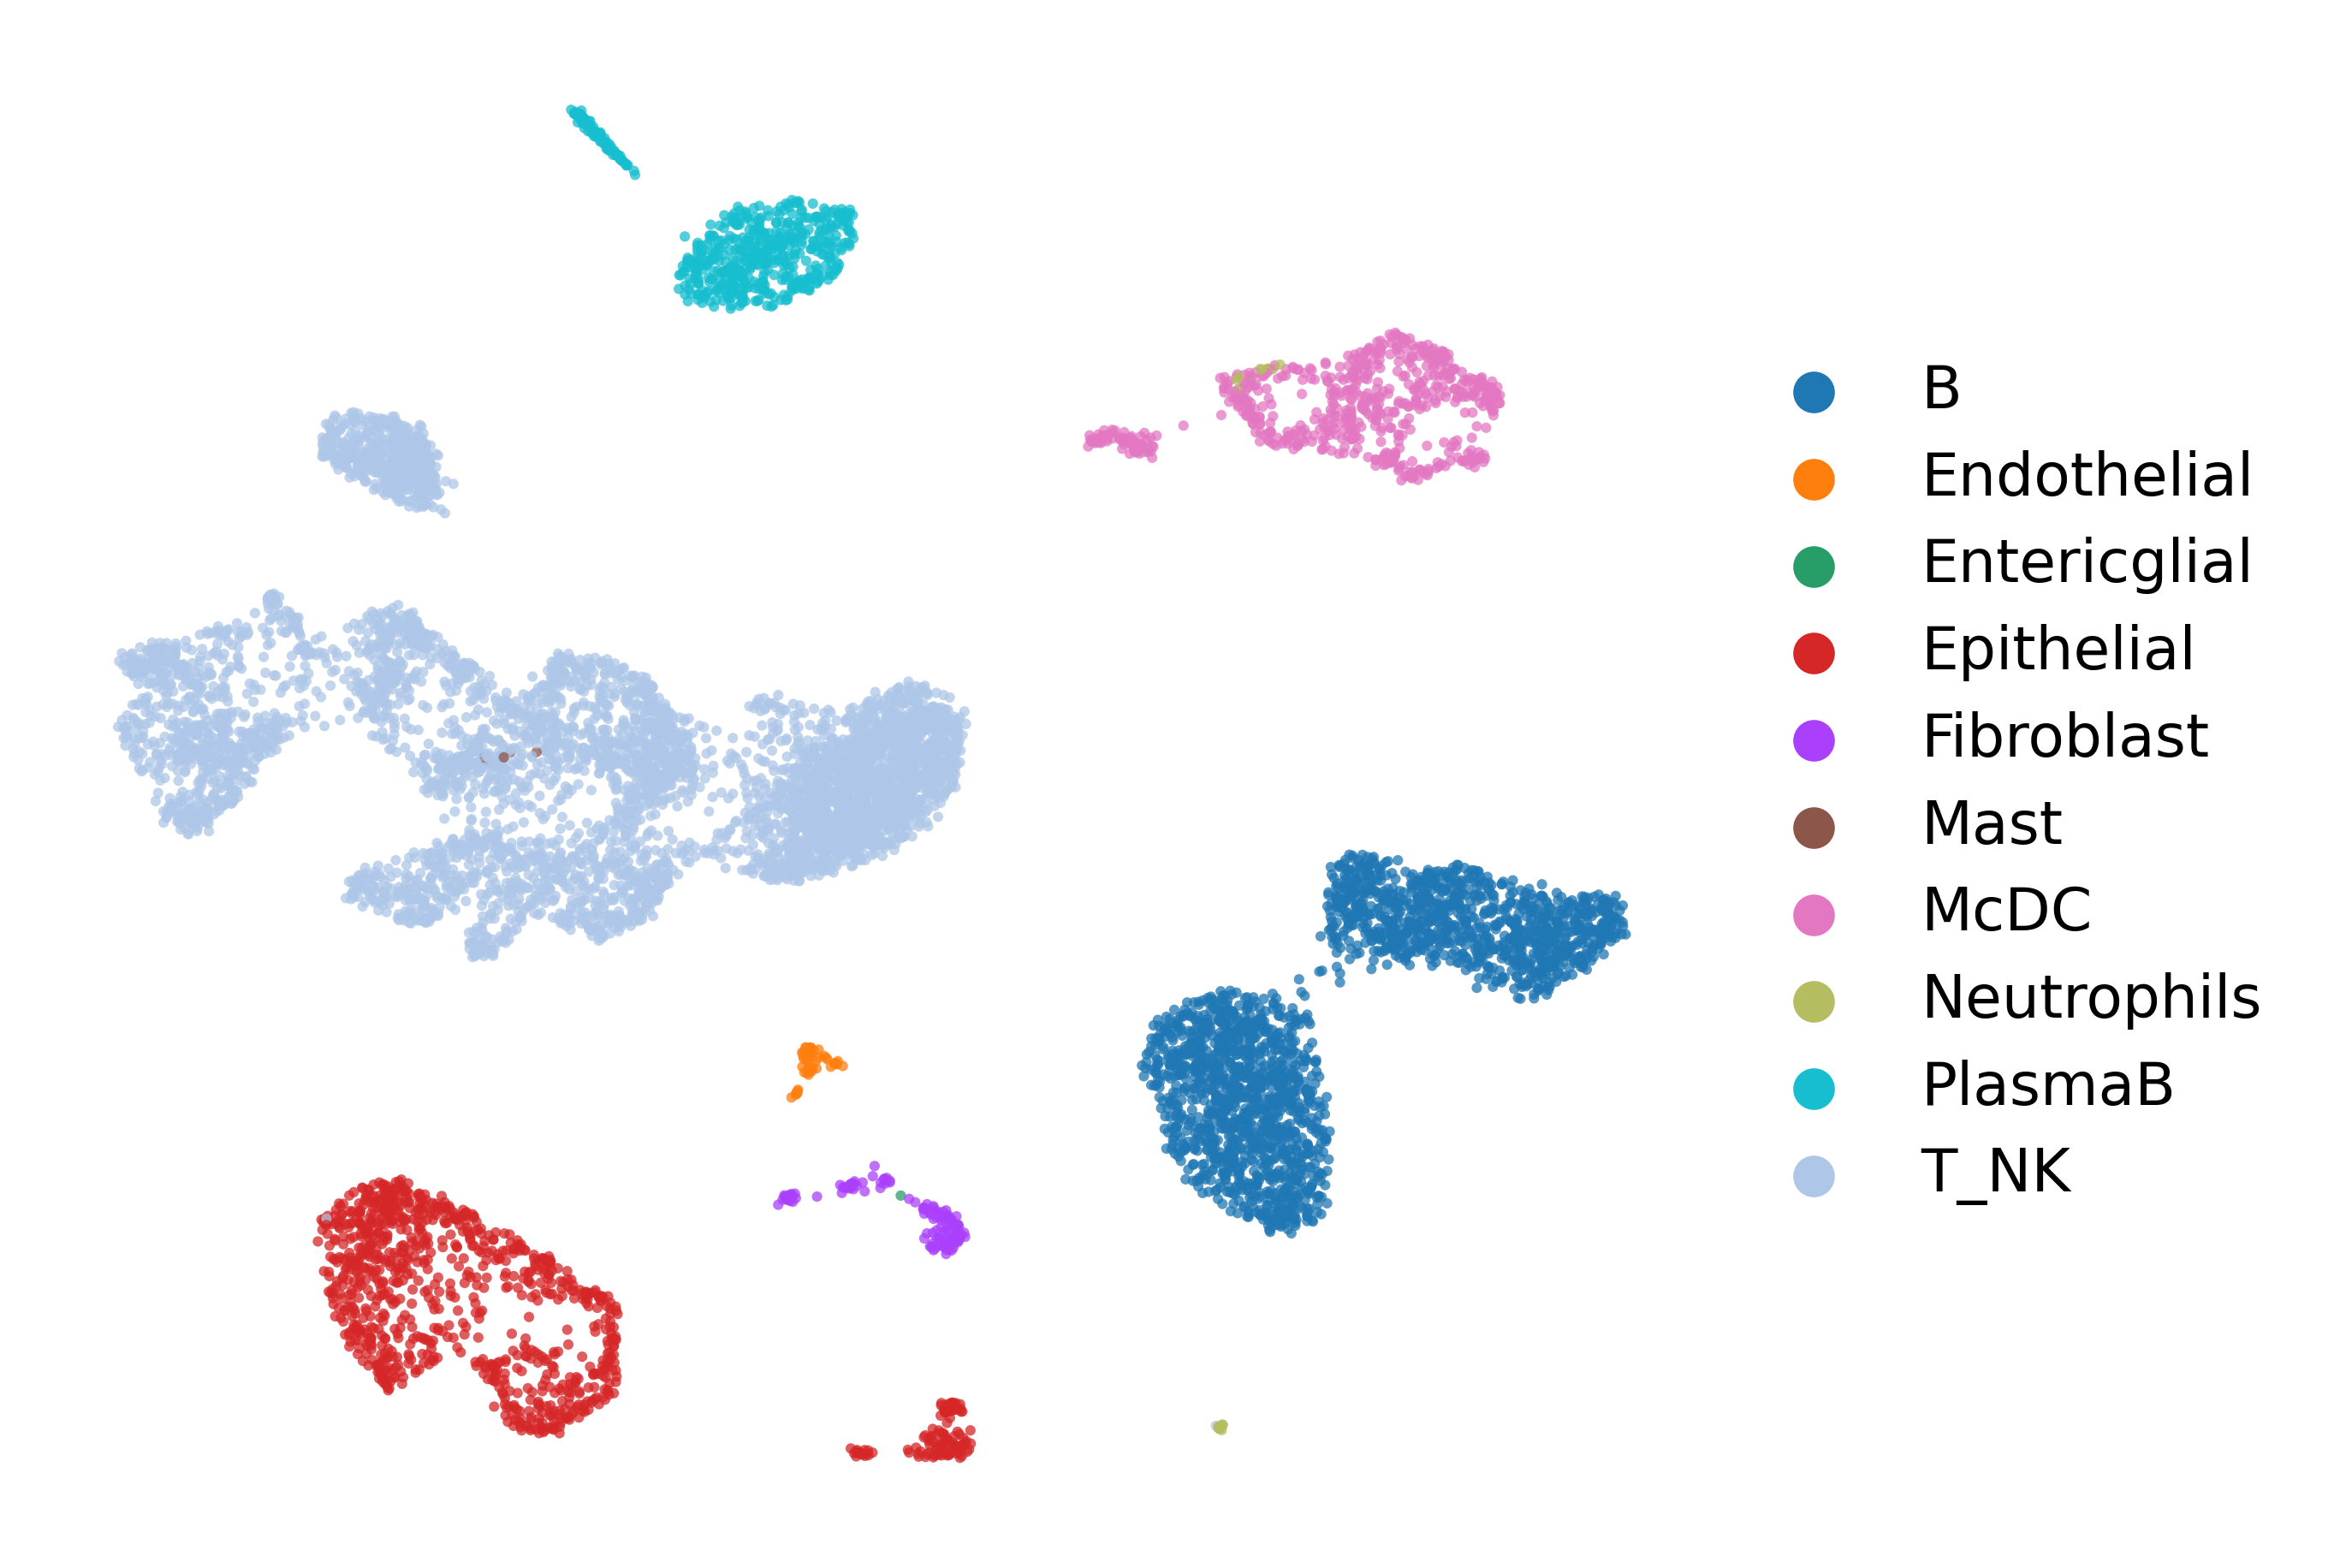

In [45]:
dict_Identifier_to_SComaticCT =  dict()

for tup in adata_epi_tumor_SC035.obs.itertuples(): dict_Identifier_to_SComaticCT[tup.Identifier] = f'Tumor_{tup.SC035_subLeiden}'
for tup in adata_SC035.obs.itertuples():
    try:
        dict_Identifier_to_SComaticCT[tup.Identifier]
    except KeyError:
        dict_Identifier_to_SComaticCT[tup.Identifier] = 'Normal'
        
        
adata_SC035.obs['SComatic_CellType'] = [ dict_Identifier_to_SComaticCT[Identifier] for Identifier in adata_SC035.obs['Identifier'] ]
adata_epi_tumor_SC035.obs['SComatic_CellType'] = [ dict_Identifier_to_SComaticCT[Identifier] for Identifier in adata_epi_tumor_SC035.obs['Identifier'] ]


palette_e = {'Normal' : 'gray', 
                        'Tumor_0' : 'lightseagreen', 
                        'Tumor_1' : 'steelblue', 
                        'Tumor_2' : 'darksalmon',
                        }

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 4.5)},):
       sc.pl.umap(adata_SC035, 
              color=['Author_CellType_lvl_1',],  #  SComatic_CellType2, 'SNP_allele', 'MSI_score'
              # s=25,
              cmap=sns.diverging_palette(220, 20, as_cmap=True),
              # palette=palette_e,
              # legend_loc=None,
              colorbar_loc=None,
              alpha=0.75,
              title='',
              frameon=False,
              )

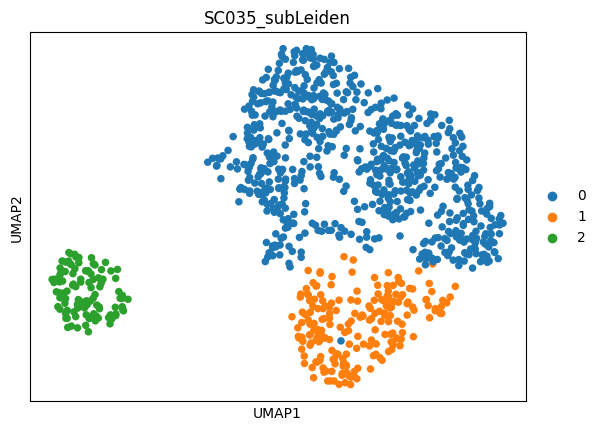

In [529]:
plt.rcParams["figure.dpi"] = 100
sc.pl.umap(adata_epi_tumor_SC035, color=['SC035_subLeiden'])

In [780]:
sc.tl.rank_genes_groups(adata_epi_tumor_SC035, groupby='SC035_subLeiden', method='wilcoxon')

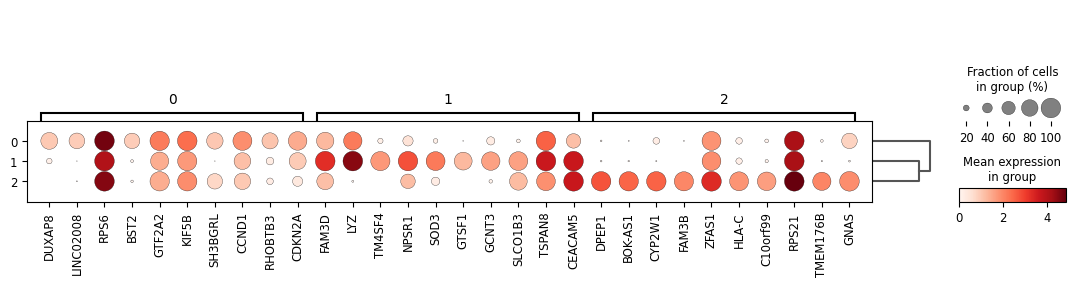

In [782]:
sc.pl.rank_genes_groups_dotplot(adata_epi_tumor_SC035,)

In [48]:
adata_epi_tumor_SC035

AnnData object with n_obs × n_vars = 1019 × 2000
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI_score', 'MSI', 'Manual_CellType_lvl_1', 'SC035_subLeiden', 'SComatic_CellType', 'SComatic_CellType2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Author_CellType_lvl_1_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'SC035_subLeiden', 'SComatic_CellType2_colors', 'SComatic_CellType_colors'
    obsm: 'X_pca',

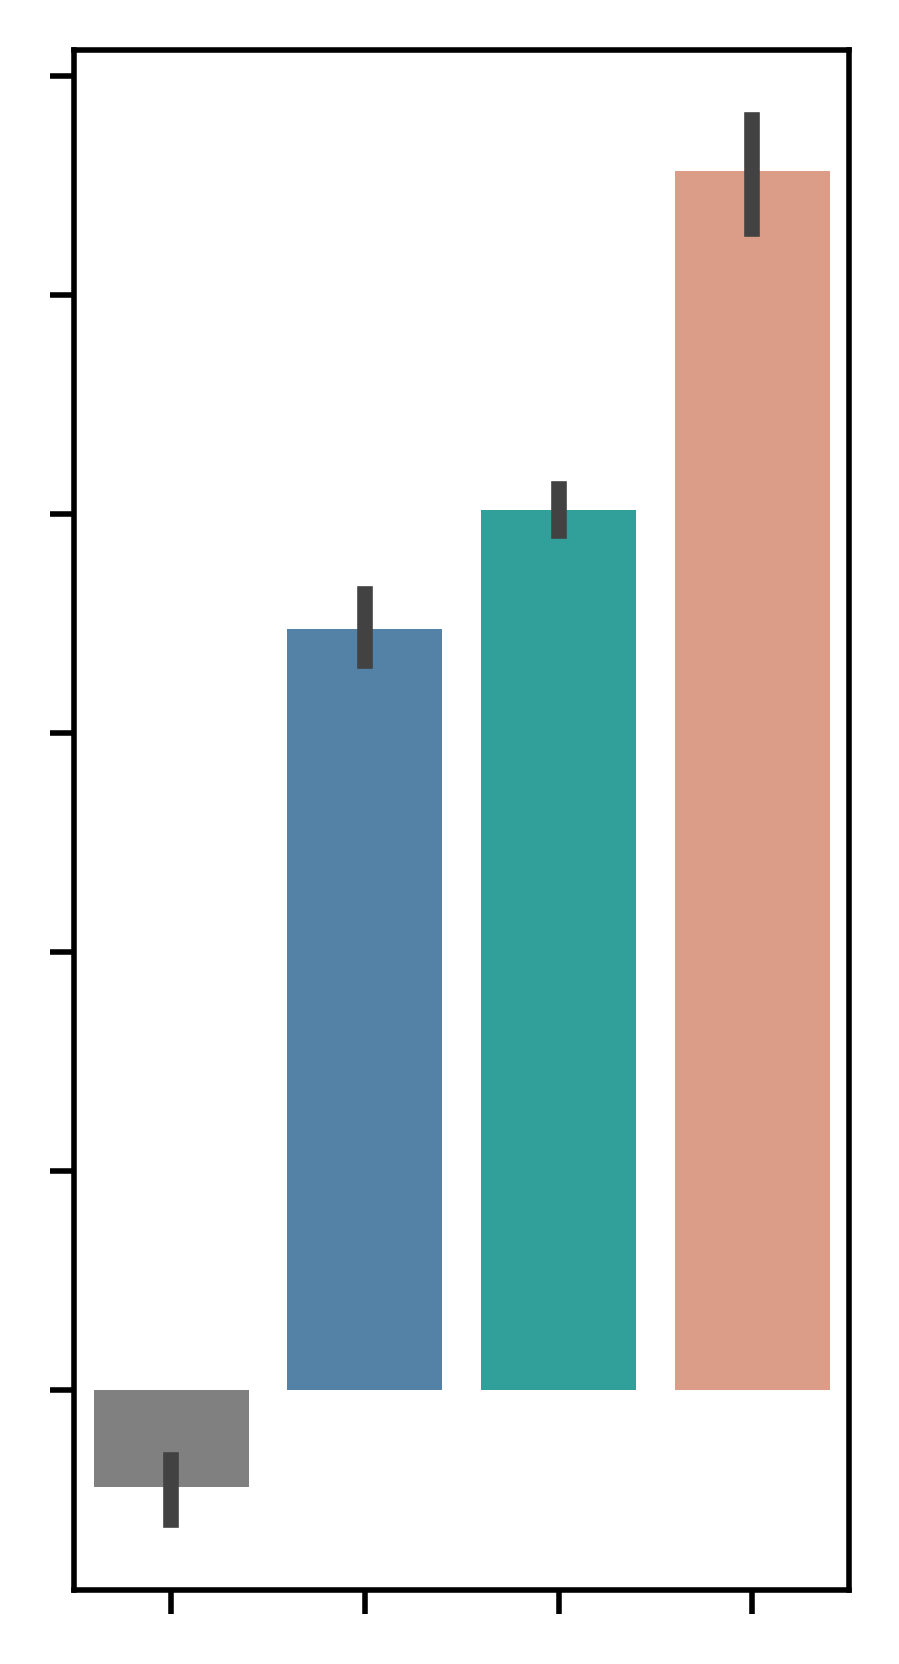

In [33]:
plt.figure(figsize=(2, 4), dpi=500)
ax = sns.barplot(data=adata_SC035.obs, x='SComatic_CellType', y='MSI_score', 
                 hue='SComatic_CellType',
                 palette={'Normal' : 'gray', 
                     #    'Tumor_0' : sns.color_palette('Paired')[1], 
                     #    'Tumor_1' : sns.color_palette('Paired')[7], 
                     #    'Tumor_2' : sns.color_palette('Paired')[3]
                        'Tumor_0' : 'lightseagreen', 
                        'Tumor_1' : 'steelblue', 
                        'Tumor_2' : 'darksalmon',
                        },
                 order=['Normal', 'Tumor_1', 'Tumor_0', 'Tumor_2']
                 )
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_xlabel('');
ax.set_ylabel('');
plt.show()

In [742]:
PATH_EXT048_BAM

'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT048/outs/possorted_genome_bam.bam'

## Run SComatic to validate intratumoral heterogeneity

In [23]:
import subprocess
DIR_save = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification'
DIR_SComatic_scripts = '/home/18parkky/git/SComatic/scripts'

### Step 0. Prepare working directories for each sample

In [696]:
DIR_BAM = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger'
PATH_EXT048_BAM = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT048/outs/possorted_genome_bam.bam'
PATH_EXT049_BAM = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT049/outs/possorted_genome_bam.bam'
PATH_EXT050_BAM = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT050/outs/possorted_genome_bam.bam'
PATH_EXT051_BAM = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT051/outs/possorted_genome_bam.bam'

# PATH_merged_BAM = f'{DIR_save}/SC035.bam'
# cmd = f'samtools merge {PATH_merged_BAM} {PATH_EXT048_BAM} {PATH_EXT049_BAM} {PATH_EXT050_BAM} {PATH_EXT051_BAM} -@ 16'
# subprocess.call(cmd, shell=True)
# subprocess.call(f'samtools index {PATH_merged_BAM} -@ 16', shell=True)

In [108]:
for SampleID in set(adata_SC035.obs['SampleID']):
    if os.path.exists(f'{DIR_save}/{SampleID}')==False:
        os.mkdir(f'{DIR_save}/{SampleID}')

In [ ]:

""" 
#! conda activate SComatic
#! create bash script that runs the SComatic commands
#! then run the bash script through terminal 
"""

### Step 1. SplitBamCellTypes.py

In [112]:
PATH_SplitBamCellTypes_script = f'{DIR_SComatic_scripts}/SplitBam/SplitBamCellTypes.py'

# Create metadata
with open(f'{DIR_save}/SplitBamCellTypes.sh', 'w') as f:
    for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
        DIR_save_sample = f'{DIR_save}/{SampleID}'
        DIR_out_sample = f'{DIR_save}/{SampleID}/SplitBamOut'
        
        if os.path.exists(DIR_out_sample)==False:
            os.mkdir(DIR_out_sample)
            
        PATH_metadata = f'{DIR_save_sample}/metadata.{SampleID}.tsv'
        metadata = pd.DataFrame([ ['-'.join(tup.Index.split('-')[:2]), tup.SComatic_CellType] for tup in edf.itertuples() ], columns=['Index', 'Cell_type'])
        metadata.to_csv(PATH_metadata, sep='\t', index=False)
        
        cmd = f'python {PATH_SplitBamCellTypes_script} --bam {DIR_BAM}/{SampleID}/outs/possorted_genome_bam.bam --meta {PATH_metadata} --outdir {DIR_out_sample}'
        print(f'{cmd}\t')
        f.write(f'{cmd}\n')

python /home/18parkky/git/SComatic/scripts/SplitBam/SplitBamCellTypes.py --bam /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT048/outs/possorted_genome_bam.bam --meta /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/metadata.EXT048.tsv --outdir /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/SplitBamOut	
python /home/18parkky/git/SComatic/scripts/SplitBam/SplitBamCellTypes.py --bam /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger/EXT049/outs/possorted_genome_bam.bam --meta /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/metadata.EXT049.tsv --outdir /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/SplitBamOut	
python /home/18parkky/git/SComatic/scripts/SplitBam/

### Step 2. BaseCellCounter.py

In [113]:
PATH_BaseCellCounter_script = f'{DIR_SComatic_scripts}/BaseCellCounter/BaseCellCounter.py'
PATH_reference_genome = '/node200data/18parkky/datasets/reference/genome/hg38.fa'

with open('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/BaseCellCounter.sh', 'w') as f:
    for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
        DIR_SplittedBam = f'{DIR_save}/{SampleID}/SplitBamOut'
        DIR_out_sample  = f'{DIR_save}/{SampleID}/BaseCellCounterOut'
        if os.path.exists(DIR_out_sample)==False:
            os.mkdir(DIR_out_sample)
        
        print(SampleID)
        for idx, PATH_SplittedBam in enumerate(glob.glob(f'{DIR_SplittedBam}/*.bam')):
            DIR_temp_out = f'{DIR_save}/{SampleID}/temp_{idx}'
            cmd = f'python {PATH_BaseCellCounter_script} --bam {PATH_SplittedBam} --ref {PATH_reference_genome} --chrom all --out_folder {DIR_out_sample} --nprocs 16 --tmp_dir {DIR_temp_out}'
            print(f'\t{cmd}')
            f.write(f'{cmd}\n')

EXT048
	python /home/18parkky/git/SComatic/scripts/BaseCellCounter/BaseCellCounter.py --bam /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/SplitBamOut/Sample.Normal.bam --ref /node200data/18parkky/datasets/reference/genome/hg38.fa --chrom all --out_folder /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/BaseCellCounterOut --nprocs 16 --tmp_dir /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/temp_0
	python /home/18parkky/git/SComatic/scripts/BaseCellCounter/BaseCellCounter.py --bam /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/SplitBamOut/Sample.Tumor_2.bam --ref /node200data/18parkky/datasets/reference/genome/hg38.fa --chrom all --out_folder /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/

### Step 3. MergeBaseCellCounts.py

In [114]:
PATH_MergeBaseCellCounts_script = f'{DIR_SComatic_scripts}/MergeCounts/MergeBaseCellCounts.py'
with open('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/MergeBaseCellCounts.sh', 'w') as f:
    for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
        print(SampleID)
        DIR_BaseCellCounts          = f'{DIR_save}/{SampleID}/BaseCellCounterOut'
        PATH_MergeBaseCellCounts    = f'{DIR_save}/{SampleID}/MergedBaseCellCounts.AllCellTypes.tsv'
        
        cmd = f'python {PATH_MergeBaseCellCounts_script} --tsv_folder {DIR_BaseCellCounts} --outfile {PATH_MergeBaseCellCounts}'
        print(f'\t{cmd}')
        f.write(f'{cmd}\n')


EXT048
	python /home/18parkky/git/SComatic/scripts/MergeCounts/MergeBaseCellCounts.py --tsv_folder /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/BaseCellCounterOut --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/MergedBaseCellCounts.AllCellTypes.tsv
EXT049
	python /home/18parkky/git/SComatic/scripts/MergeCounts/MergeBaseCellCounts.py --tsv_folder /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/BaseCellCounterOut --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/MergedBaseCellCounts.AllCellTypes.tsv
EXT050
	python /home/18parkky/git/SComatic/scripts/MergeCounts/MergeBaseCellCounts.py --tsv_folder /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT050/BaseCellCounterOut --outfile 

### Step 4-1. BaseCellCalling.step1.py

In [115]:
PATH_BaseCellCalling_step1_script = f'{DIR_SComatic_scripts}/BaseCellCalling/BaseCellCalling.step1.py'
PATH_reference_genome = '/node200data/18parkky/datasets/reference/genome/hg38.fa'

with open('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/BaseCellCalling_step1.sh', 'w') as f:
    for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
        print(SampleID)

        PATH_MergeBaseCellCounts    = f'{DIR_save}/{SampleID}/MergedBaseCellCounts.AllCellTypes.tsv'
        PATH_BaseCellCalling_step1_out = f'{DIR_save}/{SampleID}/{SampleID}'
        
        cmd = f'python {PATH_BaseCellCalling_step1_script} --infile {PATH_MergeBaseCellCounts} --ref {PATH_reference_genome} --outfile {PATH_BaseCellCalling_step1_out}'
        print(f'\t{cmd}')
        f.write(f'{cmd}\n')


EXT048
	python /home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step1.py --infile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/MergedBaseCellCounts.AllCellTypes.tsv --ref /node200data/18parkky/datasets/reference/genome/hg38.fa --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/EXT048
EXT049
	python /home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step1.py --infile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/MergedBaseCellCounts.AllCellTypes.tsv --ref /node200data/18parkky/datasets/reference/genome/hg38.fa --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/EXT049
EXT050
	python /home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step1.py --infile /node200data/18parkky/datasets/

### Step 4-2. BaseCellCalling.step2.py

In [224]:
DIR_SComatic_scripts

'/home/18parkky/git/SComatic/scripts'

In [117]:
PATH_BaseCellCalling_step2_script = f'{DIR_SComatic_scripts}/BaseCellCalling/BaseCellCalling.step2.py'
PATH_reference_genome = '/node200data/18parkky/datasets/reference/genome/hg38.fa'
PATH_editing    = '/home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz'
PATH_PON        = '/home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz'

with open('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/BaseCellCalling_step2.sh', 'w') as f:
    for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
        print(SampleID)
        PATH_BaseCellCalling_step1_out = f'{DIR_save}/{SampleID}/{SampleID}.calling.step1.tsv'
        if os.path.exists(PATH_BaseCellCalling_step1_out)==False:
            # raise FileNotFoundError
            pass 
        PATH_BaseCellCalling_step2_out = f'{DIR_save}/{SampleID}/{SampleID}'

        
        cmd = f'python {PATH_BaseCellCalling_step2_script} --infile {PATH_BaseCellCalling_step1_out} --outfile {PATH_BaseCellCalling_step2_out} --editing {PATH_editing} --pon {PATH_PON}'
        print(f'\t{cmd}')
        f.write(f'{cmd}\n') 

EXT048
	python /home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step2.py --infile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/EXT048.calling.step1.tsv --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/EXT048 --editing /home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz --pon /home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz
EXT049
	python /home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step2.py --infile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/EXT049.calling.step1.tsv --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT049/EXT049 --editing /home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz --pon /home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz


### Step 5. Filter PASS variants

In [25]:
dfs = list()
# for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
for SampleID in ['EXT048', 'EXT049', 'EXT050', 'EXT051']:

    print(SampleID)
    PATH_BaseCellCalling_step2_out = f'{DIR_save}/{SampleID}/{SampleID}.calling.step2.tsv'
    df = pd.read_csv(PATH_BaseCellCalling_step2_out, sep='\t', skiprows=28)
    origLength = len(df)
    df['PASS'] = [  bool(set(CellTypeFilter.split(','))==set(['PASS'])) for CellTypeFilter in df['Cell_type_Filter'] ]
    dfs.append(df)
    df = df[(df['REF'].isin(['A', 'T', 'G', 'C'])) & (df['PASS']==True)].copy()
    # df.to_csv(f'{DIR_save}/{SampleID}/{SampleID}.calling.step2.SNP_pass.tsv', sep='\t', index=False)

EXT048
EXT049
EXT050
EXT051


In [27]:
dfs = pd.concat(dfs)

In [30]:
set_filters = set()
for tup in dfs.itertuples():
    for FILTER in tup.FILTER.split(','):
        set_filters.add(FILTER)

for e in set_filters:
    print(e, end=', ')

Multiple_cell_types, LC_Upstream, Clustered, LC_Downstream, Min_cell_types, Cell_type_noise, Noisy_site, PASS, Multi-allelic, 

### Step 6. SingleCellGenotype.py

In [13]:
PATH_SingleCellGenotype_script = f'{DIR_SComatic_scripts}/SingleCellGenotype/SingleCellGenotype.py'
PATH_reference_genome = '/node200data/18parkky/datasets/reference/genome/hg38.fa'

with open('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.sh', 'w') as f:
    for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
        print(SampleID)
        PATH_BaseCellCalling_step2_filtered = f'{DIR_save}/{SampleID}/{SampleID}.calling.step2.SNP_pass.tsv'
        PATH_metadata = f'{DIR_save}/{SampleID}/metadata.{SampleID}.tsv'
        
        DIR_SplittedBam = f'{DIR_save}/{SampleID}/SplitBamOut'
        for idx, PATH_SplittedBam in enumerate(glob.glob(f'{DIR_SplittedBam}/*.bam')):
            CellType = PATH_SplittedBam.split('/')[-1].split('.')[1]
            PATH_SingleCellGenotype_out = f'{DIR_save}/{SampleID}/{SampleID}.{CellType}.single_cell_genotype.tsv'
            cmd = f'python {PATH_SingleCellGenotype_script} --bam {PATH_SplittedBam} --infile {PATH_BaseCellCalling_step2_filtered} --ref {PATH_reference_genome} --meta {PATH_metadata} --nprocs 32 --outfile {PATH_SingleCellGenotype_out}'
            print(f'\t{cmd}')
            f.write(f'{cmd}\n')

EXT048
	python /home/18parkky/git/SComatic/scripts/SingleCellGenotype/SingleCellGenotype.py --bam /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/SplitBamOut/Sample.Normal.bam --infile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/EXT048.calling.step2.SNP_pass.tsv --ref /node200data/18parkky/datasets/reference/genome/hg38.fa --meta /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/metadata.EXT048.tsv --nprocs 32 --outfile /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/EXT048.Normal.single_cell_genotype.tsv
	python /home/18parkky/git/SComatic/scripts/SingleCellGenotype/SingleCellGenotype.py --bam /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/EXT048/SplitBamOut/Sample.Tumor_2.bam --infile /node200

## Analyze SComatic results

In [14]:
SingleCellGenotype_Results = list()
DIR_SComatic_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification'

for SampleID, edf in adata_SC035.obs.groupby('SampleID', observed=True,):
    for PATH_SingleCellGenotype_out in glob.glob(f'{DIR_SComatic_out}/{SampleID}/*single_cell_genotype.tsv'):
        df = pd.read_csv(PATH_SingleCellGenotype_out, sep='\t')
        df['SampleID'] = SampleID 
        df['locus'] = [ f'{list(tup)[1]}_{list(tup)[2]}' for tup in df.itertuples() ]
        SingleCellGenotype_Results.append(df)
    
SingleCellGenotype_Results = pd.concat(SingleCellGenotype_Results)
SingleCellGenotype_Results.reset_index(inplace=True, drop=True)
SingleCellGenotype_Results.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.merged.tsv', sep='\t', index=False)

In [20]:
SingleCellGenotype_Results = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.merged.tsv', 
                                         sep='\t',)

/tmp/ipykernel_280008/758050394.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  SingleCellGenotype_Results = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.merged.tsv',


In [301]:
# Filter by read counts
SingleCellGenotype_Results_filtered = SingleCellGenotype_Results[(SingleCellGenotype_Results['Num_reads']>=3)].copy()
SingleCellGenotype_Results_filtered['Identifier'] = [ f'{tup.SampleID}-{tup.CB}' for tup in SingleCellGenotype_Results_filtered.itertuples() ]

# Filter by cell counts
dict_locus_to_coverage = { locus : len(edf) for locus, edf in SingleCellGenotype_Results_filtered.groupby('locus') }
dict_locus_to_coverage = { k : v for k,v in dict_locus_to_coverage.items() if v>100 }
dict_locus_to_coverage = dict(sorted(dict_locus_to_coverage.items(), key=lambda x:x[1], reverse=True))
SingleCellGenotype_Results_filtered = SingleCellGenotype_Results_filtered[SingleCellGenotype_Results_filtered['locus'].isin(dict_locus_to_coverage.keys())].copy()

In [302]:
len(set(SingleCellGenotype_Results_filtered['locus']))

827

In [17]:
SingleCellGenotype_Results_filtered.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.merged.filtered.tsv', sep='\t', index=False)

In [3]:
SingleCellGenotype_Results_filtered = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.merged.filtered.tsv', 
                                                  sep='\t')

/tmp/ipykernel_280008/806297487.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  SingleCellGenotype_Results_filtered = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/SingleCellGenotype.merged.filtered.tsv',


In [4]:
# Condition 1: Cell_type_expected == Cell_type_observed
SingleCellGenotype_Results_filtered['condition1'] = [ bool(tup.Cell_type_observed in tup.Cell_type_expected.split(',')) for tup in SingleCellGenotype_Results_filtered.itertuples() ]
# Condition 2: ALT_expected == Base_observed
SingleCellGenotype_Results_filtered['condition2'] = [ bool(tup.Base_observed in tup.ALT_expected.split(',')) for tup in SingleCellGenotype_Results_filtered.itertuples() ]

### Identify ploidy of each locus using normal cells

In [9]:
set(SingleCellGenotype_Results_filtered['Base_observed'])

{'A', 'C', 'G', 'I', 'T'}

In [415]:
SingleCellGenotype_Results_filtered_N = SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['Cell_type_observed']=='Normal')].copy()

minimumCellCount = 10
HostGenotype    = list()
UnresolvedLoci  = list()

for locus, edf in SingleCellGenotype_Results_filtered_N.groupby('locus', observed=True):
    if len(edf) < minimumCellCount: continue 
    
    dict_ObservedAllele_to_Frequency = { Base_observed : len(edf2)/len(edf) for Base_observed, edf2 in edf.groupby('Base_observed', observed=True) }
    
    temp = [locus, edf.iloc[0].REF, len(edf),]
    
    if len(dict_ObservedAllele_to_Frequency) == 2:
        AlleleType = 'biallelic'
        for ObservedAllele, AlleleFrequency in dict_ObservedAllele_to_Frequency.items():
            temp.append( ObservedAllele )
            temp.append( AlleleFrequency )
        
    elif len(dict_ObservedAllele_to_Frequency) == 1:
        AlleleType = 'monoallelic'
        for ObservedAllele, AlleleFrequency in dict_ObservedAllele_to_Frequency.items():
            temp.append( ObservedAllele )
            temp.append( AlleleFrequency )
        temp.append('N/A')
        temp.append(0)
    
    else: 
        UnresolvedLoci.append(locus)
        continue
    
    temp.append( AlleleType )
    HostGenotype.append(temp)

print(f'{len(UnresolvedLoci)} loci unresolved (more than 2 detected alleles)')
HostGenotype = pd.DataFrame(HostGenotype, columns=['locus', 'REF', 'CellCounts',
                                                   'ObservedAllele_1', 'AlleleFrequency_1', 
                                                   'ObservedAllele_2', 'AlleleFrequency_2', 
                                                   'AlleleType'])
HostGenotype.sort_values('AlleleType', inplace=True)
HostGenotype.reset_index(inplace=True, drop=True)
HostGenotype.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/HostGenotype.tsv', sep='\t', index=False)
HostGenotype.head(4)

42 loci unresolved (more than 2 detected alleles)


locus REF  CellCounts ObservedAllele_1  AlleleFrequency_1  \
0  chr6_31356770   G        2448                C           0.656046   
1  chr6_32843852   G          41                G           0.609756   
2  chr6_31356433   G         732                A           0.228142   
3  chr6_31356432   G         772                A           0.007772   

  ObservedAllele_2  AlleleFrequency_2 AlleleType  
0                G           0.343954  biallelic  
1                T           0.390244  biallelic  
2                G           0.771858  biallelic  
3                G           0.992228  biallelic

In [5]:
HostGenotype = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_1_SC035_SNV_identification/HostGenotype.tsv', sep='\t', )

<Axes: xlabel='count', ylabel='Base_observed'>

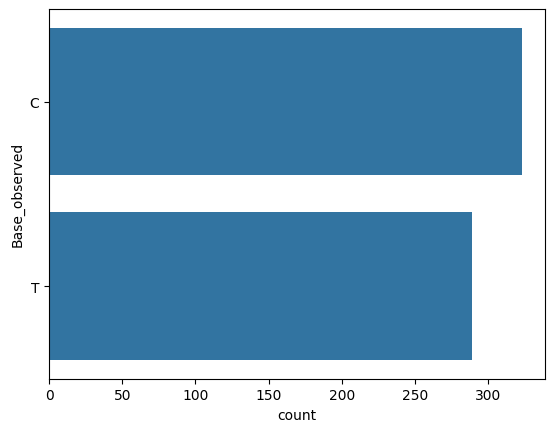

In [416]:
sns.countplot(data=SingleCellGenotype_Results_filtered_N[(SingleCellGenotype_Results_filtered_N['locus']=='chr10_3785728')], 
              y='Base_observed')

### Monoallelic loci w/ Host genotype

In [6]:
SingleCellGenotype_Results_filtered_monoallelic = SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['locus'].isin( HostGenotype[HostGenotype['AlleleType']=='monoallelic']['locus'] ))].copy()

In [7]:
HostGenotype[HostGenotype['AlleleType']=='monoallelic']

locus REF  CellCounts ObservedAllele_1  AlleleFrequency_1  \
436  chr8_100721928   T         168                T                1.0   
437   chr6_32641535   A         197                C                1.0   
438    chr7_5527637   A         166                A                1.0   
439   chr8_11844695   G         128                A                1.0   
440       chrM_2706   A        2835                G                1.0   
..              ...  ..         ...              ...                ...   
719   chr6_29828228   A         238                C                1.0   
720   chr6_29556175   A          96                G                1.0   
721  chr6_132814747   A         505                G                1.0   
722   chr6_29828268   A         245                C                1.0   
723       chrM_8860   A          15                G                1.0   

    ObservedAllele_2  AlleleFrequency_2   AlleleType  
436              NaN                0.0  monoallelic  
437              NaN                0.0  monoallelic  
438              NaN                0.0  monoallelic  
439              NaN                0.0  monoallelic  
440              NaN                0.0  monoallelic  
..               ...                ...          ...  
719              NaN                0.0  monoallelic  
720              NaN                0.0  monoallelic  
721              NaN                0.0  monoallelic  
722              NaN                0.0  monoallelic  
723              NaN                0.0  monoallelic  

[288 rows x 8 columns]

In [8]:
minimumCellCount = 5
SufficientlyCoveredLoci_Normal = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_monoallelic[SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']=='Normal'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor0 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_monoallelic[SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']=='Tumor_0'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor1 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_monoallelic[SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']=='Tumor_1'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor2 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_monoallelic[SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']=='Tumor_2'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
print(f'{len(SufficientlyCoveredLoci_Normal)}\t{len(SufficientlyCoveredLoci_Tumor0)}\t{len(SufficientlyCoveredLoci_Tumor1)}\t{len(SufficientlyCoveredLoci_Tumor2)}')

# SufficientlyCoveredLoci_intersection = SufficientlyCoveredLoci_Normal.intersection( SufficientlyCoveredLoci_Tumor0 ).intersection( SufficientlyCoveredLoci_Tumor1 ).intersection( SufficientlyCoveredLoci_Tumor2 )
dict_locus_to_presenceCounts = dict()
for lociSet in [ SufficientlyCoveredLoci_Normal, SufficientlyCoveredLoci_Tumor0, SufficientlyCoveredLoci_Tumor1, SufficientlyCoveredLoci_Tumor2 ]:
    for locus in lociSet:
        try: 
            dict_locus_to_presenceCounts[locus] += 1
        except KeyError:
            dict_locus_to_presenceCounts[locus] = 1
            
dict_locus_to_presenceCounts = { k:v for k,v in dict_locus_to_presenceCounts.items() if v>=4 }
SufficientlyCoveredLoci_intersection = set(dict_locus_to_presenceCounts.keys())
print(len(SufficientlyCoveredLoci_intersection))

288	143	142	145
134


In [9]:
dict_MonoallelicLocus_to_HostAllele = { tup.locus : tup.ObservedAllele_1 for tup in HostGenotype.itertuples() }

In [421]:
# SNV_SummaryByLocus = list()
# for locus, edf in SingleCellGenotype_Results_filtered_monoallelic[(SingleCellGenotype_Results_filtered_monoallelic['locus'].isin(SufficientlyCoveredLoci_intersection)) & 
#                                                                   (SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']!='Normal')].groupby('locus', observed=True):
#     edf_mutant = edf[(edf['condition1']==True) & (edf['condition2']==True)]
#     dict_CT_to_mutantCount = { CT : len(e) for CT, e in edf_mutant.groupby('Cell_type_observed', observed=True) }
#     dict_CT_to_Count = { CT : len(e) for CT, e in edf.groupby('Cell_type_observed', observed=True) }
    
#     for CT in ['Tumor_0', 'Tumor_1', 'Tumor_2', ]:
#         try: 
#             dict_CT_to_mutantCount[CT]
#         except KeyError:
#             dict_CT_to_mutantCount[CT] = 0
#         try:
#             dict_CT_to_Count[CT]
#         except KeyError:
#             dict_CT_to_Count[CT] = 1

#     dict_CT_to_MutAlleleFrequency = { CT : mutantCount/dict_CT_to_Count[CT] for CT, mutantCount in dict_CT_to_mutantCount.items() }
#     dict_CT_to_WtAlleleFrequency = { CT : 1-(mutantCount/dict_CT_to_Count[CT]) for CT, mutantCount in dict_CT_to_mutantCount.items() }

#     # if max(dict_CT_to_MutAlleleFrequency.values())<=0.5 or sum(dict_CT_to_Count.values())<=20: continue
#     if min(dict_CT_to_Count.values())<=3: continue

#     for CT, AF in dict_CT_to_MutAlleleFrequency.items():
#         SNV_SummaryByLocus.append( [locus, CT, dict_CT_to_mutantCount[CT], 
#                                     dict_CT_to_Count[CT] - dict_CT_to_mutantCount[CT], 
#                                     dict_CT_to_Count[CT], AF, dict_CT_to_WtAlleleFrequency[CT]] )
    
        
# SNV_SummaryByLocus = pd.DataFrame(SNV_SummaryByLocus, columns=['locus', 'CellType', 'CellCount_mut', 'CellCount_wt', 'CellCount_total', 
#                                                                'AlleleFrequency_mut', 'AlleleFrequency_wt'])
# SNV_SummaryByLocus.reset_index(inplace=True, drop=True)
# SNV_SummaryByLocus.head(2)

In [10]:
SNV_SummaryByLocus = list()
set_CellTypes = set(SingleCellGenotype_Results_filtered_monoallelic[(SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']!='Noramal')]['Cell_type_observed'])
for locus, edf in SingleCellGenotype_Results_filtered_monoallelic[(SingleCellGenotype_Results_filtered_monoallelic['locus'].isin(SufficientlyCoveredLoci_intersection)) & 
                                                                  (SingleCellGenotype_Results_filtered_monoallelic['Cell_type_observed']!='Noarmal')].groupby('locus', observed=True):
    
    HostAllele = dict_MonoallelicLocus_to_HostAllele[locus]
    
    dict_CT_to_MutantCount  = { k:0 for k in set_CellTypes }
    dict_CT_to_TotalCount   = { k:0 for k in set_CellTypes }
    for CT, edf2 in edf.groupby('Cell_type_observed', observed=True):
        dict_CT_to_TotalCount[CT]   = len(edf2)
        dict_CT_to_MutantCount[CT]  = len(edf2[edf2['Base_observed']!=HostAllele])
    
    dict_CT_to_MutAlleleFrequency = { CT : MC/dict_CT_to_TotalCount[CT] for CT, MC in dict_CT_to_MutantCount.items() }
    dict_CT_to_MutAlleleFrequency = dict()
    for CT, MC in dict_CT_to_MutantCount.items():
        try:
            dict_CT_to_MutAlleleFrequency[CT] = MC/dict_CT_to_TotalCount[CT]
        except ZeroDivisionError:
            dict_CT_to_MutAlleleFrequency[CT] = None
            
    #! Toggle this on/off to include/exclude informative SNVs
    if max(dict_CT_to_MutAlleleFrequency.values())<=0.1: continue
    
    for CT, AF in dict_CT_to_MutAlleleFrequency.items():
        SNV_SummaryByLocus.append( [locus, CT, dict_CT_to_MutantCount[CT], 
                                    dict_CT_to_TotalCount[CT], AF,] )
        
SNV_SummaryByLocus = pd.DataFrame(SNV_SummaryByLocus, columns=['locus', 'CellType', 'MutantCount', 'TotalCount', 'AlleleFrequency_mut'])

In [424]:
# chr17_75779183    Tumor_2
# chr12_6869258     Tumor 0,1
# chr9_133350250    Tumor 0,1
# chr19_49491085    Tumor 1
# chr19_38376376    Tumor 2

In [11]:
SNV_SummaryByLocus_mut_pivotted = SNV_SummaryByLocus.pivot(columns='locus', index='CellType', values='AlleleFrequency_mut').T.sort_values(['Tumor_2', 'Tumor_0'], )
# SNV_SummaryByLocus_mut_pivotted.fillna(0, inplace=True)
SNV_SummaryByLocus_mut_pivotted.shape

(134, 4)

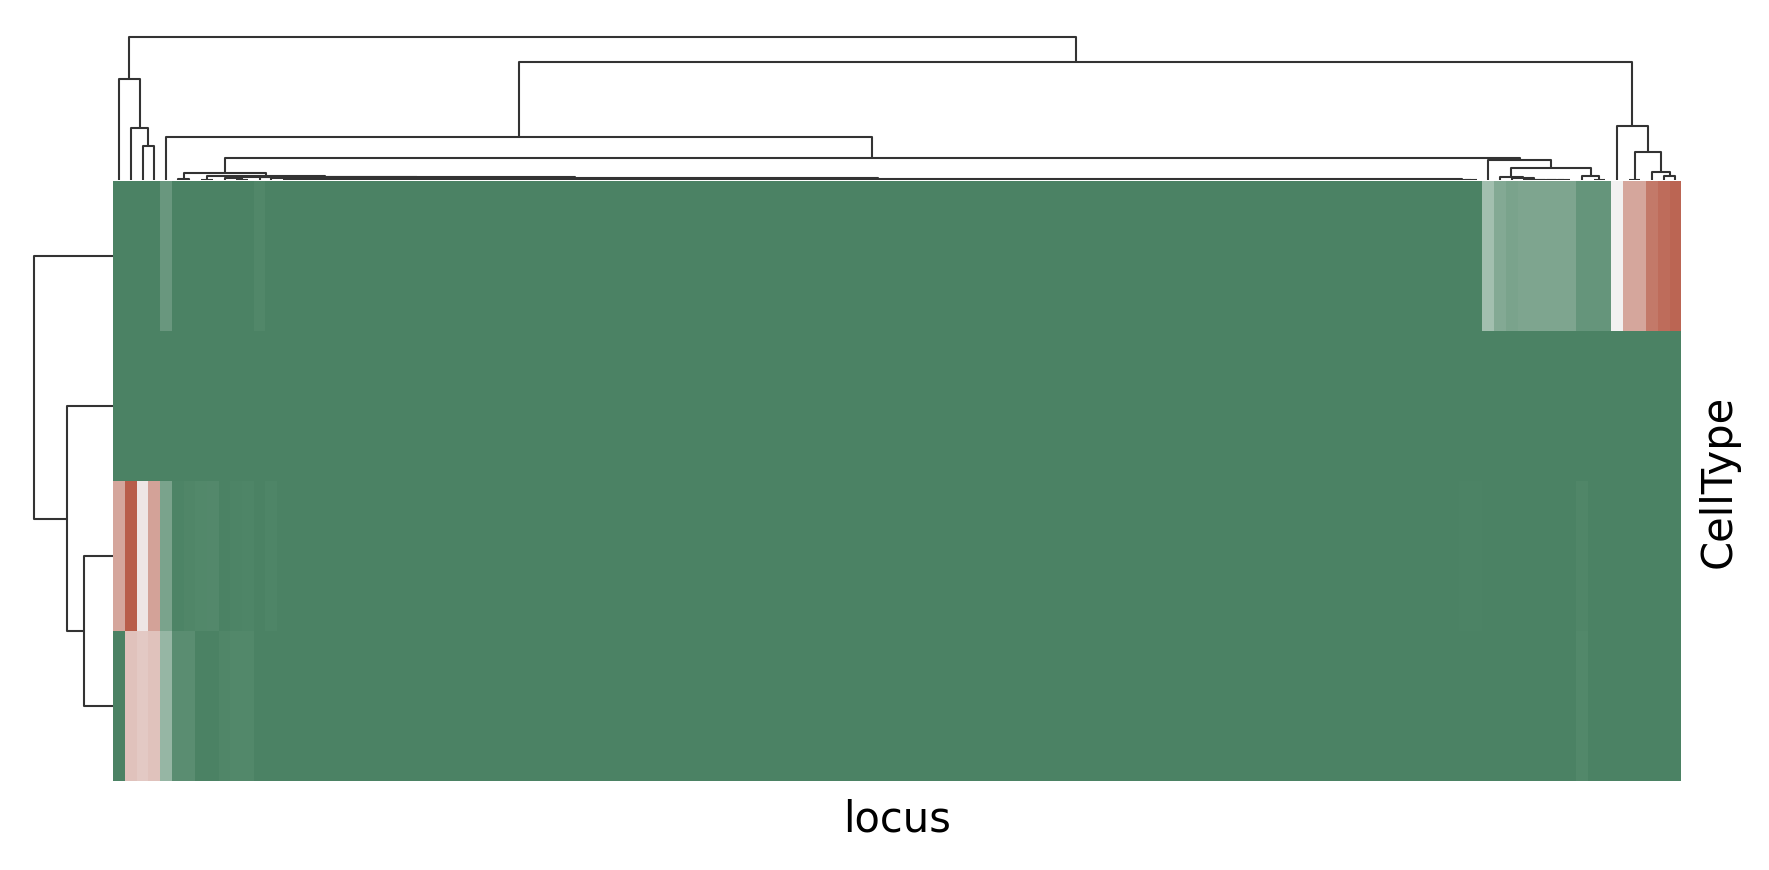

In [17]:

cmap_e = sns.diverging_palette(
    h_neg=210,  # Hue for steelblue (~210° in HSL color space)
    h_pos=20,    # Hue for maroon (~0° in HSL color space)
    s=75,       # Saturation (higher means more vivid colors)
    l=50,       # Lightness (50% gives balanced colors)
    as_cmap=True  # Return as a colormap
)

plt.rcParams["figure.dpi"] = 300
ax = sns.clustermap(SNV_SummaryByLocus_mut_pivotted.T, 
               # cmap=sns.light_palette("darkred", as_cmap=True),
               # cmap=sns.diverging_palette(220, 20, as_cmap=True),
               cmap=sns.diverging_palette(145, 20, s=60, as_cmap=True),
               figsize=(6, 3), 
                dendrogram_ratio=(.05, .2),
               cbar_pos=None,
               **{'robust':False, 
                  # 'cbar':False, 
                  'xticklabels':False, 'yticklabels':False,},
               )
# ax.set_xticks([]);
# ax.set_xticklabels([]);

In [ ]:
# chr17_75779183    Tumor_2
# chr12_6869258     Tumor 0,1
# chr9_133350250    Tumor 0,1
# chr19_49491085    Tumor 1
# chr19_38376376    Tumor 2

### Biallelic loci w/ Host genotype → No loci

In [290]:
HostGenotype_biallelic = HostGenotype[(HostGenotype['AlleleType']=='biallelic')].copy()
TrueBiallelicLoci = list()
for tup in HostGenotype_biallelic.itertuples():
    if min( [tup.AlleleFrequency_1, tup.AlleleFrequency_2] ) < 0.3: continue 
    TrueBiallelicLoci.append(tup.locus)
HostGenotype_biallelic = HostGenotype_biallelic[(HostGenotype_biallelic['locus'].isin(TrueBiallelicLoci))].copy()
HostGenotype_biallelic.reset_index(inplace=True, drop=True)
HostGenotype_biallelic

locus REF  CellCounts ObservedAllele_1  AlleleFrequency_1  \
0    chr10_27127818   T          33                G           0.515152   
1     chr2_90154418   T          81                C           0.641975   
2     chr2_90154388   A          40                A           0.575000   
3     chr4_24799693   G          38                A           0.394737   
4     chr3_50320438   A          57                A           0.631579   
..              ...  ..         ...              ...                ...   
391   chr1_22647804   C          43                A           0.511628   
392  chr14_21723859   A          34                A           0.441176   
393   chr1_22638945   A         113                A           0.557522   
394   chr16_1964590   C          34                C           0.558824   
395  chr16_21502110   G          30                C           0.566667   

    ObservedAllele_2  AlleleFrequency_2 AlleleType  
0                  T           0.484848  biallelic  
1                  T           0.358025  biallelic  
2                  G           0.425000  biallelic  
3                  G           0.605263  biallelic  
4                  C           0.368421  biallelic  
..               ...                ...        ...  
391                C           0.488372  biallelic  
392                G           0.558824  biallelic  
393                G           0.442478  biallelic  
394                T           0.441176  biallelic  
395                G           0.433333  biallelic  

[396 rows x 8 columns]

In [291]:
SingleCellGenotype_Results_filtered_biallelic = SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['locus'].isin( HostGenotype_biallelic['locus'] ))].copy()
SingleCellGenotype_Results_filtered_biallelic.shape

(104461, 16)

In [292]:
minimumCellCount = 8
SufficientlyCoveredLoci_Normal = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_biallelic[SingleCellGenotype_Results_filtered_biallelic['Cell_type_observed']=='Normal'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor0 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_biallelic[SingleCellGenotype_Results_filtered_biallelic['Cell_type_observed']=='Tumor_0'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor1 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_biallelic[SingleCellGenotype_Results_filtered_biallelic['Cell_type_observed']=='Tumor_1'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor2 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered_biallelic[SingleCellGenotype_Results_filtered_biallelic['Cell_type_observed']=='Tumor_2'].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
print(f'{len(SufficientlyCoveredLoci_Normal)}\t{len(SufficientlyCoveredLoci_Tumor0)}\t{len(SufficientlyCoveredLoci_Tumor1)}\t{len(SufficientlyCoveredLoci_Tumor2)}')

SufficientlyCoveredLoci_intersection = SufficientlyCoveredLoci_Normal.intersection( SufficientlyCoveredLoci_Tumor0 ).intersection( SufficientlyCoveredLoci_Tumor1 ).intersection( SufficientlyCoveredLoci_Tumor2 )
print(len(SufficientlyCoveredLoci_intersection))

396	59	43	51
38


In [294]:
dict_BiallelicLocus_to_HostAllele = { tup.locus : '/'.join(sorted([tup.ObservedAllele_1, tup.ObservedAllele_2])) for tup in HostGenotype[HostGenotype['AlleleType']=='biallelic'].itertuples() }

In [345]:
SNV_SummaryByLocus = list()
set_CellTypes = set(SingleCellGenotype_Results_filtered_biallelic[(SingleCellGenotype_Results_filtered_biallelic['Cell_type_observed']!='Normal')]['Cell_type_observed'])
for locus, edf in SingleCellGenotype_Results_filtered_biallelic[(SingleCellGenotype_Results_filtered_biallelic['locus'].isin(SufficientlyCoveredLoci_intersection)) & 
                                                                  (SingleCellGenotype_Results_filtered_biallelic['Cell_type_observed']!='Normal')].groupby('locus', observed=True):
    
    HostAllele = dict_BiallelicLocus_to_HostAllele[locus].split('/')
    
    dict_CT_to_MutantCount  = { k:0 for k in set_CellTypes }
    dict_CT_to_TotalCount   = { k:0 for k in set_CellTypes }
    for CT, edf2 in edf.groupby('Cell_type_observed', observed=True):
        dict_CT_to_TotalCount[CT]   = len(edf2)
        dict_CT_to_MutantCount[CT]  = len(edf2[~edf2['Base_observed'].isin(HostAllele)])

    
    dict_CT_to_MutAlleleFrequency = { CT : MC/dict_CT_to_TotalCount[CT] for CT, MC in dict_CT_to_MutantCount.items() }
    if max(dict_CT_to_MutAlleleFrequency.values())<=0.2: continue
    
    for CT, AF in dict_CT_to_MutAlleleFrequency.items():
        SNV_SummaryByLocus.append( [locus, CT, dict_CT_to_MutantCount[CT], 
                                    dict_CT_to_TotalCount[CT], AF,] )
    
SNV_SummaryByLocus = pd.DataFrame(SNV_SummaryByLocus, columns=['locus', 'CellType', 'MutantCount', 'TotalCount', 'AlleleFrequency_mut'])
SNV_SummaryByLocus

Empty DataFrame
Columns: [locus, CellType, MutantCount, TotalCount, AlleleFrequency_mut]
Index: []

### Loci w/o host genotype

In [348]:
minimumCellCount = 8
SufficientlyCoveredLoci_Tumor0 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['Cell_type_observed']=='Tumor_0') & 
                                                                                                   ~(SingleCellGenotype_Results_filtered['locus'].isin(HostGenotype['locus']))].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor1 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['Cell_type_observed']=='Tumor_1') & 
                                                                                                   ~(SingleCellGenotype_Results_filtered['locus'].isin(HostGenotype['locus']))].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
SufficientlyCoveredLoci_Tumor2 = set( [locus for locus, edf in SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['Cell_type_observed']=='Tumor_2') & 
                                                                                                   ~(SingleCellGenotype_Results_filtered['locus'].isin(HostGenotype['locus']))].groupby('locus', observed=True) if len(edf)>=minimumCellCount] )
print(f'{len(SufficientlyCoveredLoci_Tumor0)}\t{len(SufficientlyCoveredLoci_Tumor1)}\t{len(SufficientlyCoveredLoci_Tumor2)}')

SufficientlyCoveredLoci_intersection = SufficientlyCoveredLoci_Tumor0.intersection( SufficientlyCoveredLoci_Tumor1 ).intersection( SufficientlyCoveredLoci_Tumor2 )
print(len(SufficientlyCoveredLoci_intersection))

90	91	74
68


In [359]:
SNV_SummaryByLocus = list()
AlleleCalling_threshold = 0.9

set_CellTypes = set(SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['Cell_type_observed']!='Normal')]['Cell_type_observed'])
for locus, edf in SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['locus'].isin(SufficientlyCoveredLoci_intersection)) & 
                                                      (SingleCellGenotype_Results_filtered['Cell_type_observed']!='Normal')].groupby('locus', observed=True):
        
    dict_CT_to_AlleleCount  = { k:{'A' : 0, 'T' : 0, 'C' : 0, 'G' : 0} for k in set_CellTypes }
    dict_CT_to_TotalCount   = { k:0 for k in set_CellTypes }
    
    for CT, edf2 in edf.groupby('Cell_type_observed', observed=True):
        for Base_observed, edf3 in edf2.groupby('Base_observed', observed=True):
            dict_CT_to_AlleleCount[CT][Base_observed] += len(edf3)
        dict_CT_to_TotalCount[CT] = len(edf2)
        
    # if min(dict_CT_to_TotalCount.values())<=20: continue
    
    for CT, AC in dict_CT_to_AlleleCount.items():
        
        CT_Allele = None
        for Allele, Count in AC.items():
            if Count/dict_CT_to_TotalCount[CT] >= AlleleCalling_threshold:
                CT_Allele = Allele 
                break 
            
        if CT_Allele == None:
            print(locus)
            raise ValueError
        
        # for nt, c in AC.items():
        #     SNV_SummaryByLocus.append( [locus, CT, nt, c, dict_CT_to_TotalCount[CT]] )
            
    # if locus =='chr10_133370622': break
        
SNV_SummaryByLocus = pd.DataFrame(SNV_SummaryByLocus, columns=['locus', 'CellType', 'Allele', 'Count', 'TotalCount'])
SNV_SummaryByLocus

chr11_67586108


ValueError: 

### Umap visualization of individual locus

In [678]:
for locus, edf in SNV_SummaryByLocus.groupby('locus'):
    SingleCellGenotype_Results_filtered_oi = SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['locus']==locus)]
    REF_allele = SingleCellGenotype_Results_filtered_oi.iloc[0].REF.split(',')[0]
    ALT_allele = SingleCellGenotype_Results_filtered_oi.iloc[0].ALT_expected.split(',')[0]
    print(locus, REF_allele, ALT_allele)

chr11_65919826 T C
chr12_6869258 C T
chr14_24145385 A G
chr17_75779183 A G
chr19_38376376 A G
chr19_39407943 C T
chr19_5691355 A G
chr1_153977469 C T
chr2_55233364 T C
chr4_39456431 A G
chr8_99887586 G A
chrM_5031 G A


In [674]:
locus_of_interest = 'chrM_5031'
SingleCellGenotype_Results_filtered_oi = SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['locus']==locus_of_interest)]
dict_Identifier_to_BaseObserved = { Identifier : '/'.join(sorted(edf['Base_observed'])) for Identifier, edf in SingleCellGenotype_Results_filtered_oi.groupby('Identifier') }
for Identifier in adata_SC035.obs['Identifier']:
    try: dict_Identifier_to_BaseObserved[Identifier]
    except KeyError: dict_Identifier_to_BaseObserved[Identifier] = 'N/A'
adata_SC035.obs['SNP_allele'] = [ dict_Identifier_to_BaseObserved[Identifier] for Identifier in adata_SC035.obs['Identifier'] ]
adata_epi_tumor_SC035.obs['SNP_allele'] = [ dict_Identifier_to_BaseObserved[Identifier] for Identifier in adata_epi_tumor_SC035.obs['Identifier'] ]


REF_allele = SingleCellGenotype_Results_filtered_oi.iloc[0].REF.split(',')[0]
ALT_allele = SingleCellGenotype_Results_filtered_oi.iloc[0].ALT_expected.split(',')[0]

colHasMut = list()
for tup in adata_epi_tumor_SC035.obs.itertuples():
    if tup.SNP_allele == 'N/A':
        colHasMut.append('N/A')
    else:
        colHasMut.append( str(bool(tup.SNP_allele!=REF_allele)) )
adata_epi_tumor_SC035.obs['HasMut'] = colHasMut

print(REF_allele, ALT_allele)

G A


In [688]:
adata_epi_tumor_SC035.obs['SComatic_CellType2'] = [ f'Leiden {int(tup.SC035_subLeiden)+1}' for tup in adata_epi_tumor_SC035.obs.itertuples() ]

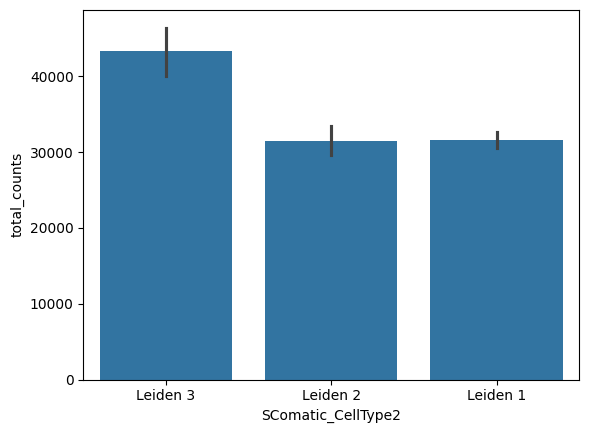

In [694]:
sns.barplot(data=adata_epi_tumor_SC035.obs, x='SComatic_CellType2', y='MSI_score',)
plt.show()

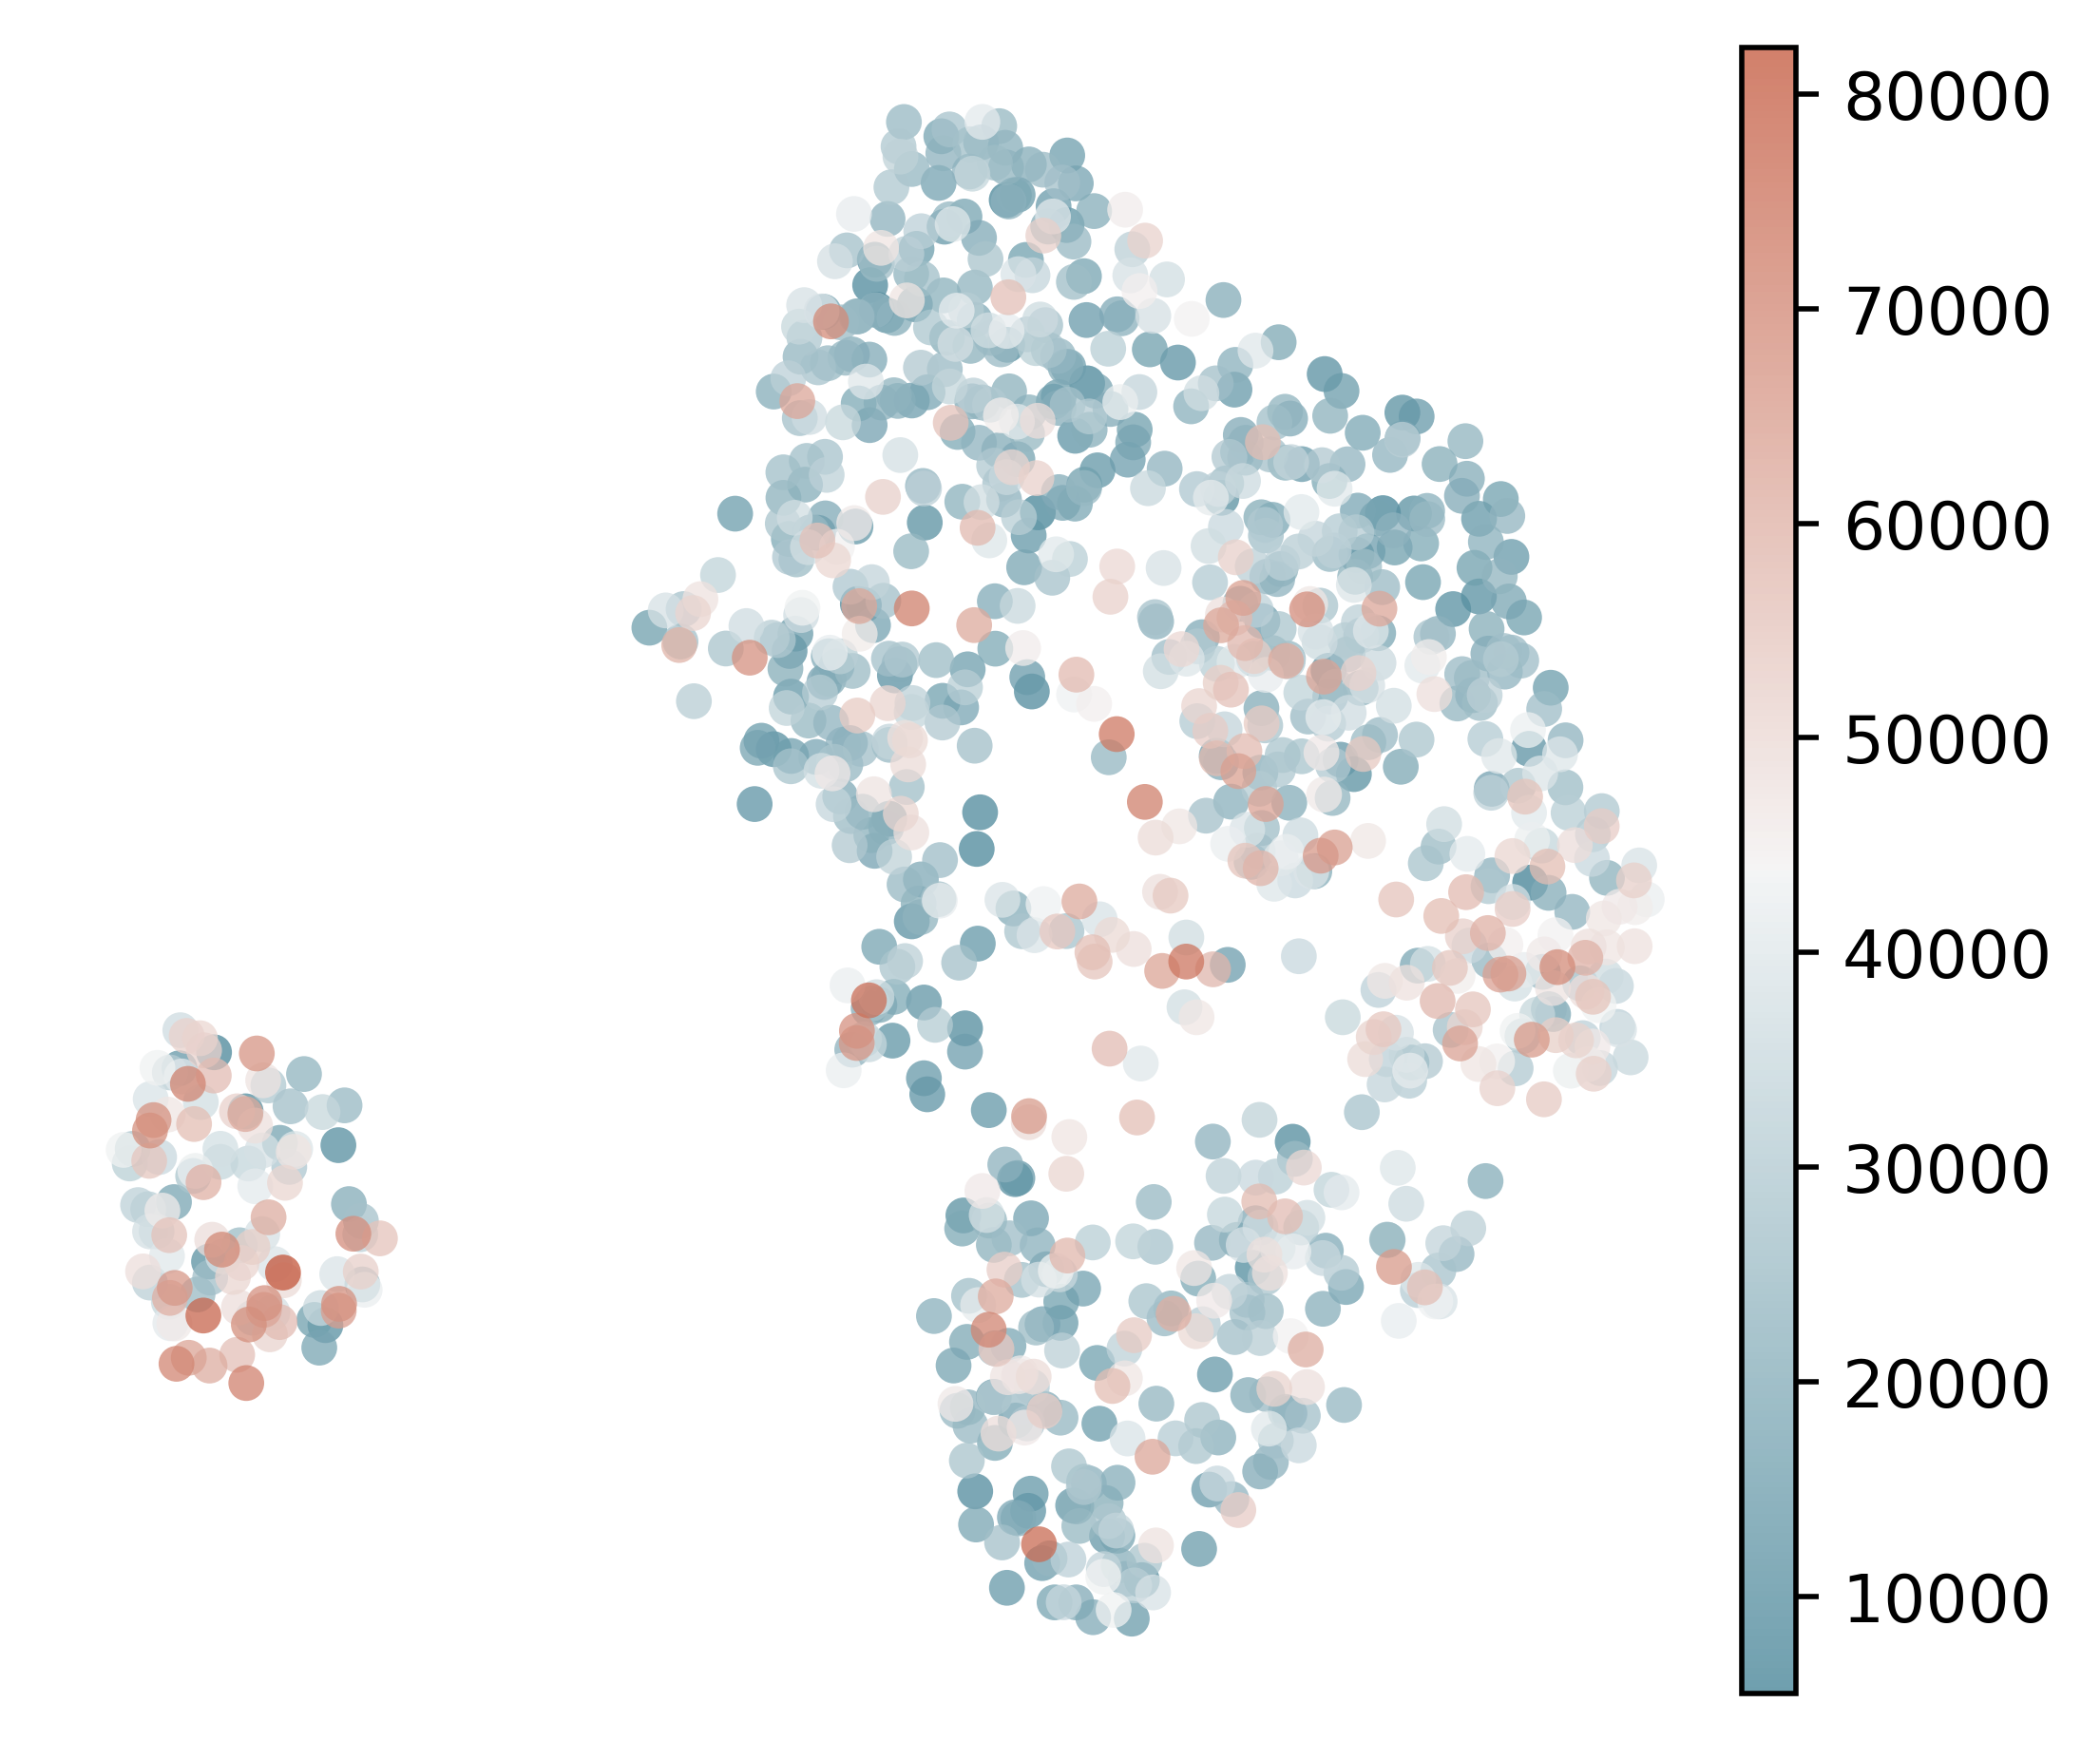

In [681]:
palette_e = {REF_allele : 'gray', 
             ALT_allele : sns.color_palette('tab20c')[4], 
             'True' : sns.color_palette('tab20c')[4],
             'False' : 'gray',
             'N/A' : 'lightgray',
             }

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 4.5)},):
    sc.pl.umap(adata_epi_tumor_SC035, 
            color=['total_counts',], 
            ncols=1,
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            # palette=palette_e,
            alpha=0.75,
            frameon=False,
            title='',
            legend_loc='',
            )

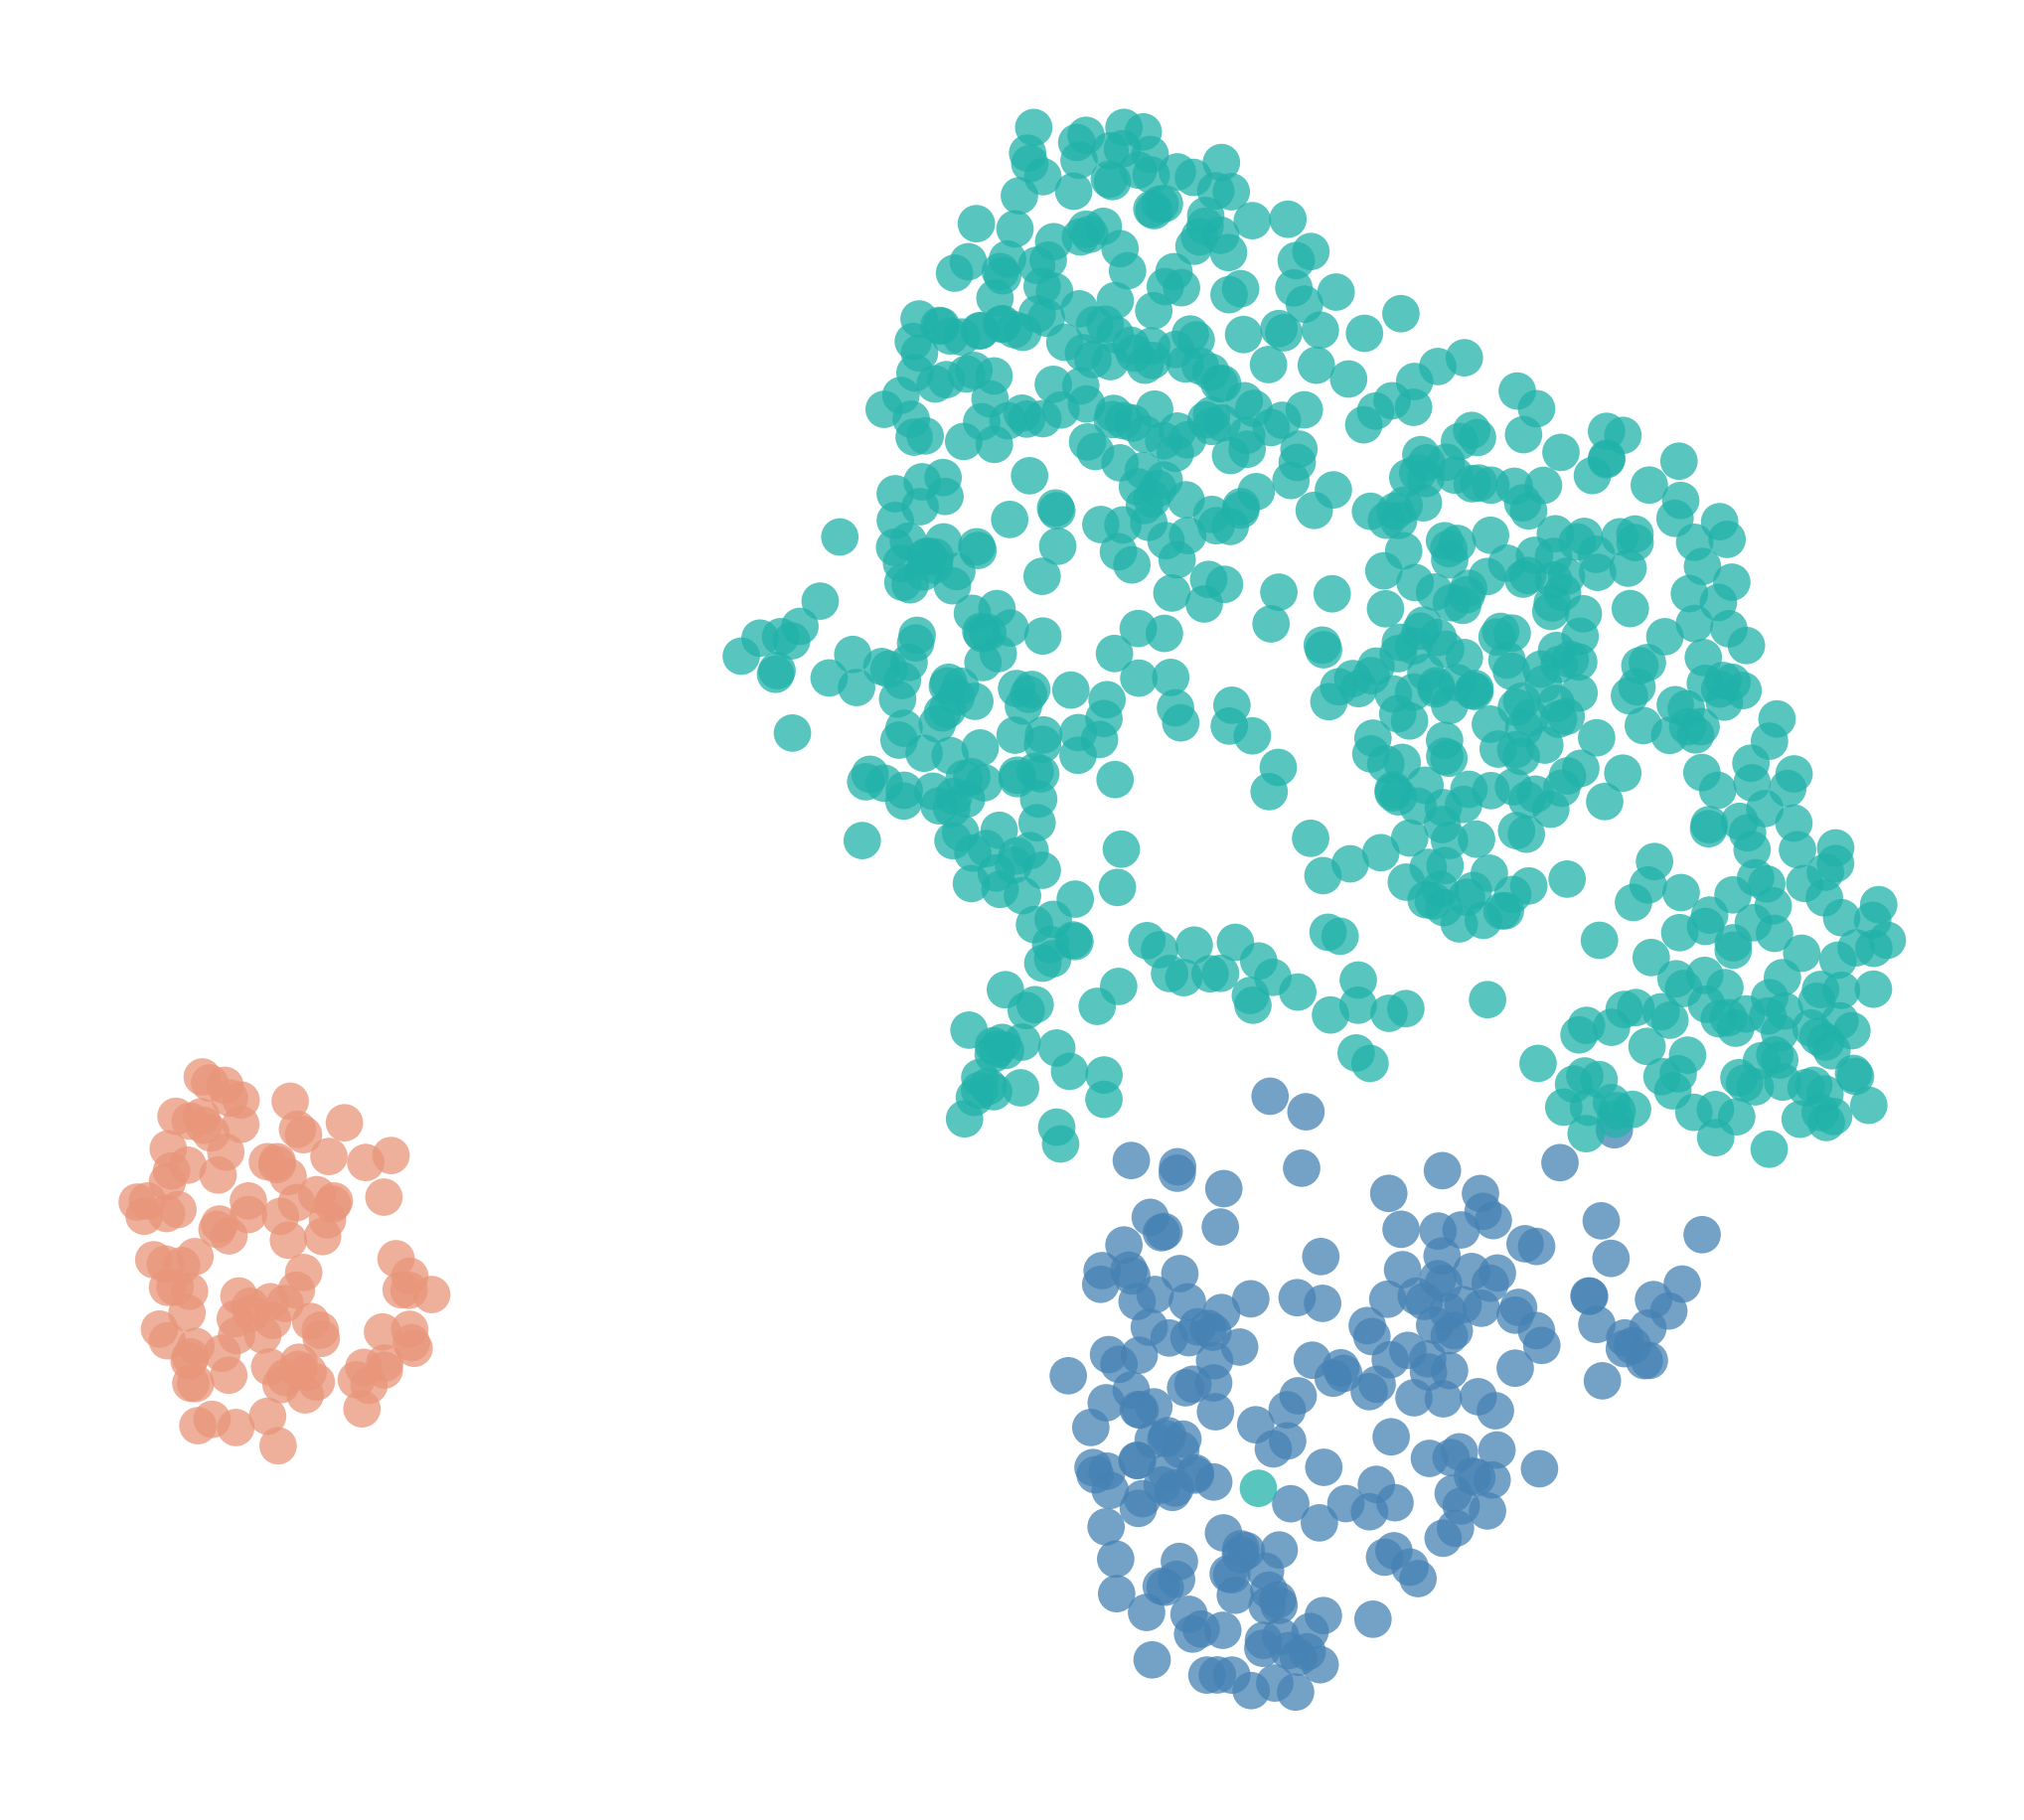

In [31]:
dict_CT1_to_CT2 = { 'Normal' : 'Normal', 'Tumor_0' : 'Tumor 1', 'Tumor_1' : 'Tumor 1', 'Tumor_2' : 'Tumor 2'}
adata_epi_tumor_SC035.obs['SComatic_CellType2'] = [ dict_CT1_to_CT2[CT1] for CT1 in adata_epi_tumor_SC035.obs['SComatic_CellType'] ]

palette_e = {'Normal' : 'dimgray', 
             'Tumor_0' : 'lightseagreen', 
             'Tumor_1' : 'steelblue', 
             'Tumor_2' : 'darksalmon', 
       #       'Tumor_0' : sns.color_palette('Paired')[1], 
       #       'Tumor_1' : sns.color_palette('Paired')[3], 
       #       'Tumor_2' : sns.color_palette('Paired')[5], 
             # REF_allele : sns.color_palette('tab20c')[0],
       #       REF_allele : 'gray',
       #       ALT_allele : sns.color_palette('tab20c')[4], 
                    'N/A' : 'lightgray',
                    
                    }

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 4.5)},):
       sc.pl.umap(adata_epi_tumor_SC035, 
              color=['SComatic_CellType',],  #  SComatic_CellType2, 'SNP_allele', 'MSI_score'
              # s=25,
              cmap=sns.diverging_palette(220, 20, as_cmap=True),
              
              palette=palette_e,
              legend_loc=None,
              colorbar_loc=None,
              alpha=0.75,
              title='',
              frameon=False,
              )

<Axes: title={'center': 'MSI_score'}, xlabel='UMAP1', ylabel='UMAP2'>

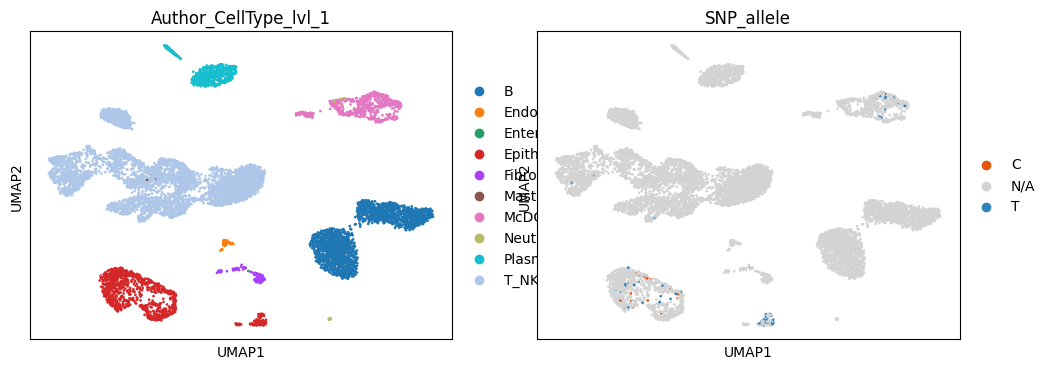

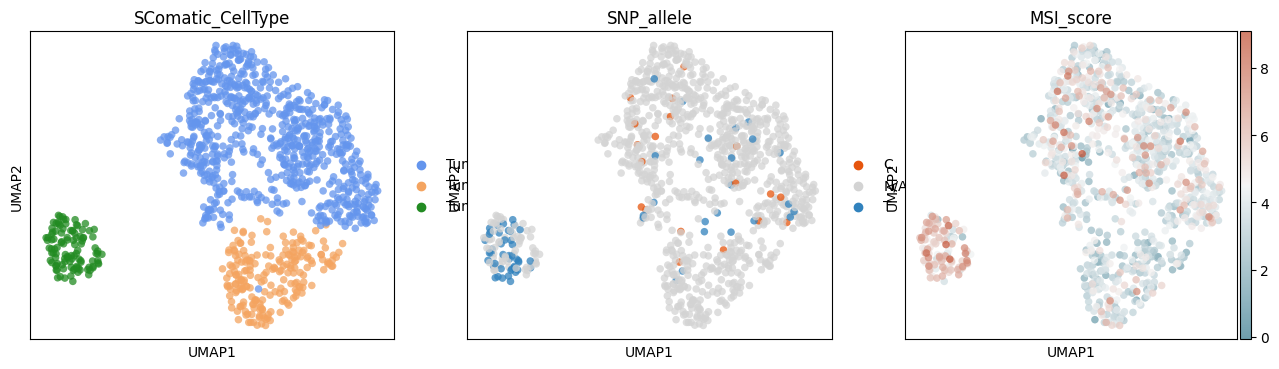

In [547]:
palette_e = {'Normal' : 'dimgray', 'Tumor_0' : 'cornflowerblue', 'Tumor_1' : 'sandybrown', 'Tumor_2' : 'forestgreen', 
                    REF_allele : sns.color_palette('tab20c')[0], 
                    ALT_allele : sns.color_palette('tab20c')[4], 
                    'N/A' : 'lightgray',
                    }

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sc.pl.umap(adata_SC035, 
           color=['Author_CellType_lvl_1',], 
           ncols=1, size=15,
           show=False,
           ax=axes[0]
           )
sc.pl.umap(adata_SC035, 
           color=['SNP_allele',], 
           ncols=1, size=15,
           show=False,
           palette=palette_e,
           ax=axes[1]
           )

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sc.pl.umap(adata_epi_tumor_SC035, 
           color=['SComatic_CellType', ], 
           ncols=1,
           cmap=sns.diverging_palette(220, 20, as_cmap=True),
           palette=palette_e,
              alpha=0.75,
           show=False,
           ax=axes[0]
           )

sc.pl.umap(adata_epi_tumor_SC035, 
           color=['SNP_allele',], 
           ncols=1,
           cmap=sns.diverging_palette(220, 20, as_cmap=True),
           palette=palette_e,
              alpha=0.75,
           show=False,
           ax=axes[1]
           )

sc.pl.umap(adata_epi_tumor_SC035, 
           color=['MSI_score'], 
           ncols=1,
           cmap=sns.diverging_palette(220, 20, as_cmap=True),
           palette=palette_e,
              alpha=0.75,
           show=False,
           ax=axes[2]
           )

In [835]:
SNP_SummaryByLocus = list()
SingleCellGenotype_Results_filtered['ALT_expected2'] = [ ALT.split(',')[0] for ALT in SingleCellGenotype_Results_filtered['ALT_expected'] ]
AllCellTypes = [CT for CT in set(SingleCellGenotype_Results_filtered['Cell_type_observed']) if CT !='Noramal']

for locus, edf in SingleCellGenotype_Results_filtered[SingleCellGenotype_Results_filtered['Cell_type_observed']!='Noarmal'].groupby('locus', observed=True):
    
    # edf_mutant = edf[(edf['ALT_expected2']==edf['Base_observed'])]
    edf_mutant = edf[(edf['condition1']==True) & (edf['condition2']==True)]
    dict_CT_to_mutantCount = { CT : len(e) for CT, e in edf_mutant.groupby('Cell_type_observed', observed=True) }
    dict_CT_to_Count = { CT : len(e) for CT, e in edf.groupby('Cell_type_observed', observed=True) }

    approach = 1
    
    if approach == 1:
    
        for CT in AllCellTypes: # , 'Normal'
            try: dict_CT_to_mutantCount[CT]
            except KeyError: dict_CT_to_mutantCount[CT] = 0 
        dict_CT_to_mutantCount = dict(sorted(dict_CT_to_mutantCount.items(), key=lambda x:x[1], reverse=True))
        for k, v in dict_CT_to_mutantCount.items():
            MajorCellType = k
            break
        
        if sum(dict_CT_to_mutantCount.values())==0: continue
        
        for CT, counts in dict_CT_to_mutantCount.items():
            SNP_SummaryByLocus.append( [locus, CT, counts, 
                                        counts/sum(dict_CT_to_mutantCount.values()),
                                        # counts/dict_SComaticCellType_to_nCells[CT],  
                                        sum(dict_CT_to_mutantCount.values())] )

    else:
        dict_CT_to_AlleleFrequency = { CT : mutantCount/dict_CT_to_Count[CT] for CT, mutantCount in dict_CT_to_mutantCount.items() }
        
        for CT, AF in dict_CT_to_AlleleFrequency.items():
            SNP_SummaryByLocus.append( [locus, CT, dict_CT_to_mutantCount[CT], 
                                        dict_CT_to_Count[CT] - dict_CT_to_mutantCount[CT], 
                                        dict_CT_to_Count[CT], AF] )
        

    if locus == 'chr14_75278923':
        print(dict_CT_to_mutantCount)
        # print(dict_CT_to_hasMut)
        
SNP_SummaryByLocus= pd.DataFrame(SNP_SummaryByLocus, columns=['locus', 'CellType', 'counts', 'proportion', 'n_cells'])
# SNP_SummaryByLocus = pd.DataFrame(SNP_SummaryByLocus, columns=['locus', 'CellType', 'CellCount_mut', 'CellCount_wt', 'CellCount_total', 'AlleleFrequency'])
SNP_SummaryByLocus.reset_index(inplace=True, drop=True)

{'Normal': 568, 'Tumor_0': 22, 'Tumor_1': 10}


In [834]:
SNP_SummaryByLocus

locus CellType  CellCount_mut  CellCount_wt  CellCount_total  \
0     chr10_133370622   Normal             12             0               12   
1     chr10_133370622  Tumor_0            125             0              125   
2     chr10_133370622  Tumor_1             64             0               64   
3      chr10_32056210   Normal             12             0               12   
4      chr10_32056210  Tumor_0            299             0              299   
...               ...      ...            ...           ...              ...   
1291        chrM_8473  Tumor_1            106             0              106   
1292        chrM_8860   Normal             15             0               15   
1293        chrM_8860  Tumor_0            321             0              321   
1294        chrM_8860  Tumor_1             85             0               85   
1295        chrM_9209   Normal              1             3                4   

      AlleleFrequency  
0                1.00  
1                1.00  
2                1.00  
3                1.00  
4                1.00  
...               ...  
1291             1.00  
1292             1.00  
1293             1.00  
1294             1.00  
1295             0.25  

[1296 rows x 6 columns]

In [831]:
edf_mutant

#CHROM  Start   End REF ALT_expected Cell_type_expected  \
195960   chrM   9209  9209   G            A             Normal   

       Num_cells_expected                CB Cell_type_observed Base_observed  \
195960                  5  CGGAGTCAGGTCGGAT             Normal             A   

        Num_reads SampleID      locus               Identifier  condition1  \
195960          5   EXT049  chrM_9209  EXT049-CGGAGTCAGGTCGGAT        True   

        condition2 ALT_expected2  
195960        True             A

In [683]:
dict_SComaticCellType_to_nCells

{'Tumor_0': 704, 'Tumor_1': 209, 'Tumor_2': 106}

In [ ]:
for locus, edf in SNP_SummaryByLocus.groupby('locus'):
    dict_CT_to_hasMut = { tup.CellType : tup.HasMut for tup in edf.itertuples() }
    if (dict_CT_to_hasMut['Tumor_1'] == True and dict_CT_to_hasMut['Tumor_2'] == True) and (dict_CT_to_hasMut['Tumor_0']==False):
        print(locus)

In [769]:
cmap_e = [ sns.light_palette("coral", as_cmap=False)[0], sns.light_palette("coral", as_cmap=False)[1], sns.light_palette("coral", as_cmap=False)[1], 
sns.light_palette("coral", as_cmap=False)[-1], sns.light_palette("coral", as_cmap=False)[-1], sns.light_palette("coral", as_cmap=False)[-1] ]

<Axes: xlabel='CellType', ylabel='locus'>

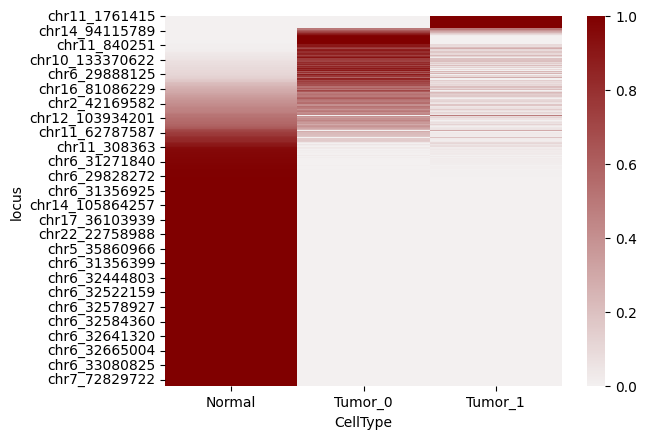

In [822]:
sns.heatmap(SNP_SummaryByLocus.pivot(columns='locus', index='CellType', values='proportion').T.sort_values(['Normal', 'Tumor_0', 'Tumor_1']), 
               cmap=sns.light_palette("maroon", as_cmap=True),)

In [565]:
ClusterOi = 'Tumor_1'
for locus, edf in SNP_SummaryByLocus.groupby('locus'):
    dict_MCT_to_proportion = { tup.MajorCellType : tup.proportion for tup in edf.itertuples() }
    if dict_MCT_to_proportion['Tumor_1'] >= 0.1 and dict_MCT_to_proportion['Tumor_']

locus MajorCellType  proportion
0     chr10_133370622       Tumor_0    0.517413
1     chr10_133370622       Tumor_2    0.318408
2     chr10_133370622       Tumor_1    0.104478
3     chr10_133370622        Normal    0.059701
4      chr10_32056210       Tumor_0    0.768786
...               ...           ...         ...
1199        chrM_8473       Tumor_2    0.022830
1200        chrM_8860       Tumor_0    0.584323
1201        chrM_8860       Tumor_2    0.201900
1202        chrM_8860       Tumor_1    0.178147
1203        chrM_8860        Normal    0.035629

[1204 rows x 3 columns]

In [ ]:
# chr17_75779183    Tumor_2
# chr12_6869258     Tumor 0,1
# chr9_133350250    Tumor 0,1
# chr19_49491085    Tumor 1
# chr19_38376376    Tumor 2

In [800]:
locus_of_interest = 'chr10_133370622'
SingleCellGenotype_Results_filtered_oi = SingleCellGenotype_Results_filtered[(SingleCellGenotype_Results_filtered['locus']==locus_of_interest)]
dict_Identifier_to_BaseObserved = { tup.Identifier : tup.Base_observed for tup in SingleCellGenotype_Results_filtered_oi.itertuples() }
for Identifier in adata_SC035.obs['Identifier']:
    try: dict_Identifier_to_BaseObserved[Identifier]
    except KeyError: dict_Identifier_to_BaseObserved[Identifier] = 'N/A'
adata_SC035.obs['SNP_allele'] = [ dict_Identifier_to_BaseObserved[Identifier] for Identifier in adata_SC035.obs['Identifier'] ]
adata_SC035_epi.obs['SNP_allele'] = [ dict_Identifier_to_BaseObserved[Identifier] for Identifier in adata_SC035_epi.obs['Identifier'] ]

REF_allele = SingleCellGenotype_Results_filtered_oi.iloc[0].REF.split(',')[0]
ALT_allele = SingleCellGenotype_Results_filtered_oi.iloc[0].ALT_expected.split(',')[0]
print(REF_allele, ALT_allele)

G A


In [ ]:
# chr12_66057580
# chr12_66057586
# chr14_75278923
# chr19_35157462
# chr19_41729356
# chr2_231708582
# chr7_45768682
# chr7_45768685
# chr7_45768717
# chr7_56116040
# chr7_56116044
# chr7_56116048
# chr8_18071302
# chr9_89310606
# chrM_16362
# chrM_16519

In [456]:
sc.tl.tsne(adata_SC035,)

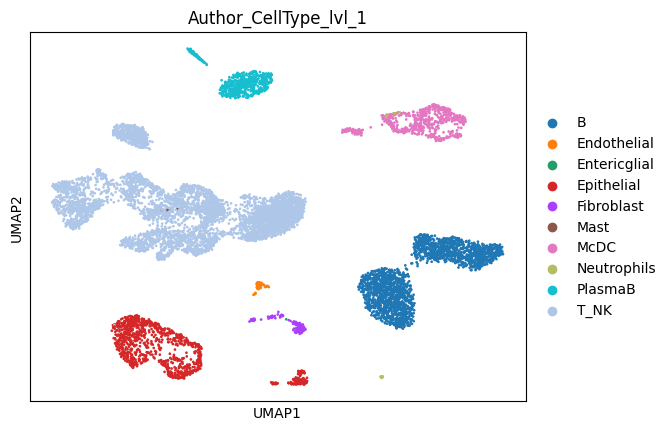

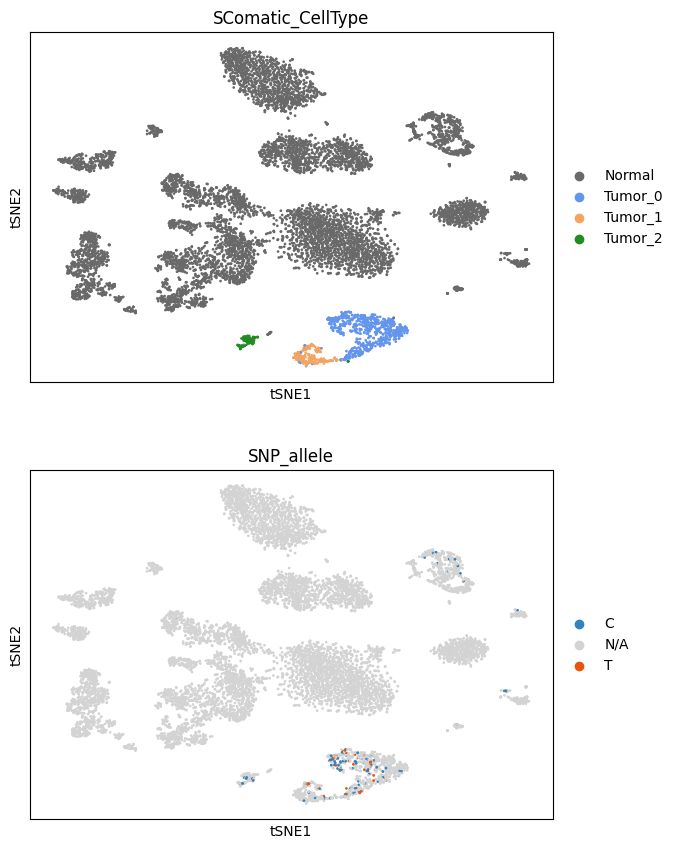

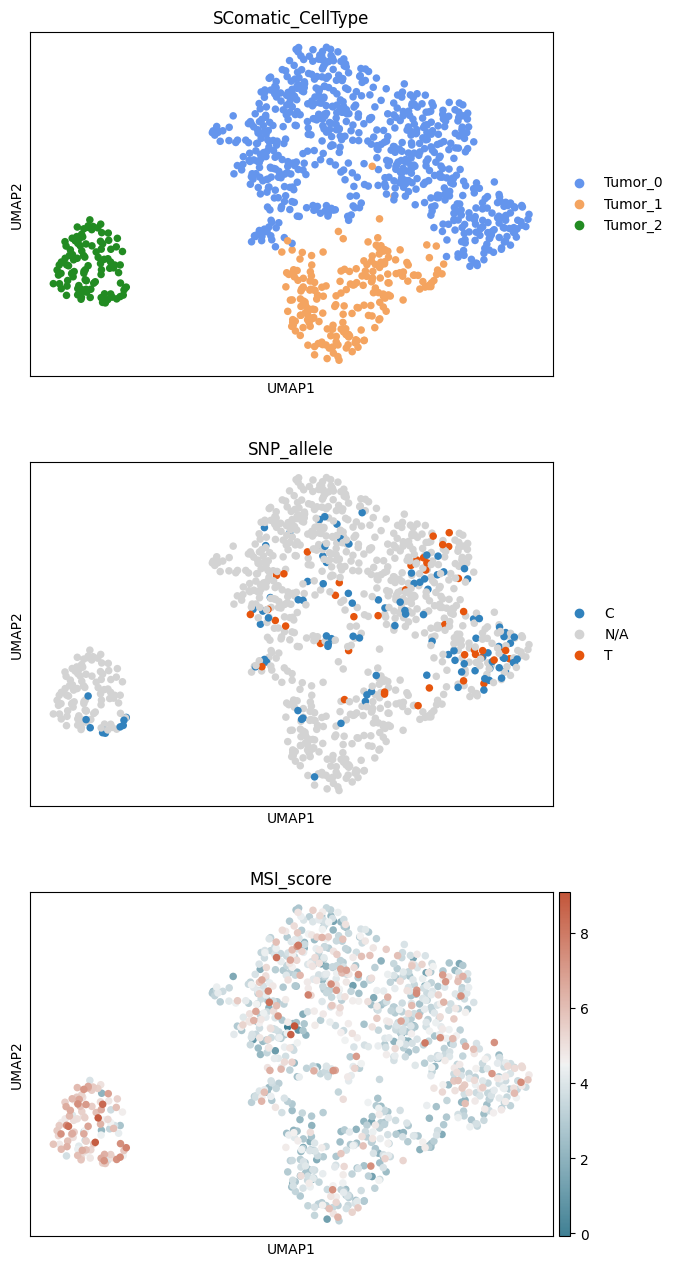

In [516]:
palette_e = {'Normal' : 'dimgray', 'Tumor_0' : 'cornflowerblue', 'Tumor_1' : 'sandybrown', 'Tumor_2' : 'forestgreen', 
                    REF_allele : sns.color_palette('tab20c')[0], 
                    ALT_allele : sns.color_palette('tab20c')[4], 
                    'N/A' : 'lightgray',
                    }

sc.pl.umap(adata_SC035, 
           color=['Author_CellType_lvl_1'], 
           ncols=1, size=15,
           )


sc.pl.tsne(adata_SC035, 
           color=['SComatic_CellType', 'SNP_allele'], 
           ncols=1, size=15,
           palette=palette_e
           )

sc.pl.umap(adata_SC035_epi, 
           color=['SComatic_CellType', 'SNP_allele', 'MSI_score'], 
           ncols=1,
           cmap=sns.diverging_palette(220, 20, as_cmap=True),
           palette=palette_e,
        #    palette={'Normal' : 'dimgray', 'Tumor_0' : 'cornflowerblue', 'Tumor_1' : 'sandybrown', 'Tumor_2' : 'forestgreen', 
        #             'A' : 'gray', 'G' : 'darkred'}
           )

In [547]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [ ]:
sc.tl.leiden(adata_epi_tumor_SC035, )

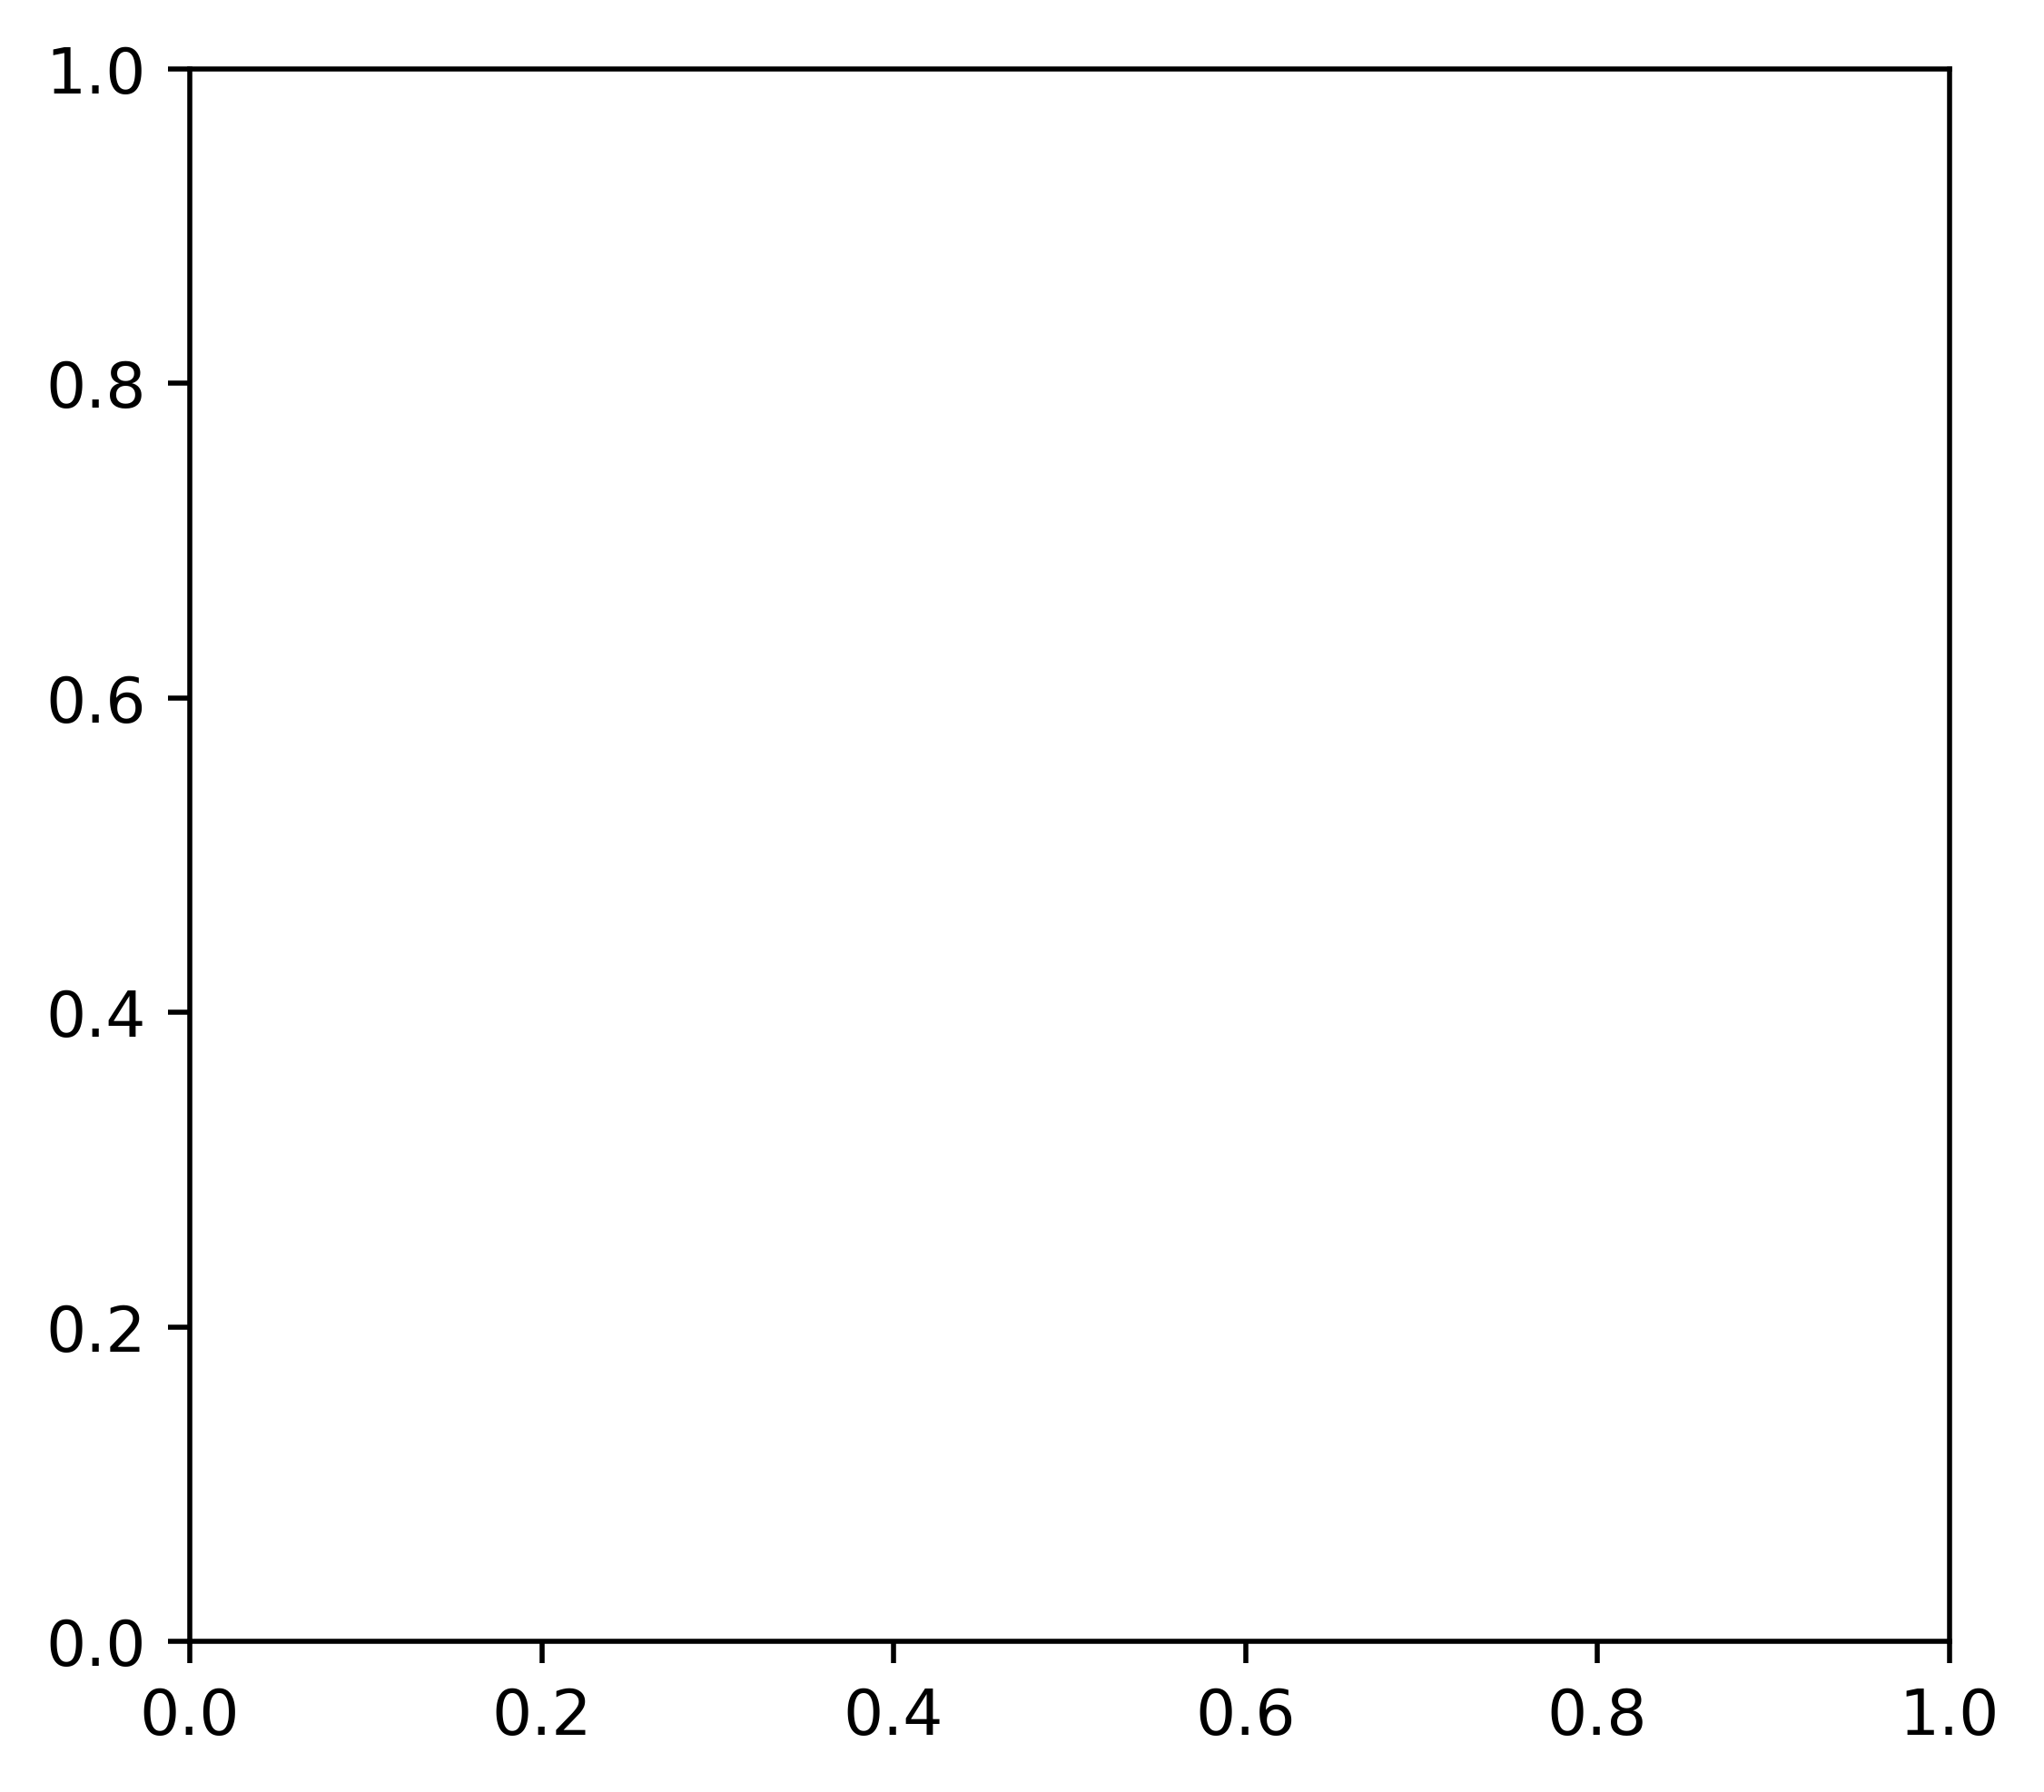

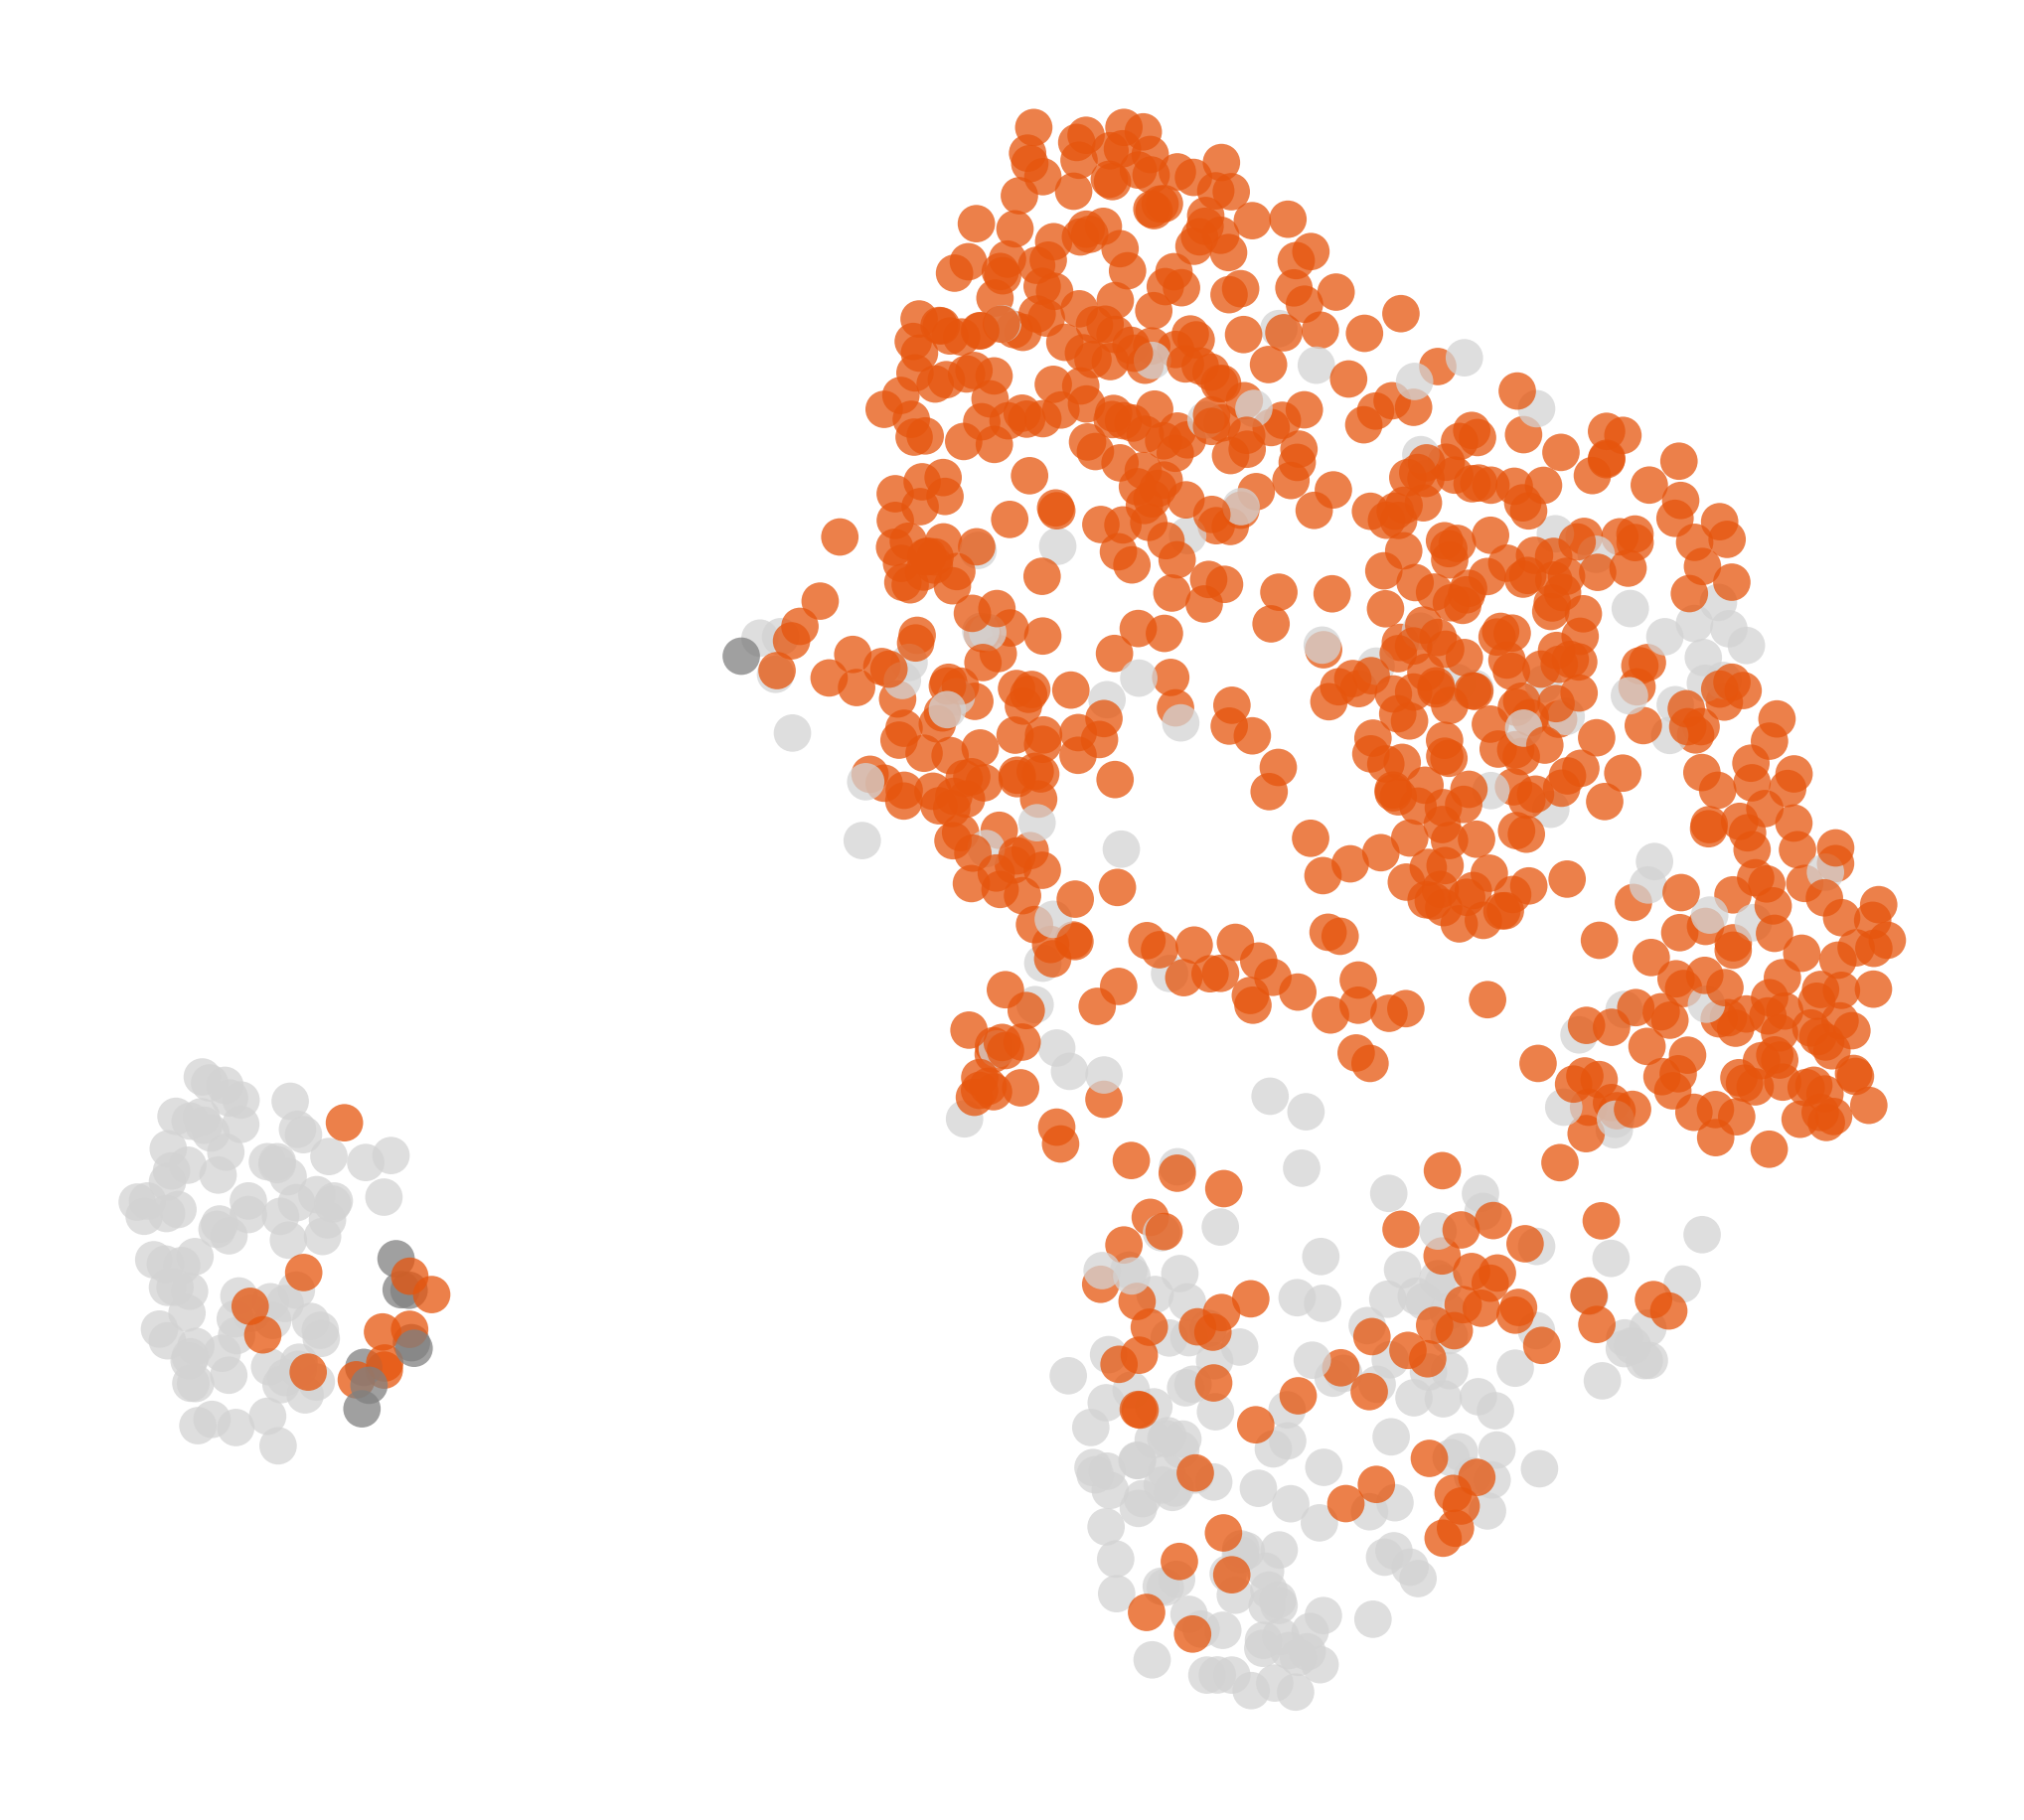

In [636]:
dict_CT1_to_CT2 = { 'Normal' : 'Normal', 'Tumor_0' : 'Tumor 1', 'Tumor_1' : 'Tumor 1', 'Tumor_2' : 'Tumor 2'}
adata_epi_tumor_SC035.obs['SComatic_CellType2'] = [ dict_CT1_to_CT2[CT1] for CT1 in adata_epi_tumor_SC035.obs['SComatic_CellType'] ]

palette_e = {'Normal' : 'dimgray', 
       #       'Tumor_0' : 'cornflowerblue', 
       #       'Tumor_1' : 'sandybrown', 
       #       'Tumor_2' : 'forestgreen', 
             'Tumor_0' : sns.color_palette('Paired')[1], 
             'Tumor_1' : sns.color_palette('Paired')[3], 
             'Tumor_2' : sns.color_palette('Paired')[5], 
             # REF_allele : sns.color_palette('tab20c')[0],
             REF_allele : 'gray',
             ALT_allele : sns.color_palette('tab20c')[4], 
                    'N/A' : 'lightgray',
                    }

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 4.5)},):
       sc.pl.umap(adata_epi_tumor_SC035, 
              color=['SNP_allele',],  #  SComatic_CellType2, 'SNP_allele', 'MSI_score'
              # s=25,
              cmap=sns.diverging_palette(220, 20, as_cmap=True),
              # palette=palette_e,
              legend_loc=None,
              colorbar_loc=None,
              alpha=0.75,
              title='',
              frameon=False,
              )

In [266]:
adata_SC035.obs['str_CB'] = [ idx.split('-')[0] for idx in adata_SC035.obs.index ]
adata_SC035.obs[['str_CB']].head(2)

str_CB
AAACCTGGTAGCACGA-1  AAACCTGGTAGCACGA
AAACCTGTCTACCTGC-1  AAACCTGTCTACCTGC

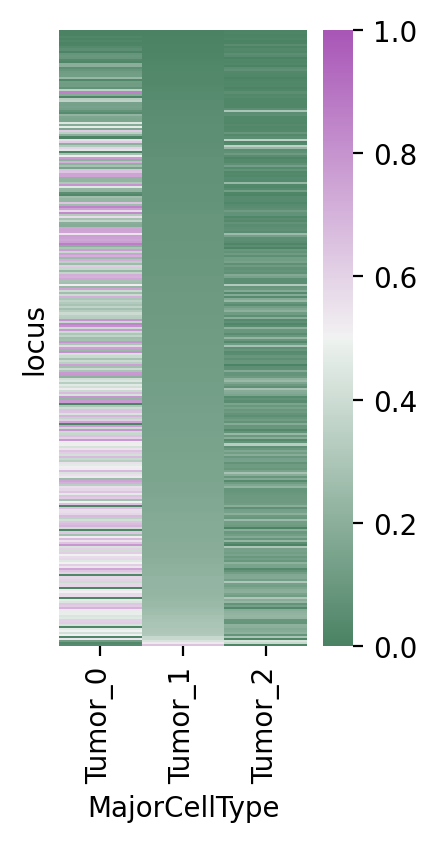

In [483]:
plt.figure(figsize=(2, 4), dpi=200)
# ax = sns.heatmap(SNP_SummaryByLocus.pivot(index='MajorCellType', columns='locus', values='proportion',).T.sort_values(['Normal', 'Tumor_0', 'Tumor_1', 'Tumor_2']), 
ax = sns.heatmap(SNP_SummaryByLocus[(SNP_SummaryByLocus['MajorCellType']!='Normal')].pivot(index='MajorCellType', columns='locus', values='proportion',).T.sort_values(['Tumor_1', 'Tumor_2', 'Tumor_0', ]), 
                 cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                 vmin=0, vmax=1, )
# ax = sns.heatmap(SNP_SummaryByLocus.pivot(index='MajorCellType', columns='locus', values='proportion',).T.sort_values(['Normal', 'Tumor']), 
#                  cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
#                  vmin=0, vmax=1, )

ax.set_yticklabels([]);
ax.set_yticks([]);

In [270]:
adata_SC035.obs[(adata_SC035.obs['str_CB']=='TGCTGCTCAGCTGCTG')][['Author_CellType_lvl_1',]]

Author_CellType_lvl_1
TGCTGCTCAGCTGCTG-1                  McDC

## MSI sensor

### Extract BAM from possorted.bam to run MSI sensor

In [697]:
DIR_BAM = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger'
PATH_EXT048_BAM = f'{DIR_BAM}/EXT048/outs/possorted_genome_bam.bam'
PATH_EXT049_BAM = f'{DIR_BAM}/EXT049/outs/possorted_genome_bam.bam'
PATH_EXT050_BAM = f'{DIR_BAM}/EXT050/outs/possorted_genome_bam.bam'
PATH_EXT051_BAM = f'{DIR_BAM}/EXT051/outs/possorted_genome_bam.bam'

#### Tumor BAMs

In [ ]:
dict_SampleID_to_CB_to_subleiden = { SampleID : { f"{tup.Index.split('-')[0]}-1" : tup.SComatic_CellType for tup in edf.itertuples() } for SampleID, edf in adata_epi_tumor_SC035.obs.groupby('SampleID', observed=True) } # adata_epi_tumor_SC035.obs

In [714]:
DIR_SAVE = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor'
for PATH_BAM in [ PATH_EXT048_BAM, PATH_EXT049_BAM,  ]:
    SampleID = PATH_BAM.split('/')[-3]
    print(SampleID, flush=True)
    
    bamfile = pysam.AlignmentFile( PATH_BAM, 'rb' )
    dict_Subleiden_to_newBamfile = dict()
    
    for read in bamfile.fetch():
        try:
            CB = read.get_tag('CB')
            try:
                Subleiden = dict_SampleID_to_CB_to_subleiden[SampleID][CB]
                try:
                    dict_Subleiden_to_newBamfile[Subleiden].write( read )
                except KeyError:
                    dict_Subleiden_to_newBamfile[Subleiden] = pysam.AlignmentFile( f'{DIR_SAVE}/{SampleID}.{Subleiden}.bam', 'wb', template=bamfile )
            except KeyError:
                continue
        except KeyError: 
            continue 

EXT048
EXT049


In [715]:
for s, b in dict_Subleiden_to_newBamfile.items():
    b.close()

#### Normal BAM

In [722]:
dict_SampleID_to_normalCell_CB = dict() 

# { SampleID : { f"{tup.Index.split('-')[0]}-1" : tup.SComatic_CellType for tup in edf.itertuples() } for SampleID, edf in adata_epi_tumor_SC035.obs.groupby('SampleID', observed=True) } # adata_epi_tumor_SC035.obs
for SampleID, edf in adata_SC035.obs[~adata_SC035.obs['Identifier'].isin(adata_epi_tumor_SC035.obs['Identifier'])].groupby('SampleID', observed=True):
    dict_SampleID_to_normalCell_CB[SampleID] = set( [ f"{idx.split('-')[0]}-1" for idx in edf.index ] )

In [723]:
DIR_SAVE = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor'

for PATH_BAM in [ PATH_EXT048_BAM, PATH_EXT049_BAM, PATH_EXT050_BAM, PATH_EXT051_BAM,  ]:
    SampleID = PATH_BAM.split('/')[-3]
    print(SampleID, flush=True)
    
    bamfile = pysam.AlignmentFile( PATH_BAM, 'rb' )
    newBamfile = pysam.AlignmentFile( f'{DIR_SAVE}/{SampleID}.normal.bam', 'wb', template=bamfile )
    for read in bamfile.fetch():
        try:
            CB = read.get_tag("CB")
            if CB in dict_SampleID_to_normalCell_CB[SampleID]:
                newBamfile.write( read )
            else: continue 
        except KeyError:
            continue 
    newBamfile.close()

EXT048
EXT049
EXT050
EXT051


In [ ]:
# /node200data/18parkky/programs/msisensor-pro/msisensor-pro-1.3.0/binary/msisensor-pro msi -d GRCh38_2020_A.list -n /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/Normal.merged.bam -t /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/Tumor_0.merged.bam -b 36 -x 1 -y 0

### Visualize results

In [3]:
MSI_sensor_Tumor_0 = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/msisensor_output/Tumor_0/test', sep='\t')
MSI_sensor_Tumor_1 = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/msisensor_output/Tumor_1/test', sep='\t')
MSI_sensor_Tumor_2 = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/msisensor_output/Tumor_2/test', sep='\t')

In [772]:
MSI_sensor_Tumor_0

Total_Number_of_Sites  Number_of_Unstable_Sites      %
0                   2608                       969  37.15

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

/tmp/ipykernel_192035/1611692558.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=MSI_intensity_by_subLeiden,


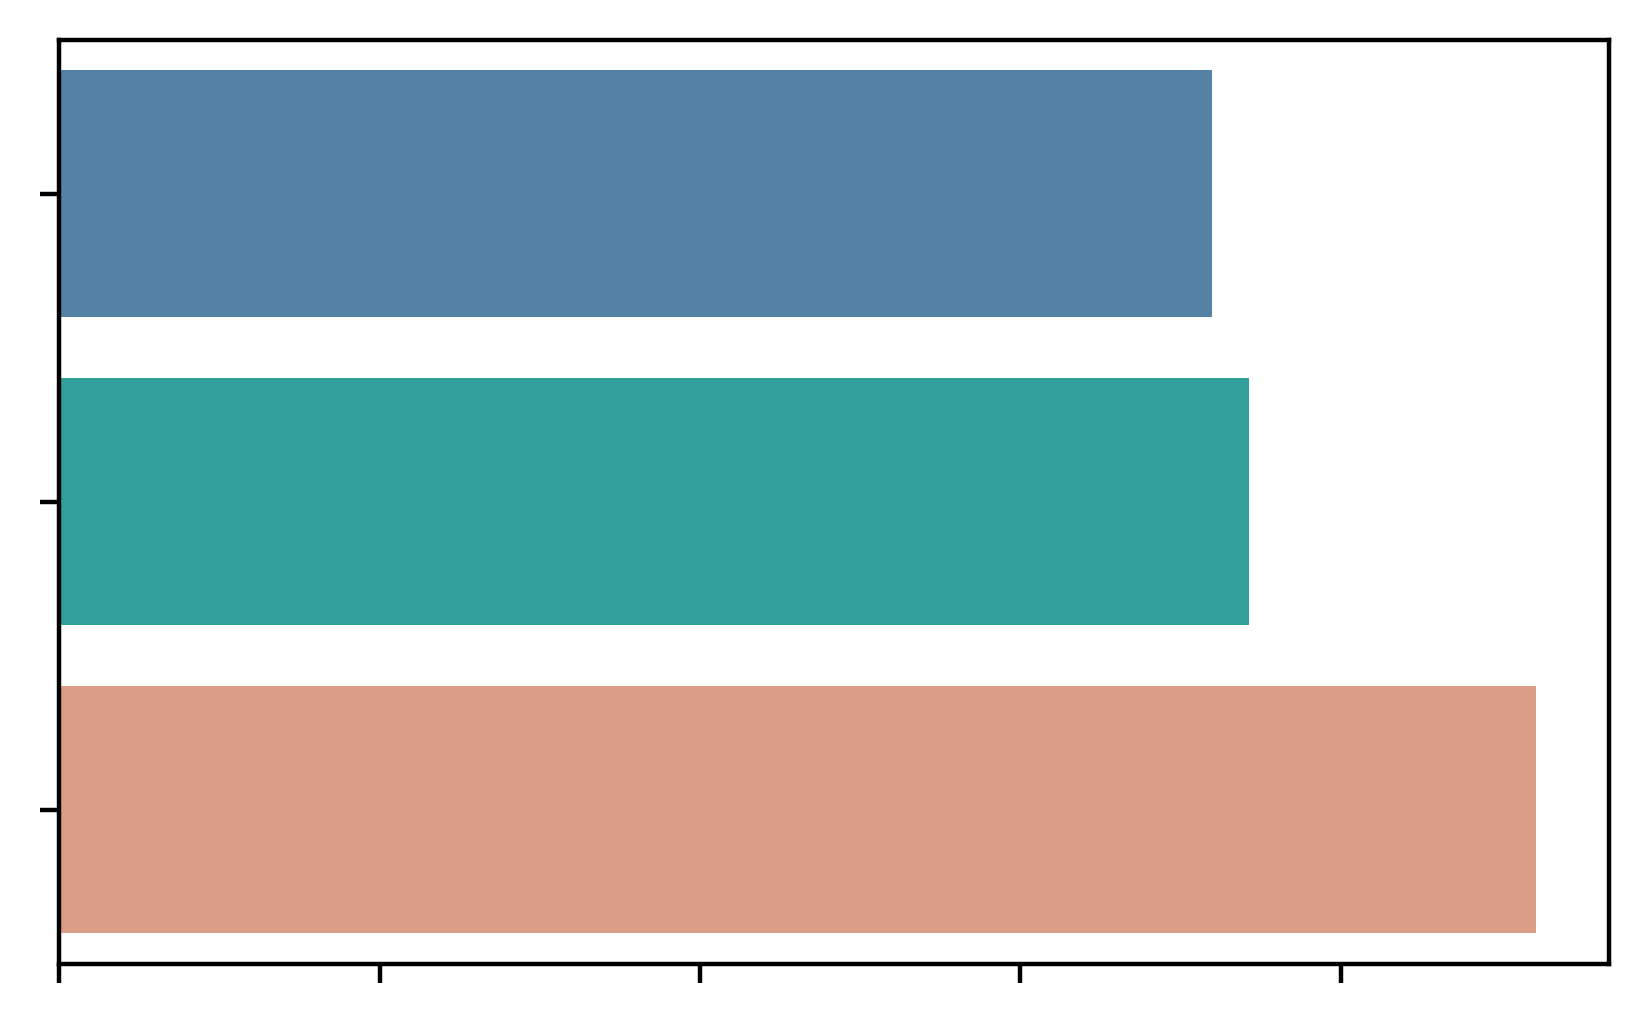

In [26]:
dict_TumorSubleiden_to_MSI_intensity = dict() 

for SComatic_CellType, edf in adata_epi_tumor_SC035.obs.groupby('SComatic_CellType', observed=True):
    dict_TumorSubleiden_to_MSI_intensity[SComatic_CellType] = [ np.mean(edf['MSI_score']) ]
    
dict_TumorSubleiden_to_MSI_intensity['Tumor_0'].append( float(MSI_sensor_Tumor_0['%'].iloc[0]) )
dict_TumorSubleiden_to_MSI_intensity['Tumor_1'].append( float(MSI_sensor_Tumor_1['%'].iloc[0]) )
dict_TumorSubleiden_to_MSI_intensity['Tumor_2'].append( float(MSI_sensor_Tumor_2['%'].iloc[0]) )

MSI_intensity_by_subLeiden = pd.DataFrame.from_dict(dict_TumorSubleiden_to_MSI_intensity, orient='index')
MSI_intensity_by_subLeiden.reset_index(inplace=True)
MSI_intensity_by_subLeiden.columns = ['Subleiden', 'MSI_score', 'MSI_sensor_score']

plt.figure(figsize=(5, 3), dpi=400)
ax = sns.barplot(data=MSI_intensity_by_subLeiden, 
                     y='Subleiden', 
                     x='MSI_sensor_score', 
                     order=['Tumor_1', 'Tumor_0', 'Tumor_2'],
                    #  palette=[sns.color_palette('Paired',)[7], sns.color_palette('Paired',)[1], sns.color_palette('Paired',)[3]],
                     palette=['steelblue', 'lightseagreen', 'darksalmon'],
                     # hue='Subleiden', 
                     # legend=None,
                     # s=200,
                     )
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.show()

In [ ]:
plt.figure(figsize=(2, 4), dpi=500)
ax = sns.barplot(data=adata_SC035.obs, x='SComatic_CellType', y='MSI_score', 
                 hue='SComatic_CellType',
                 palette={'Normal' : 'gray', 
                        'Tumor_0' : sns.color_palette('Paired')[1], 
                        'Tumor_1' : sns.color_palette('Paired')[7], 
                        'Tumor_2' : sns.color_palette('Paired')[3]
                        },
                 order=['Normal', 'Tumor_1', 'Tumor_0', 'Tumor_2']
                 )
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_xlabel('');
ax.set_ylabel('');
plt.show()

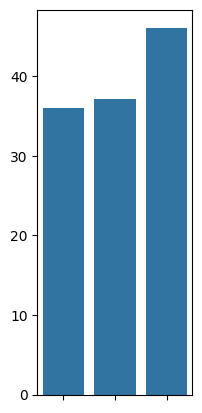

In [750]:
plt.figure(figsize=(2, 5))
f = sns.barplot(x=['1', '0', '2'], 
                y=[float(MSI_sensor_Tumor_1['%'].iloc[0]),
                   float(MSI_sensor_Tumor_0['%'].iloc[0]), 
                   float(MSI_sensor_Tumor_2['%'].iloc[0])], )
f.set_xticklabels([]);
plt.show()
# f.set_yticklabels([]);
# f.tick_params(left=False, bottom=False)

In [744]:
pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/msisensor_output/test_dis', sep=' ')

chr1  \
N:         0     0     0     0     0.0   0.0   0.0   0.0     2.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   
T:         0     0     0     0     0.0   0.0   0.0   0.0     2.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   
chr1       28588 GGTGG 15[T] GCATC NaN   NaN   NaN   NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN   
N:         0     0     0     0     0.0   0.0   0.0   0.0     0.0     0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   
T:         0     0     0     0     0.0   0.0   0.0   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ...   
N:         0     0     0     0     0.0   0.0   0.0   0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   
T:         0     0     0     0     0.0   0.0   0.0   0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   
KI270448.1 7788  GAGCT 8[A]  TCATA NaN   NaN   NaN   NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  Na

In [745]:
#! Homopolymer only (-x 1) paramter was used 
sub1_leiden_0_msisensor_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/depr/leiden0', sep='\t')
sub1_leiden_1_msisensor_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_2_SC035_MSIsensor/depr/leiden1', sep='\t')
sub1_leiden_1_msisensor_res

Total_Number_of_Sites  Number_of_Somatic_Sites     %
0                    150                       99  66.0

/tmp/ipykernel_86576/207109601.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  f = sns.barplot(x=['0', '1'], y=[float(sub1_leiden_0_msisensor_res['%'].iloc[0]), float(sub1_leiden_1_msisensor_res['%'].iloc[0])], palette=dict_sub1_leiden_palette)


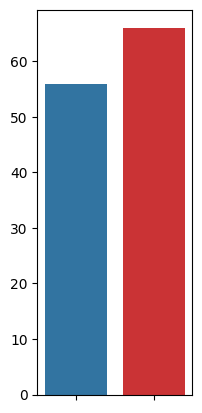

In [657]:
plt.figure(figsize=(2, 5))
f = sns.barplot(x=['0', '1'], y=[float(sub1_leiden_0_msisensor_res['%'].iloc[0]), float(sub1_leiden_1_msisensor_res['%'].iloc[0])], palette=dict_sub1_leiden_palette)
f.set_xticklabels([]);
# f.set_yticklabels([]);
# f.tick_params(left=False, bottom=False)

In [723]:
u, s = np.mean(adata.obs[adata.obs['PatientID']=='SC035']['AvgSTRDiff']), np.std(adata.obs[adata.obs['PatientID']=='SC035']['AvgSTRDiff'])
adata_epi_tumor_SC035.obs['Scaled_AvgSTRDiff'] = [ (ASD-u)/s for ASD in adata_epi_tumor_SC035.obs['AvgSTRDiff'] ]

In [1011]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

<Axes: xlabel='sub1_leiden', ylabel='MSI_score'>

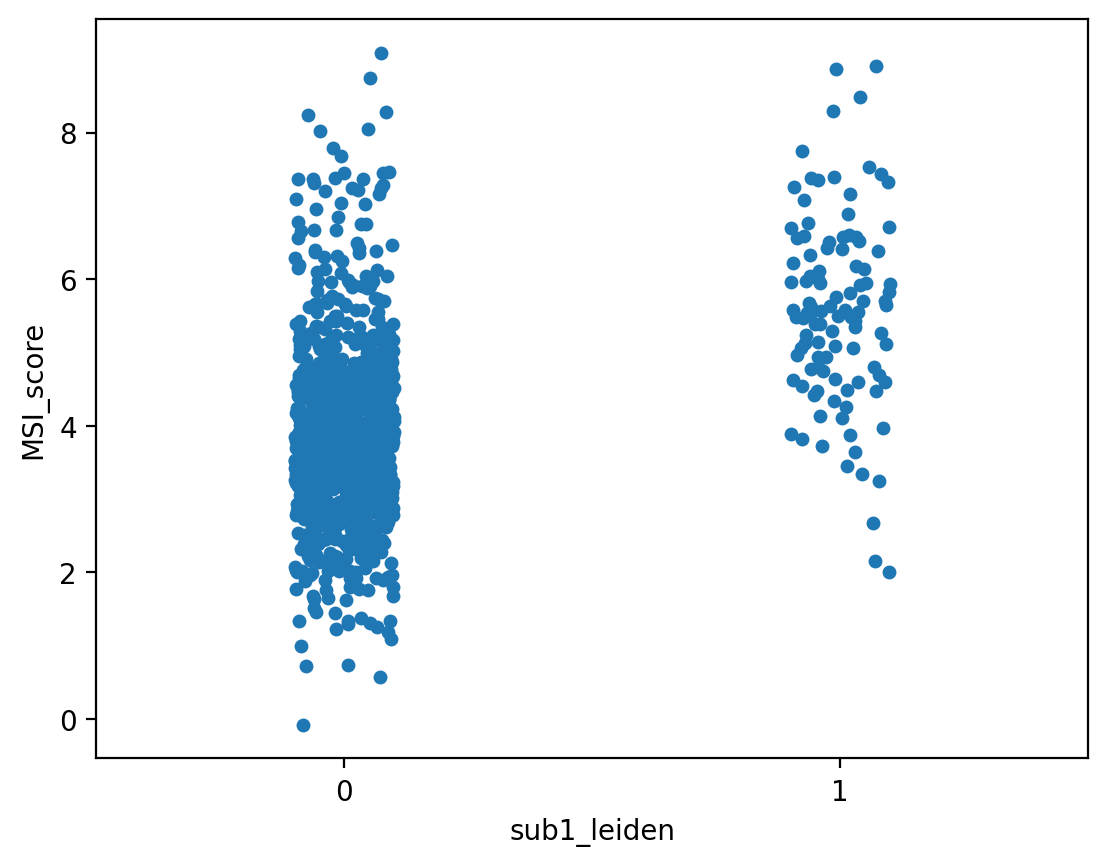

In [255]:
sns.stripplot(data=adata_epi_tumor_SC035.obs, x='sub1_leiden', y='MSI_score')

In [261]:
adata_epi_tumor_SC035.obs.sort_values('MSI_score')[['AvgSTRDiff', 'StdSTRDiff', 'MSI_score']]

AvgSTRDiff  StdSTRDiff  MSI_score
GGGATGATCGCGTTTC-1      0.200000    0.400000  -0.080000
CCTAGCTTCAGCTTAG-1     -0.071429    8.039761   0.574269
TGCTGCTCAATTGCTG-1     -0.417910    1.737637   0.726176
AAGGAGCTCTCCAACC-1     -0.527273    1.386356   0.730988
ATCCGAATCTGAGTGT-1     -0.687500    1.445629   0.993870
...                          ...         ...        ...
CGTGTAAGTCGCTTTC-1     -2.585859    3.284522   8.493309
GATCGCGGTCCCTTGT-1-1   -1.698113    5.149042   8.743657
CAGGTGCCAGGTCGTC-1     -2.512195    3.531199   8.871060
TTCCCAGTCTGCGACG-1     -2.504762    3.556681   8.908638
AGCGTCGCAAGGGTCA-1     -2.900000    3.134220   9.089237

[1019 rows x 3 columns]

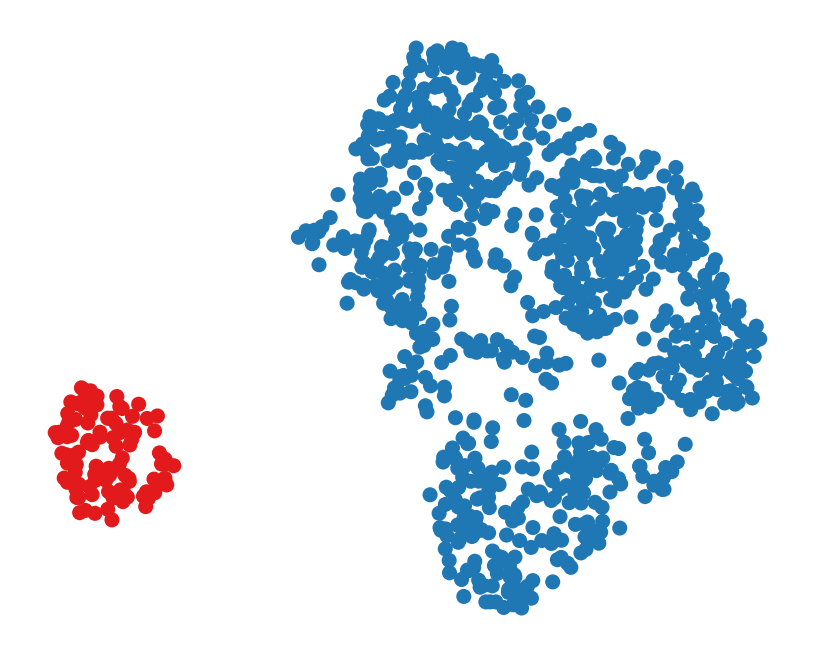

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


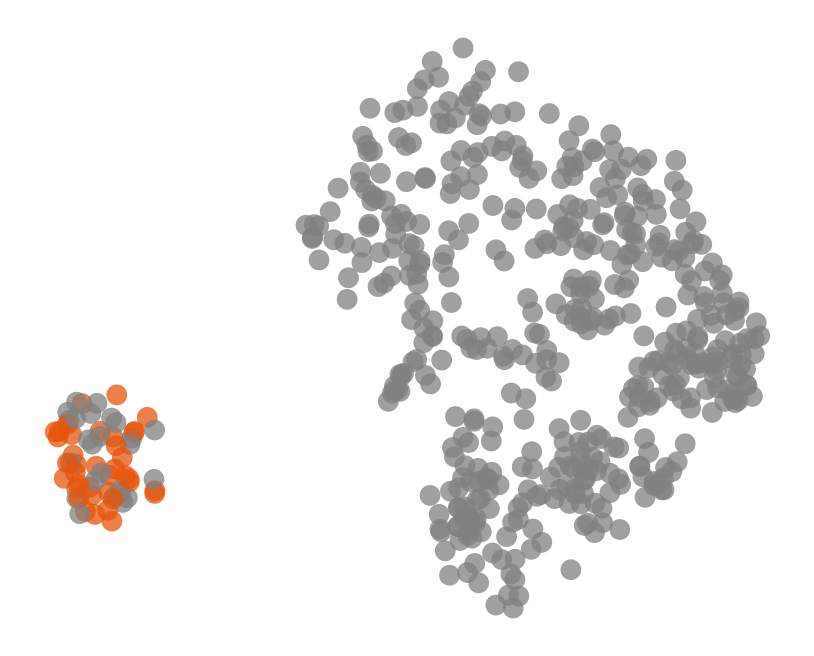

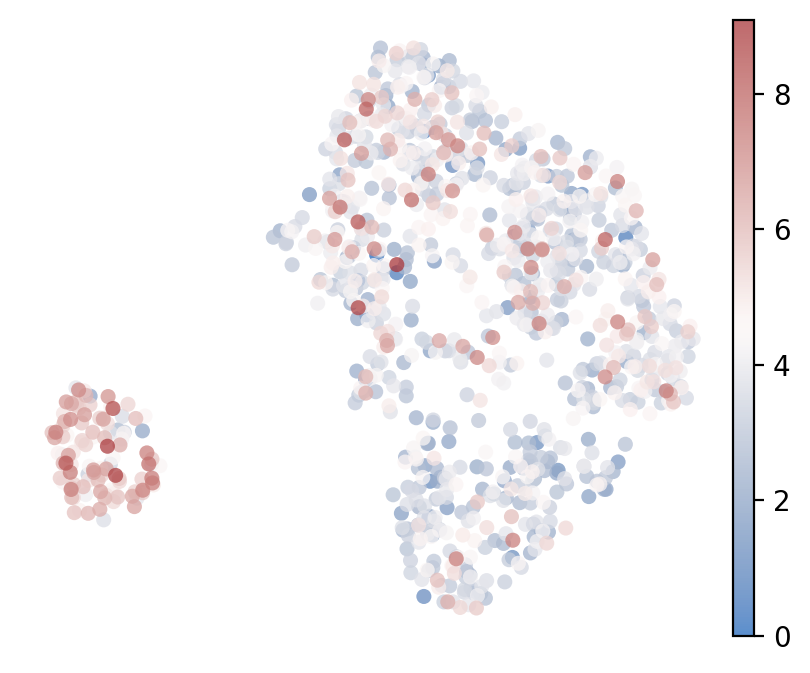

In [268]:
with plt.rc_context({'figure.figsize': (5, 4), }):
    sc.pl.umap(adata_epi_tumor_SC035, color=['sub1_leiden'], palette=dict_sub1_leiden_palette, frameon=False, title='', legend_loc=None,)
    sc.pl.umap(adata_epi_tumor_SC035[adata_epi_tumor_SC035.obs['ObservedAllele']!='N/A'], 
               color=['ObservedAllele'], palette={ 'A' : 'gray', 'G' : sns.color_palette('tab20c')[4], 'N/A' : 'gray' }, alpha=0.75, frameon=False, title='', legend_loc=None,)
    sc.pl.umap(adata_epi_tumor_SC035, vmin=0, color=['MSI_score'], cmap='vlag', alpha=0.75, frameon=False, title='',
            #    colorbar_loc=None,
               )

### Validate crude MSI intensity intensity using loci with higher coverage

In [226]:
dict_locus_to_totalCoverage = dict()
for locus, edf in AlleleTable.groupby('locus'):
    dict_locus_to_totalCoverage[locus] = len(edf)

In [229]:
mininumCoverage = 30
set_highlyCoveredLoci = set(locus for locus, coverage in dict_locus_to_totalCoverage.items() if coverage>=mininumCoverage)
len(set_highlyCoveredLoci)

22700

In [231]:
STRLocusAndCoverage = list()
for PatientID, edf in AlleleTable[(AlleleTable['locus'].isin(set_highlyCoveredLoci))].groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        for locus, edf3 in edf2.groupby("locus"):
            STRLocusAndCoverage.append( [PatientID, locus, isTumor, np.mean(edf3['diff'].dropna()), len(edf3.dropna()), ] )
STRLocusAndCoverage = pd.DataFrame(STRLocusAndCoverage, columns=['PatientID', 'locus', 'isTumor', 'AvgSTRDiff', 'Coverage'])

#### MSI

In [260]:
STRLocusAndCoverage_highCov = STRLocusAndCoverage[(STRLocusAndCoverage['Coverage']>=mininumCoverage) & 
                                                  (STRLocusAndCoverage['PatientID'].isin(['SC044', 'SC035', 'CRC2783', 'CRC2817'])) & 
                                                  (STRLocusAndCoverage['isTumor']!='N/A')].copy()

temp_set = set()
for locus, edf in STRLocusAndCoverage_highCov.groupby('locus'):
    if len(edf) >= 8:
        temp_set.add(locus)
STRLocusAndCoverage_highCov = STRLocusAndCoverage_highCov[STRLocusAndCoverage_highCov['locus'].isin(temp_set)].copy()
STRLocusAndCoverage_highCov['reference_STR_allele'] = [ int(locus.split(':')[1].split('-')[1])-int(locus.split(':')[1].split('-')[0])+1 for locus in STRLocusAndCoverage_highCov['locus'] ]
STRLocusAndCoverage_highCov.sort_values(['reference_STR_allele', 'locus'], inplace=True)

locus_order = list()
for locus in STRLocusAndCoverage_highCov['locus']:
    if locus in locus_order:
        pass 
    else:
        locus_order.append(locus)

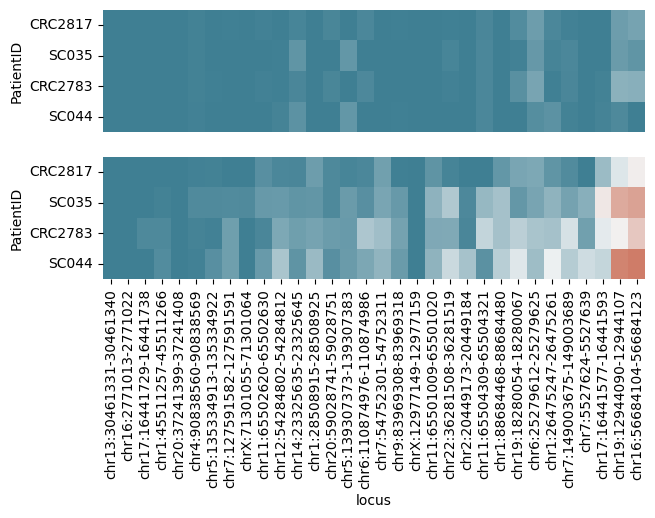

In [276]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(7, 3.5), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

vmin_e, vmax_e = -8, 0

ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==False)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==True)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )


#### MSS

In [280]:
STRLocusAndCoverage_highCov = STRLocusAndCoverage[(STRLocusAndCoverage['Coverage']>=mininumCoverage) & 
                                                  ~(STRLocusAndCoverage['PatientID'].isin(['SC044', 'SC035', 'CRC2783', 'CRC2817'])) & 
                                                  (STRLocusAndCoverage['isTumor']!='N/A')].copy()

temp_set = set()
for locus, edf in STRLocusAndCoverage_highCov.groupby('locus'):
    if len(edf) >= 12:
        temp_set.add(locus)
STRLocusAndCoverage_highCov = STRLocusAndCoverage_highCov[STRLocusAndCoverage_highCov['locus'].isin(temp_set)].copy()
STRLocusAndCoverage_highCov['reference_STR_allele'] = [ int(locus.split(':')[1].split('-')[1])-int(locus.split(':')[1].split('-')[0])+1 for locus in STRLocusAndCoverage_highCov['locus'] ]
STRLocusAndCoverage_highCov.sort_values(['reference_STR_allele', 'locus'], inplace=True)

locus_order = list()
for locus in STRLocusAndCoverage_highCov['locus']:
    if locus in locus_order:
        pass 
    else:
        locus_order.append(locus)
STRLocusAndCoverage_highCov.shape[0]/12

8.0

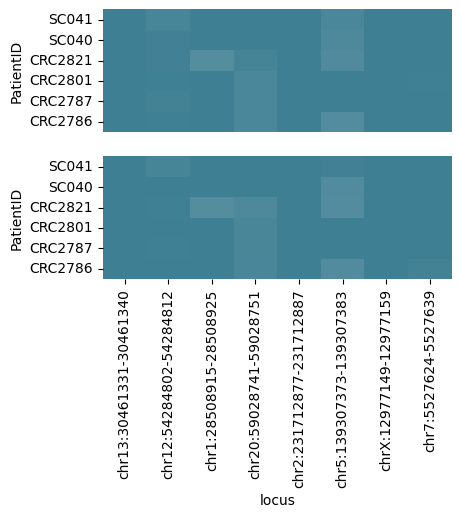

In [283]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(4.5, 3.5), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', ]

vmin_e, vmax_e = -8, 0

ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==False)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==True)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )


#### KDE visualizations - Depr?

In [8]:
# All patients 
fig, axes = plt.subplots(10, 1, figsize=( 8, 7.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 5
bw_adjust_e = 0.5

for idx, patient in enumerate(['CRC2787', 'CRC2801', 'CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial') & 
                        (adata.obs['Manual_CellType_lvl_1']!='Tumor epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

CRC2787	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


CRC2801	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


CRC2786	nan
CRC2821	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


SC040	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


SC041	nan
CRC2817	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


CRC2783	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


SC035	nan
SC044	nan


/tmp/ipykernel_273827/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


In [10]:
for PatientID, edf in adata.obs.groupby('PatientID'):
    print(PatientID, edf.iloc[0].MSI)

CRC2783 MSI-H
CRC2786 MSS
CRC2787 MSS
CRC2801 MSS
CRC2817 MSI-H
CRC2821 MSS
SC035 MSI-H
SC040 MSS
SC041 MSS
SC044 MSI-H


/tmp/ipykernel_273827/372022615.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata.obs.groupby('PatientID'):


##### 4 MSI patients

In [18]:
fig, axes = plt.subplots(4, 1, figsize=( 9, 3 ), dpi=400, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['CRC2817', 'SC035', 'CRC2783', 'SC044']):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1", observed=False):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

CRC2817	-0.55
SC035	-1.54
CRC2783	-1.63
SC044	-2.52


##### 6 MSS patients

SC041	0.08
SC040	0.06
CRC2821	-0.04
CRC2801	-0.06
CRC2787	-0.07
CRC2786	-0.09


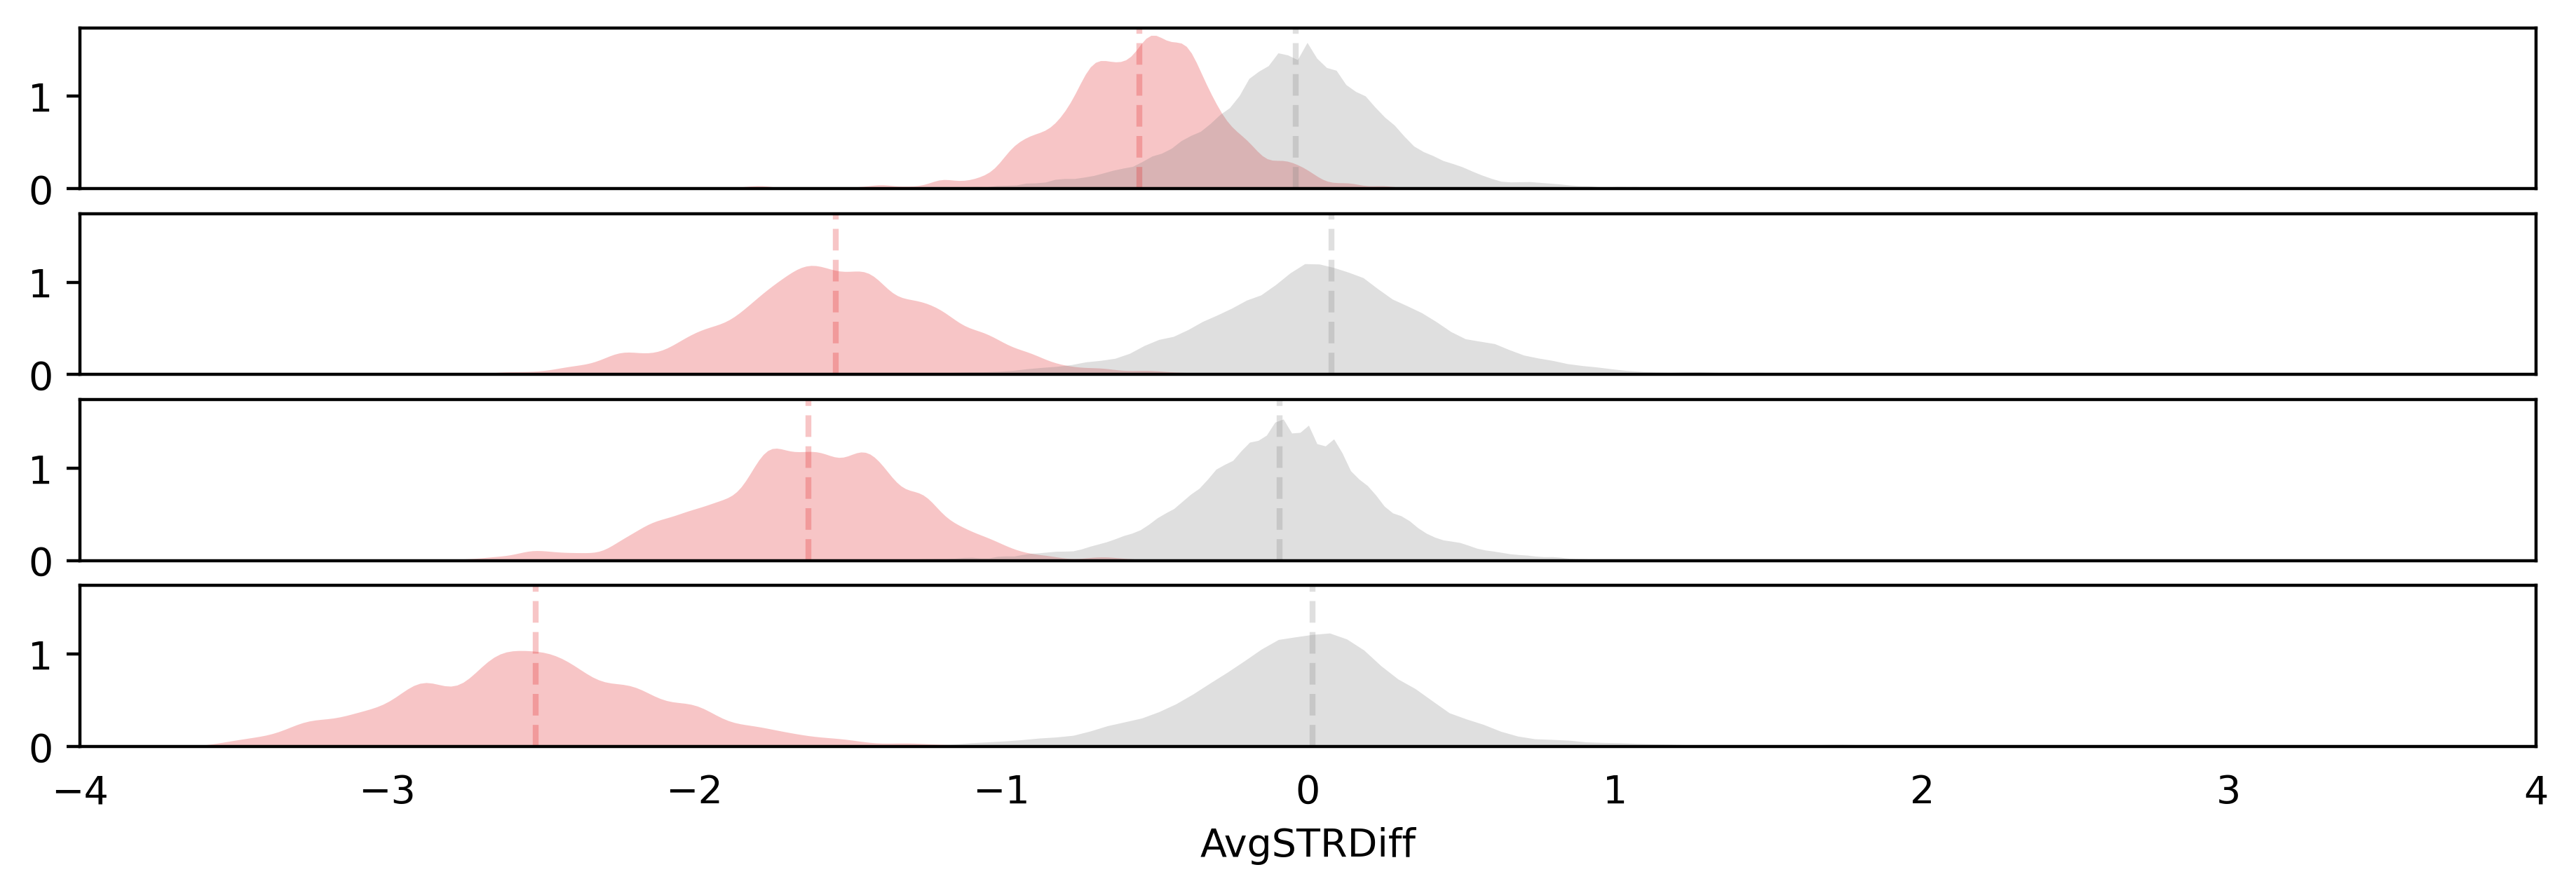

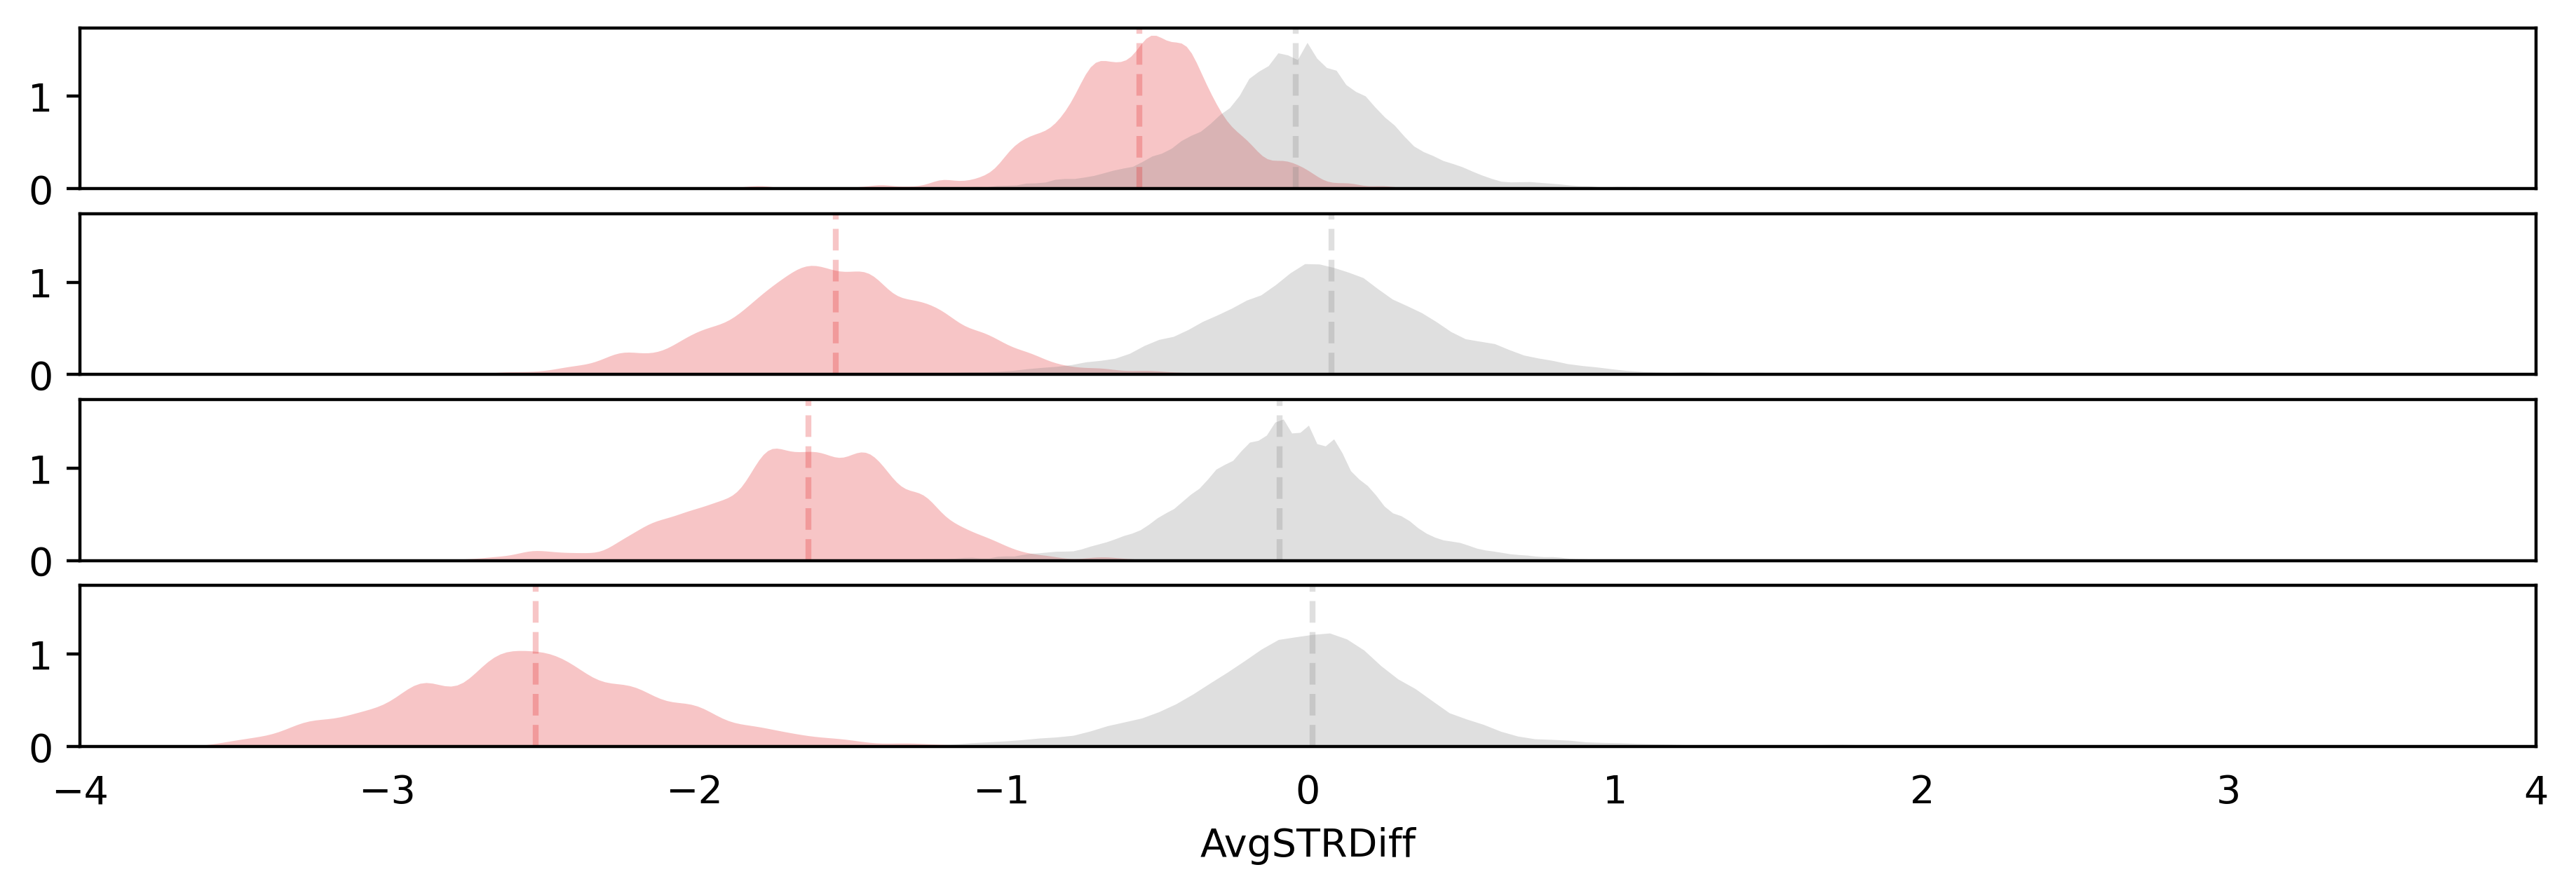

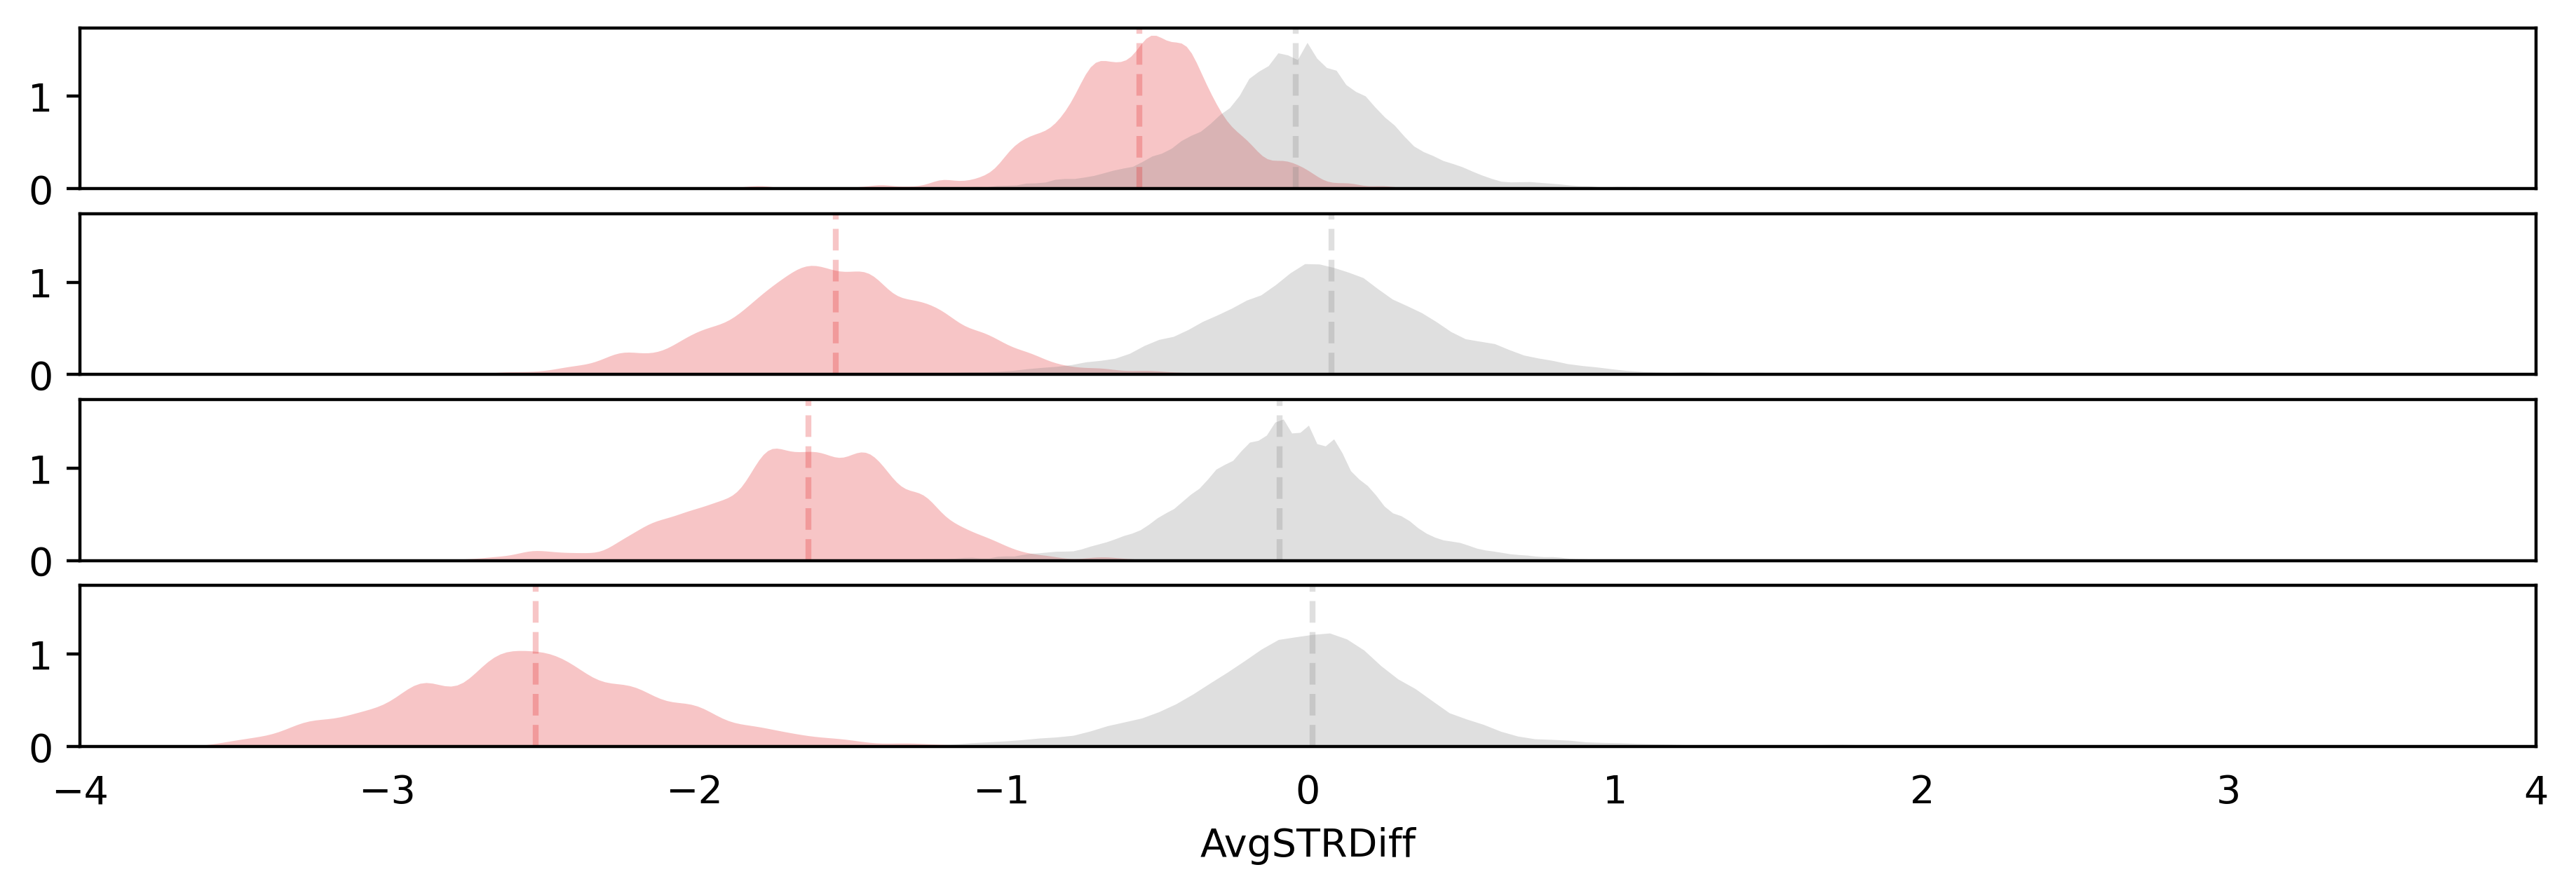

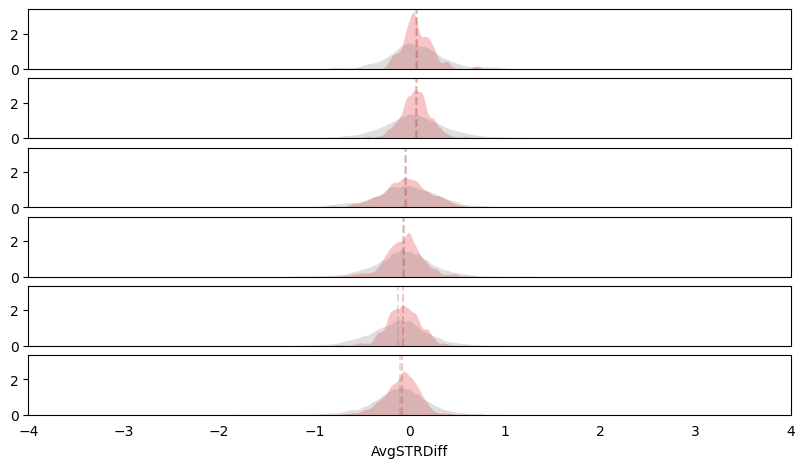

In [19]:
# All patients 
fig, axes = plt.subplots(6, 1, figsize=( 8, 4.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', ]):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1", observed=False):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);
plt.show()

##### All patients

SC041	0.08
SC040	0.06
CRC2821	-0.04
CRC2801	-0.06
CRC2787	-0.07
CRC2786	-0.09
CRC2817	-0.55
SC035	-1.54
CRC2783	-1.63
SC044	-2.52


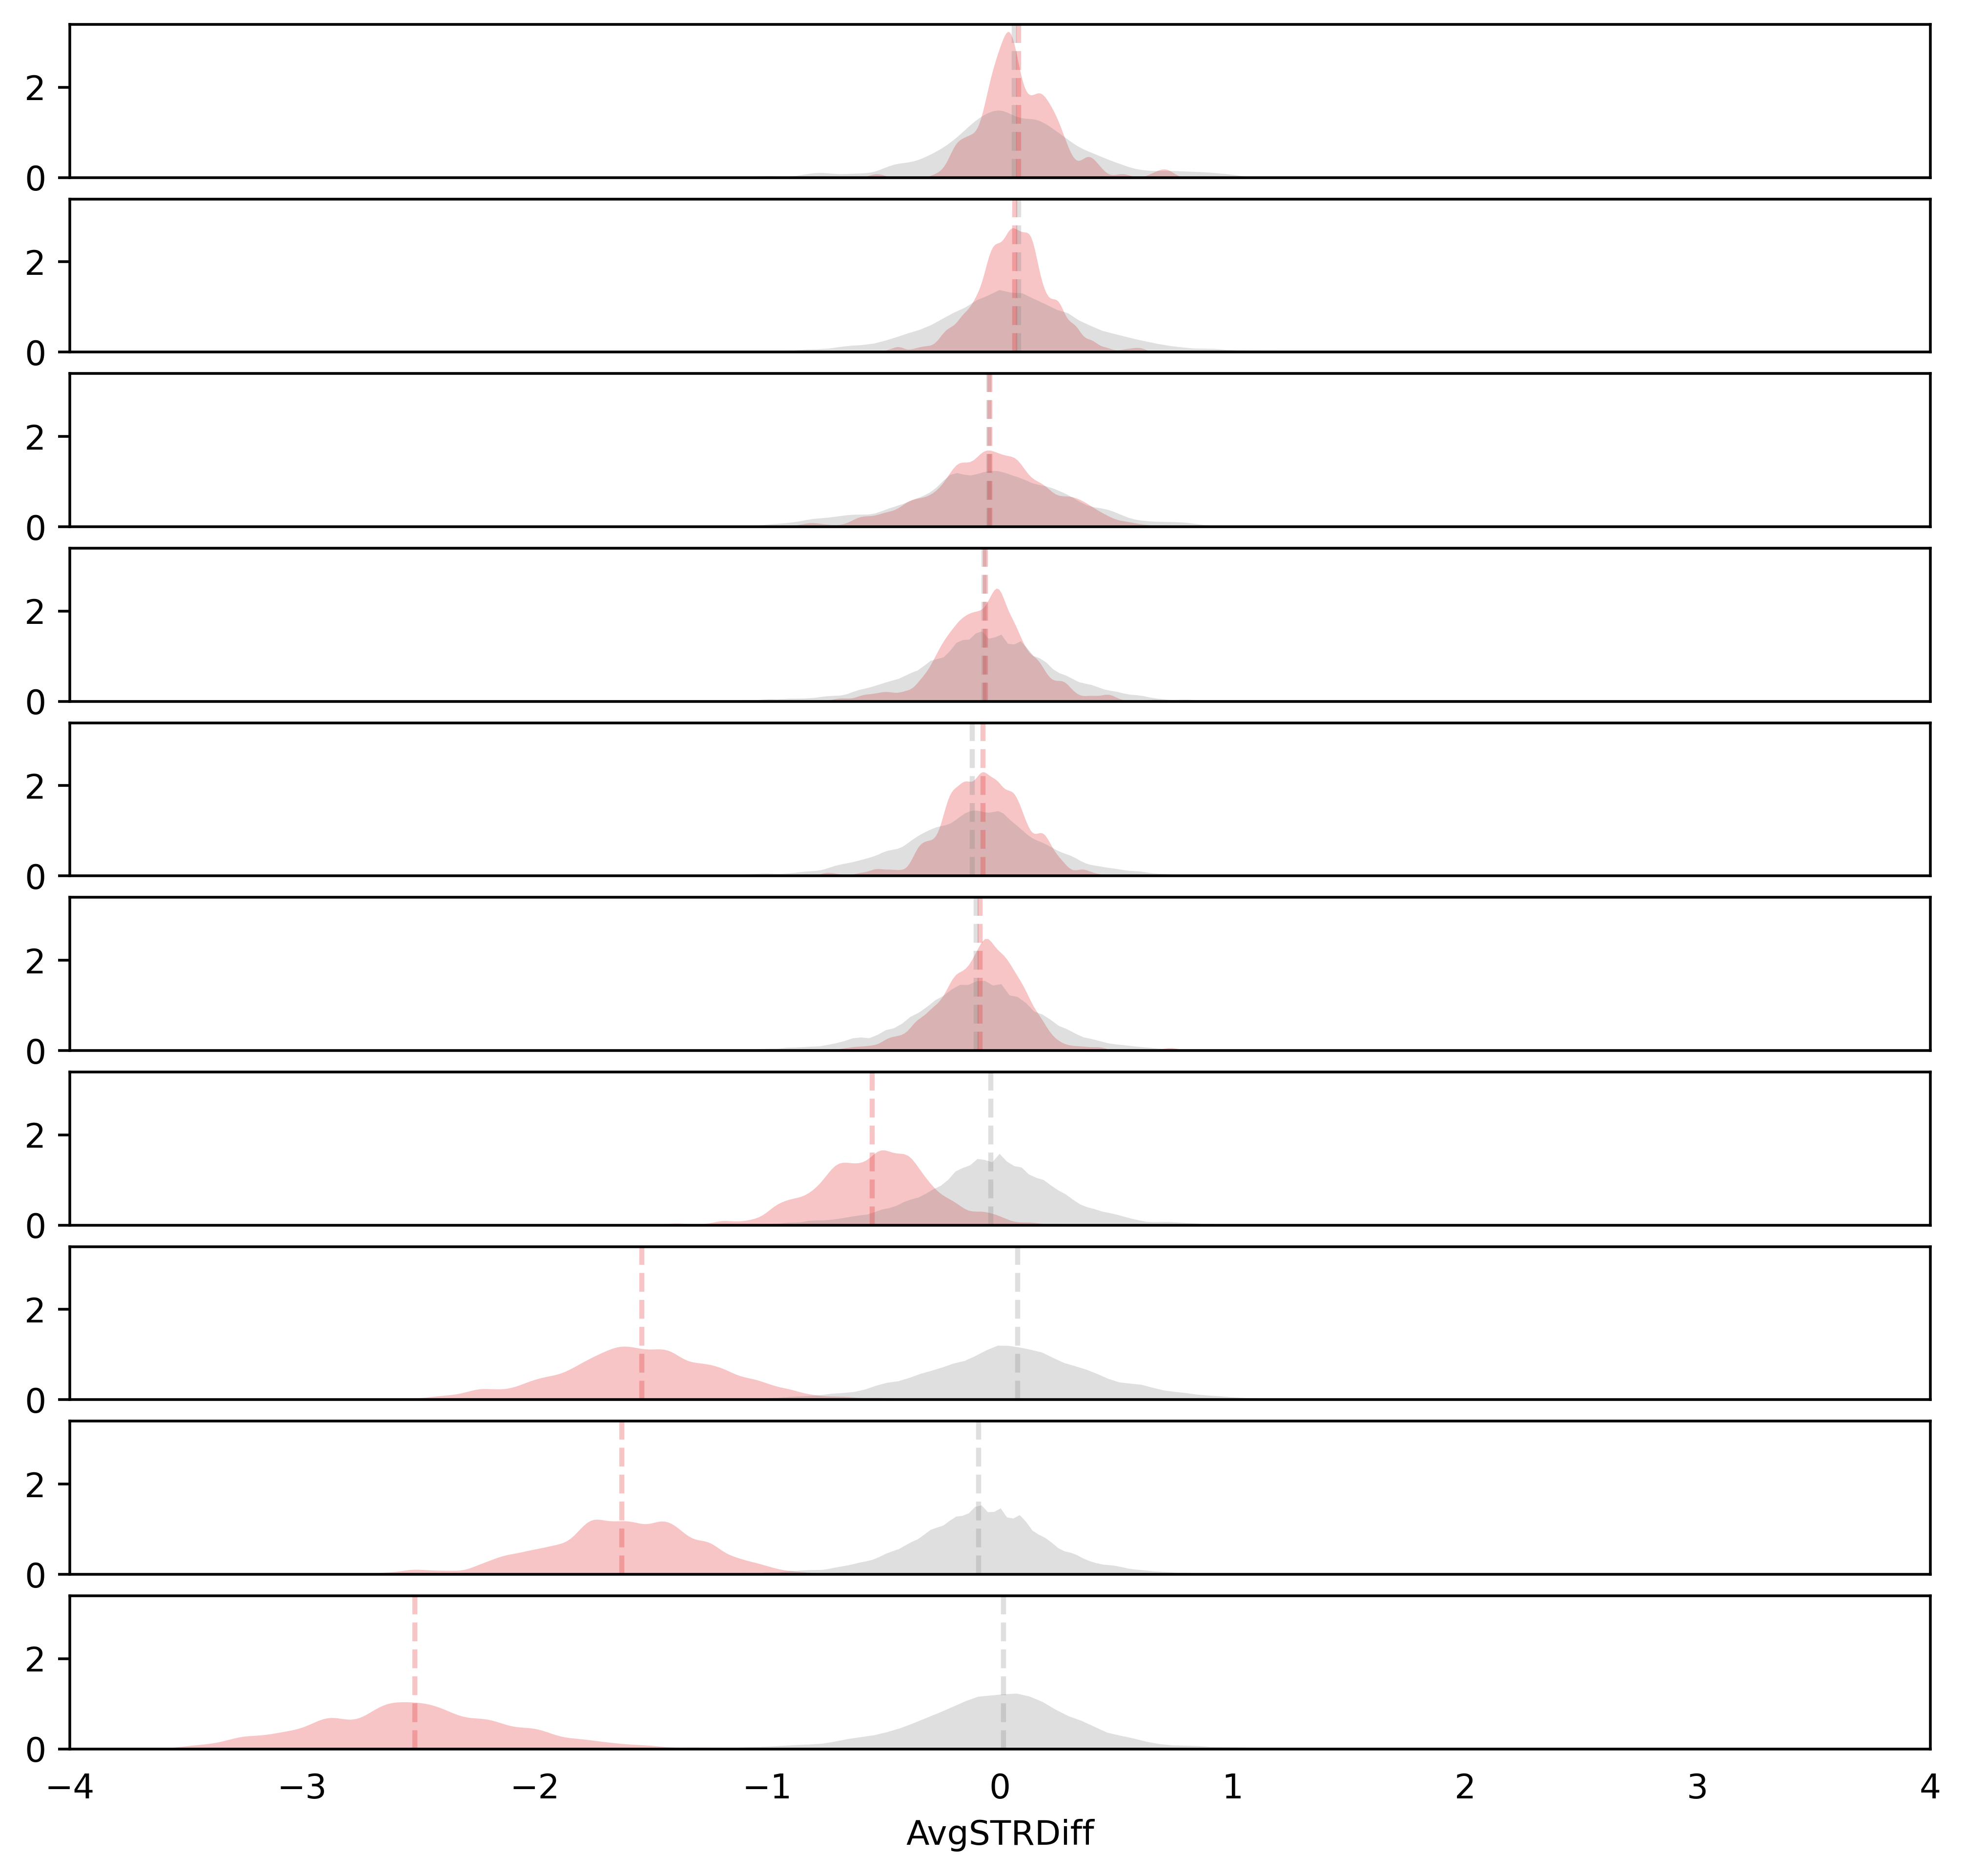

In [21]:
# All patients 
fig, axes = plt.subplots(10, 1, figsize=( 8, 7.5 ), dpi=500, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', 'CRC2817', 'SC035', 'CRC2783', 'SC044']):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1", observed=False):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);
plt.show()

### Inspect DEGs between MSI-H cells and MSI-L cells (intratumoral) 

In [498]:
adata_epi = adata[adata.obs['Manual_CellType_lvl_1'].isin(['Normal epithelial', 'Tumor epithelial'])].copy()
adata_epi = adata_epi.raw.to_adata()

adata_epi_tumor = adata_epi[(adata_epi.obs['Manual_CellType_lvl_1'].isin(['Tumor epithelial'])) & (adata_epi.obs['MSI'].isin(['MSI-H']))].copy()

onlySingleCellSample = list()
for SampleID, edf in adata_epi_tumor.obs.groupby("SampleID"):
    if len(edf) <= 1:
        print(SampleID)
        onlySingleCellSample.append(SampleID)
adata_epi_tumor = adata_epi_tumor[~(adata_epi_tumor.obs['SampleID'].isin(onlySingleCellSample))].copy()

sc.pp.normalize_total(adata_epi_tumor)
sc.pp.log1p(adata_epi_tumor)
sc.pp.highly_variable_genes(adata_epi_tumor, n_top_genes=2000, batch_key="SampleID")

adata_epi_tumor.raw = adata_epi_tumor.copy()
adata_epi_tumor = adata_epi_tumor[:, adata_epi_tumor.var.highly_variable]

sc.pp.scale(adata_epi_tumor, max_value=10)
sc.tl.pca(adata_epi_tumor, svd_solver="arpack")

sc.pp.neighbors(adata_epi_tumor, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_tumor, random_state=42)

AnnData object with n_obs × n_vars = 3490 × 2000
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Manual_CellType_lvl_1'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Author_CellType_lvl_1_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'PatientID_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### CRC2817

In [501]:
adata_epi_tumor_CRC2817 = adata_epi_tumor[adata_epi_tumor.obs['PatientID']=='CRC2817'].copy()
adata_epi_tumor_CRC2817 = adata_epi_tumor_CRC2817.raw.to_adata()

sc.pp.normalize_total(adata_epi_tumor_CRC2817)
sc.pp.log1p(adata_epi_tumor_CRC2817)
sc.pp.highly_variable_genes(adata_epi_tumor_CRC2817, n_top_genes=2000, batch_key="SampleID")

adata_epi_tumor_CRC2817.raw = adata_epi_tumor_CRC2817.copy()
adata_epi_tumor_CRC2817 = adata_epi_tumor_CRC2817[:, adata_epi_tumor_CRC2817.var.highly_variable]

sc.pp.scale(adata_epi_tumor_CRC2817, max_value=10)
sc.tl.pca(adata_epi_tumor_CRC2817, svd_solver="arpack")

sc.pp.neighbors(adata_epi_tumor_CRC2817, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_tumor_CRC2817, random_state=42)

sc.tl.leiden(adata_epi_tumor_CRC2817, resolution=0.2, key_added='sub1_leiden')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


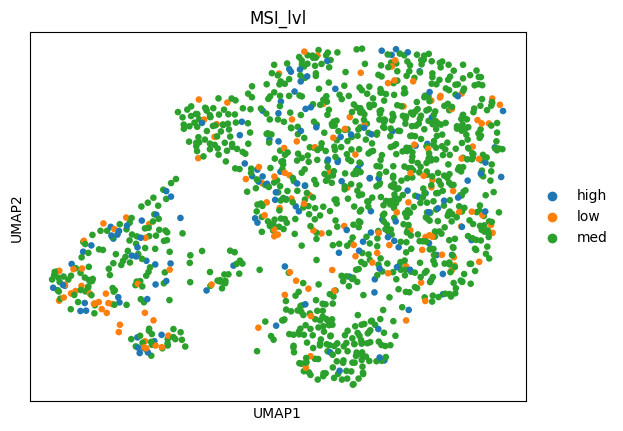

<Axes: xlabel='Scaled_AvgSTRDiff', ylabel='Density'>

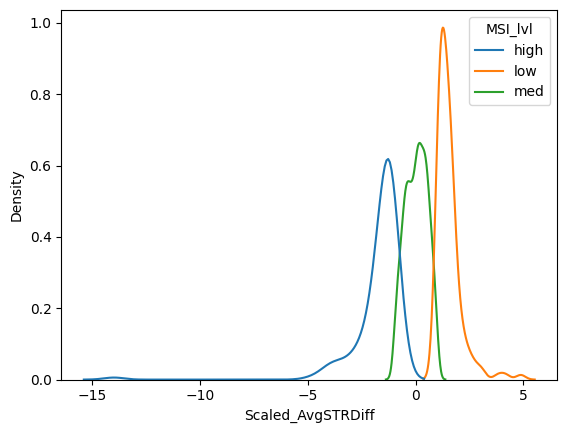

In [517]:
u, s = np.mean(adata_epi_tumor_CRC2817.obs['AvgSTRDiff']), np.std(adata_epi_tumor_CRC2817.obs['AvgSTRDiff'])
adata_epi_tumor_CRC2817.obs['Scaled_AvgSTRDiff'] = [ (AvgSTRDiff-u)/s for AvgSTRDiff in adata_epi_tumor_CRC2817.obs['AvgSTRDiff'] ]

col_MSI_lvl = list()
z_score_threshold = 1
for tup in adata_epi_tumor_CRC2817.obs.itertuples():
    if tup.Scaled_AvgSTRDiff >= z_score_threshold:
        col_MSI_lvl.append('low') # MSI-L
    elif tup.Scaled_AvgSTRDiff <= -z_score_threshold:
        col_MSI_lvl.append('high') # MSI-H
    else:
        col_MSI_lvl.append('med')
        
adata_epi_tumor_CRC2817.obs['MSI_lvl'] = col_MSI_lvl
sc.pl.umap(adata_epi_tumor_CRC2817, color=['MSI_lvl'])
sns.kdeplot(data=adata_epi_tumor_CRC2817.obs, x='Scaled_AvgSTRDiff', hue='MSI_lvl', common_norm=False,)

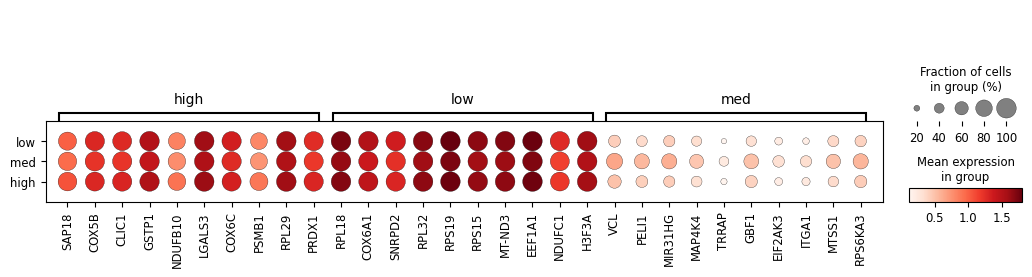

In [545]:
sc.tl.rank_genes_groups(adata_epi_tumor_CRC2817, groupby='MSI_lvl', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_epi_tumor_CRC2817, groupby='MSI_lvl', n_genes=10, categories_order=['low', 'med', 'high'], dendrogram=False)

#### CRC2783

In [530]:
adata_epi_tumor_CRC2783 = adata_epi_tumor[adata_epi_tumor.obs['PatientID']=='CRC2783'].copy()
adata_epi_tumor_CRC2783 = adata_epi_tumor_CRC2783.raw.to_adata()

sc.pp.normalize_total(adata_epi_tumor_CRC2783)
sc.pp.log1p(adata_epi_tumor_CRC2783)
sc.pp.highly_variable_genes(adata_epi_tumor_CRC2783, n_top_genes=2000, batch_key="SampleID")

adata_epi_tumor_CRC2783.raw = adata_epi_tumor_CRC2783.copy()
adata_epi_tumor_CRC2783 = adata_epi_tumor_CRC2783[:, adata_epi_tumor_CRC2783.var.highly_variable]

sc.pp.scale(adata_epi_tumor_CRC2783, max_value=10)
sc.tl.pca(adata_epi_tumor_CRC2783, svd_solver="arpack")

sc.pp.neighbors(adata_epi_tumor_CRC2783, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_tumor_CRC2783, random_state=42)

sc.tl.leiden(adata_epi_tumor_CRC2783, resolution=0.2, key_added='sub1_leiden')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


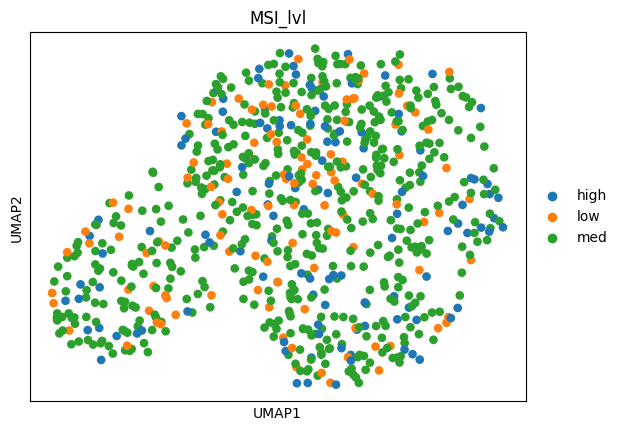

<Axes: xlabel='Scaled_AvgSTRDiff', ylabel='Density'>

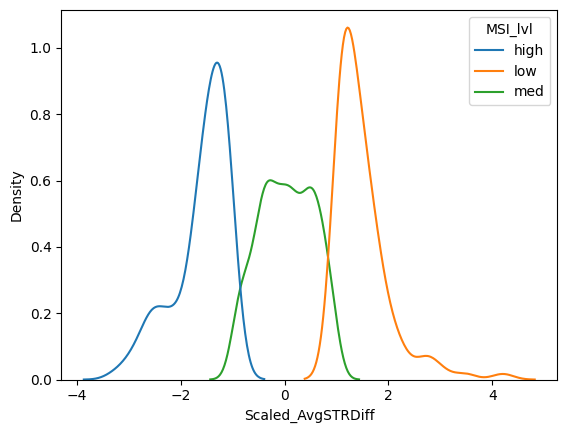

In [533]:
u, s = np.mean(adata_epi_tumor_CRC2783.obs['AvgSTRDiff']), np.std(adata_epi_tumor_CRC2783.obs['AvgSTRDiff'])
adata_epi_tumor_CRC2783.obs['Scaled_AvgSTRDiff'] = [ (AvgSTRDiff-u)/s for AvgSTRDiff in adata_epi_tumor_CRC2783.obs['AvgSTRDiff'] ]

col_MSI_lvl = list()
z_score_threshold = 1
for tup in adata_epi_tumor_CRC2783.obs.itertuples():
    if tup.Scaled_AvgSTRDiff >= z_score_threshold:
        col_MSI_lvl.append('low') # MSI-L
    elif tup.Scaled_AvgSTRDiff <= -z_score_threshold:
        col_MSI_lvl.append('high') # MSI-H
    else:
        col_MSI_lvl.append('med')
        
adata_epi_tumor_CRC2783.obs['MSI_lvl'] = col_MSI_lvl
sc.pl.umap(adata_epi_tumor_CRC2783, color=['MSI_lvl'])
sns.kdeplot(data=adata_epi_tumor_CRC2783.obs, x='Scaled_AvgSTRDiff', hue='MSI_lvl', common_norm=False,)

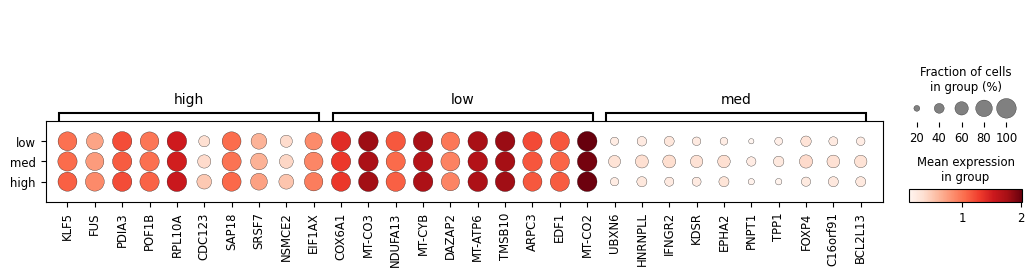

In [546]:
sc.tl.rank_genes_groups(adata_epi_tumor_CRC2783, groupby='MSI_lvl', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_epi_tumor_CRC2783, groupby='MSI_lvl', n_genes=10, categories_order=['low', 'med', 'high'], dendrogram=False)

#### SC035

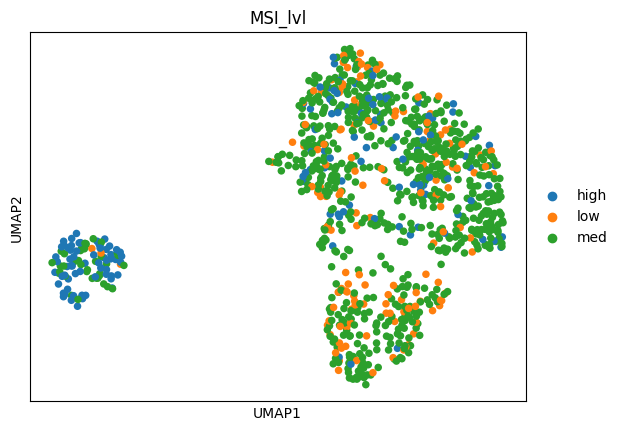

<Axes: xlabel='Scaled_AvgSTRDiff', ylabel='Density'>

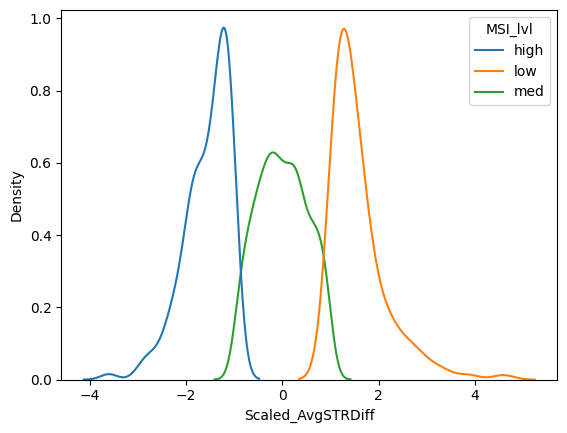

In [535]:
u, s = np.mean(adata_epi_tumor_SC035.obs['AvgSTRDiff']), np.std(adata_epi_tumor_SC035.obs['AvgSTRDiff'])
adata_epi_tumor_SC035.obs['Scaled_AvgSTRDiff'] = [ (AvgSTRDiff-u)/s for AvgSTRDiff in adata_epi_tumor_SC035.obs['AvgSTRDiff'] ]

col_MSI_lvl = list()
z_score_threshold = 1
for tup in adata_epi_tumor_SC035.obs.itertuples():
    if tup.Scaled_AvgSTRDiff >= z_score_threshold:
        col_MSI_lvl.append('low') # MSI-L
    elif tup.Scaled_AvgSTRDiff <= -z_score_threshold:
        col_MSI_lvl.append('high') # MSI-H
    else:
        col_MSI_lvl.append('med')
        
adata_epi_tumor_SC035.obs['MSI_lvl'] = col_MSI_lvl
sc.pl.umap(adata_epi_tumor_SC035, color=['MSI_lvl'])
sns.kdeplot(data=adata_epi_tumor_SC035.obs, x='Scaled_AvgSTRDiff', hue='MSI_lvl', common_norm=False,)

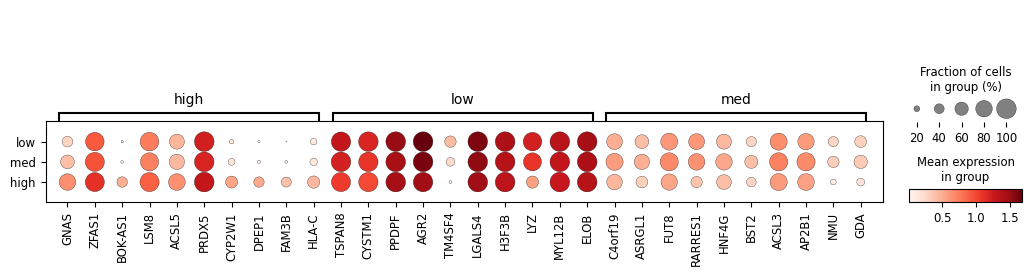

In [547]:
sc.tl.rank_genes_groups(adata_epi_tumor_SC035, groupby='MSI_lvl', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_epi_tumor_SC035, groupby='MSI_lvl', n_genes=10, categories_order=['low', 'med', 'high'], dendrogram=False)

#### SC044

In [538]:
adata_epi_tumor_SC044 = adata_epi_tumor[adata_epi_tumor.obs['PatientID']=='SC044'].copy()
adata_epi_tumor_SC044 = adata_epi_tumor_SC044.raw.to_adata()

sc.pp.normalize_total(adata_epi_tumor_SC044)
sc.pp.log1p(adata_epi_tumor_SC044)
sc.pp.highly_variable_genes(adata_epi_tumor_SC044, n_top_genes=2000, batch_key="SampleID")

adata_epi_tumor_SC044.raw = adata_epi_tumor_SC044.copy()
adata_epi_tumor_SC044 = adata_epi_tumor_SC044[:, adata_epi_tumor_SC044.var.highly_variable]

sc.pp.scale(adata_epi_tumor_SC044, max_value=10)
sc.tl.pca(adata_epi_tumor_SC044, svd_solver="arpack")

sc.pp.neighbors(adata_epi_tumor_SC044, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_tumor_SC044, random_state=42)

sc.tl.leiden(adata_epi_tumor_SC044, resolution=0.2, key_added='sub1_leiden')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


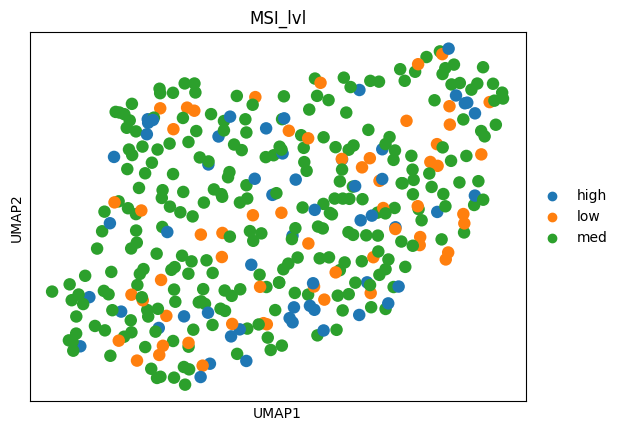

<Axes: xlabel='Scaled_AvgSTRDiff', ylabel='Density'>

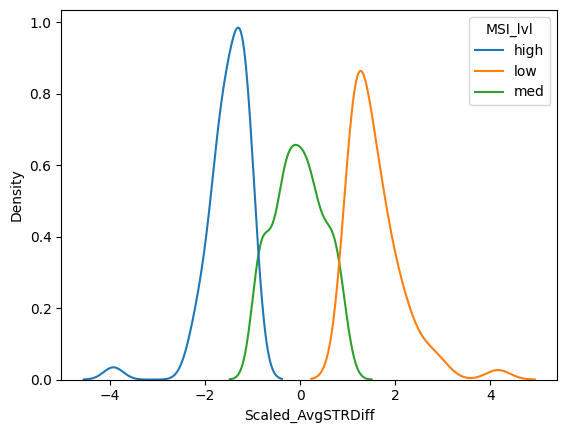

In [539]:

u, s = np.mean(adata_epi_tumor_SC044.obs['AvgSTRDiff']), np.std(adata_epi_tumor_SC044.obs['AvgSTRDiff'])
adata_epi_tumor_SC044.obs['Scaled_AvgSTRDiff'] = [ (AvgSTRDiff-u)/s for AvgSTRDiff in adata_epi_tumor_SC044.obs['AvgSTRDiff'] ]

col_MSI_lvl = list()
z_score_threshold = 1
for tup in adata_epi_tumor_SC044.obs.itertuples():
    if tup.Scaled_AvgSTRDiff >= z_score_threshold:
        col_MSI_lvl.append('low') # MSI-L
    elif tup.Scaled_AvgSTRDiff <= -z_score_threshold:
        col_MSI_lvl.append('high') # MSI-H
    else:
        col_MSI_lvl.append('med')
        
adata_epi_tumor_SC044.obs['MSI_lvl'] = col_MSI_lvl
sc.pl.umap(adata_epi_tumor_SC044, color=['MSI_lvl'])
sns.kdeplot(data=adata_epi_tumor_SC044.obs, x='Scaled_AvgSTRDiff', hue='MSI_lvl', common_norm=False,)

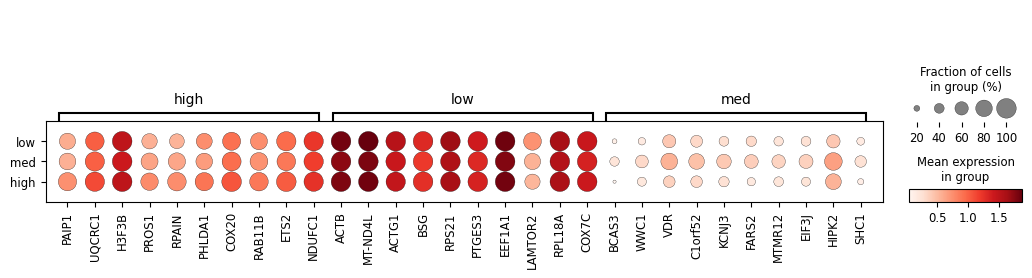

In [548]:
# sc.tl.rank_genes_groups(adata_epi_tumor_SC044, groupby='MSI_lvl', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_epi_tumor_SC044, groupby='MSI_lvl', n_genes=10, categories_order=['low', 'med', 'high'], dendrogram=False)

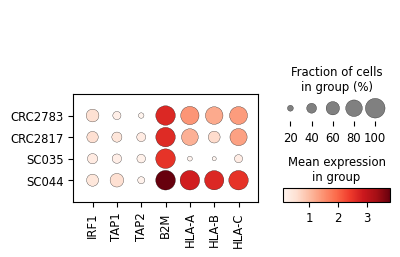

In [552]:
sc.pl.dotplot(adata_epi_tumor, groupby='PatientID', var_names=['IRF1', 'TAP1', 'TAP2', 'B2M', 'HLA-A', 'HLA-B', 'HLA-C'])

### Driver of MSI heterogeneity

In [409]:
adata_epi = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

adata_epi = adata_epi.raw.to_adata()
adata_epi = adata_epi[(adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])) & 
                      (adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial')]

sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.scale(adata_epi, max_value=10)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [408]:
STRProfileBulk = list()
for PatientID, edf in AlleleTable.groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        STRProfileBulk.append( [PatientID, isTumor, np.mean(edf2['diff'].dropna()), len(edf2.dropna()), ] )
STRProfileBulk = pd.DataFrame(STRProfileBulk, columns=['PatientID', 'isTumor', 'AvgSTRDiff', 'NumSTRLoci'])
STRProfileBulk = STRProfileBulk[(STRProfileBulk['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])) & (STRProfileBulk['isTumor']==True)]
STRProfileBulk

PatientID isTumor  AvgSTRDiff  NumSTRLoci
1    CRC2783    True   -1.625290       68074
13   CRC2817    True   -0.545201      104578
19     SC035    True   -1.565406      113881
28     SC044    True   -2.543139       34829

In [420]:
X_CRC2817 = adata_epi[adata_epi.obs['PatientID']=='CRC2817'].X.copy()
X_CRC2783 = adata_epi[adata_epi.obs['PatientID']=='CRC2783'].X.copy()
X_SC035 = adata_epi[adata_epi.obs['PatientID']=='SC035'].X.copy()
X_SC044 = adata_epi[adata_epi.obs['PatientID']=='SC044'].X.copy()

list_sig_gene = list()
for idx, tup in enumerate(adata_epi.var.itertuples()):
    
    CRC2817_exp = np.mean( [arr.ravel()[idx] for arr in X_CRC2817] )
    CRC2783_exp = np.mean( [arr.ravel()[idx] for arr in X_CRC2783] )
    SC035_exp = np.mean( [arr.ravel()[idx] for arr in X_SC035] )
    SC044_exp = np.mean( [arr.ravel()[idx] for arr in X_SC044] )
    
    pearsonr = stats.pearsonr( x=[-0.545201, -1.565406, -1.625290, -2.543139], y=[CRC2817_exp, SC035_exp, CRC2783_exp, SC044_exp] )
    list_sig_gene.append( [tup.Index, CRC2817_exp, SC035_exp, CRC2783_exp, SC044_exp, pearsonr[0], pearsonr[1]] )

sig_gene = pd.DataFrame(list_sig_gene, columns=['gene', 'CRC2817_exp', 'SC035_exp', 'CRC2783_exp', 'SC044_exp', 'r', 'pval'])

/tmp/ipykernel_209179/429792619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr = stats.pearsonr( x=[-0.545201, -1.565406, -1.625290, -2.543139], y=[CRC2817_exp, SC035_exp, CRC2783_exp, SC044_exp] )


In [612]:
sig_gene.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/MSI-gene_correlation.tsv', sep='\t', index=False)

In [618]:
sig_gene.sort_values('SC044_exp')

gene  CRC2817_exp  SC035_exp  CRC2783_exp  SC044_exp         r  \
19679  LGALS3     0.171351   0.381517     0.111727  -1.882815  0.772734   
20256   CRIP1     0.653297  -0.059544    -0.223677  -1.699180  0.965362   
25935  LGALS4     0.781227  -0.093806    -0.404354  -1.687248  0.984037   
1721   S100A6     0.979473  -0.449189    -0.344849  -1.544661  0.997082   
20085   IFI27     0.763045  -0.578263     0.177303  -1.501371  0.929817   
...       ...          ...        ...          ...        ...       ...   
21901   NUPR1    -0.439615  -0.298621     0.024568   2.329015 -0.855413   
4193     DPP4    -0.330647  -0.260376    -0.260600   2.426314 -0.809257   
17072   CCND2    -0.363077  -0.238485    -0.238757   2.436733 -0.820121   
23764   PRAC1    -0.303400  -0.303400    -0.293169   2.514231 -0.795827   
21552  PRSS21    -0.378700  -0.201930    -0.377911   2.680086 -0.808945   

           pval  
19679  0.227266  
20256  0.034638  
25935  0.015963  
1721   0.002918  
20085  0.070183  
...         ...  
21901  0.144587  
4193   0.190743  
17072  0.179879  
23764  0.204173  
21552  0.191055  

[29511 rows x 7 columns]

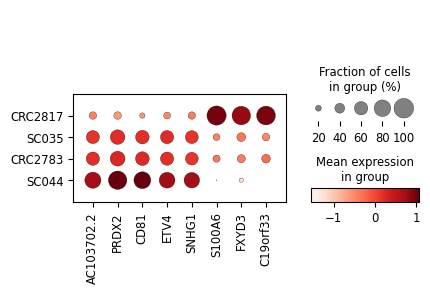

In [640]:
genelist_pos_cor = [ tup.gene for tup in sig_gene[sig_gene['pval']<=0.01].sort_values('r').itertuples() if max(list(tup)[2:6])>=0.7 ][:5]
genelist_neg_cor = [ tup.gene for tup in sig_gene[sig_gene['pval']<=0.01].sort_values('r', ascending=False).itertuples() if max(list(tup)[2:6])>=0.7 ][:3]

sc.pl.dotplot(adata_epi, var_names=genelist_pos_cor+genelist_neg_cor, groupby='PatientID', categories_order=['CRC2817', 'SC035', 'CRC2783', 'SC044', ],)

In [655]:
sc.tl.score_genes_cell_cycle(adata_chen, s_genes=cellcycle_marker[cellcycle_marker['phase']=='S']['gene_symbol'], g2m_genes=cellcycle_marker[cellcycle_marker['phase']=='G2/M']['gene_symbol'])

In [665]:
adata_chen.obs.columns

Index(['doublet_score', 'predicted_doublet', 'SampleID', 'PatientID',
       'BiopsySite', 'Accession', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2',
       'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response',
       'Manual_CellType_lvl_1', 'score', 'goblet', 'Enterocytes', 'Stem',
       'S_score', 'G2M_score', 'phase'],
      dtype='object')

In [ ]:
# /node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv

In [662]:
sc.tl.score_genes(adata_chen, ['MUC2', 'CLCA1', 'FCBP'], score_name='goblet')
sc.tl.score_genes(adata_chen, ['SLC26A3', 'DMBT1'], score_name='Enterocytes')
sc.tl.score_genes(adata_chen, ['OLFM4', 'LGR5', 'ASCL2', 'SOX9'], score_name='Stem')

In [753]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
dict_PatientID_to_TumorLoc   = { list(tup)[1] : list(tup)[5] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorLoc['P15'] = 'Sigmoid colon'
dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_CancerType = { list(tup)[1] : list(tup)[4] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_chen.obs['TumorLocation'] = [ dict_PatientID_to_TumorLoc[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['CancerType'] = [ dict_PatientID_to_CancerType[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_chen.obs['PatientID'] ]

In [120]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
chen_patient_metadata

Patient ID  Age  Gender         Cancer Type    Tumor Location       TNM  \
0         P01   51    Male                 CRC  Descending colon   T4bN0M0   
1         P02   56    Male                 CRC   Ascending colon   T4bN2M1   
2         P03   66    Male                 CRC        Low rectum  T3bN2aM0   
3         P04   47  Female                 CRC   Ascending colon   T4aN+M0   
4         P05   63  Female                 CRC        Low rectum    T3N+M0   
5         P08   52    Male                 CRC        Low rectum    T3N1M0   
6         P09   64    Male                 CRC        Low rectum    T3bN2b   
7         P11   65    Male  Duodenal carcinoma          Duodenum   T3N0M0    
8         P12   60    Male                 CRC  Descending colon  T4bN2bM0   
9         P14   58    Male                 CRC        Low rectum   T3N2bM0   
10        P15   60    Male                 CRC           Sigmoid    T3N+M0   
11        P16   64    Male                 CRC        Low rectum    T3N+M0   
12        P17   37    Male                 CRC     Sigmoid colon   T4bN+M0   
13        P18   33  Female                 CRC     Sigmoid colon  T4bN2bM0   
14        P19   58    Male                 CRC  Transverse colon    T3N0M0   
15        P20   48    Male                 CRC   Ascending colon   T4bN+M0   
16        P21   44    Male                 CRC   Ascending colon  T4bN2aM0   
17        P22   57    Male                 CRC  Transverse colon  T4bN2bM0   
18        P23   37    Male                 CRC  Transverse colon  T4bN2bM1   
19        P24   39    Male  Duodenal carcinoma          Duodenum   T4aN0M0   
20        P25   70    Male                 CRC   Ascending colon  T4bN2bM1   
21        P26   34    Male                 CRC   Ascending colon   T3N2aM0   

   Tumor stage dMMR/pMMR MSI/MSS POLE Mutation  TMB (Muts/Mb)  \
0           II      dMMR     MSS           Yes  Not avaliable   
1           IV      pMMR     MSS            No           3.58   
2          III      pMMR     MSS            No  Not avaliable   
3          III      dMMR     MSI            No            487   
4          III      pMMR     MSS            No           3.05   
5          III      dMMR     MSI            No         121.64   
6          III      pMMR     MSS            No           4.75   
7           II      dMMR     MSI            No          1.78    
8          III      dMMR     MSI            No        114.72    
9          III      pMMR     MSS            No  Not avaliable   
10         III      dMMR     MSI            No  Not avaliable   
11         III      pMMR     MSI            No         13.66    
12         III      dMMR     MSI            No           67.7   
13         III      dMMR     MSI            No          20.98   
14          II      dMMR     MSI            No          54.54   
15         III      dMMR     MSI            No  Not avaliable   
16         III      dMMR     MSI            No          20.98   
17         III      dMMR     MSI            No  Not avaliable   
18          IV      dMMR     MSI            No         181.17   
19         III      dMMR     MSI            No          24.45   
20          IV      dMMR     MSI            No          72.09   
21         III      dMMR     MSI            No          75.85   

    Tumor Regression Ratio Response TRG status       Treatment Regimen  
0                   0.5648       CR       TRG0           Pembrolizumab  
1                  -0.0196       SD       TRG3           Pembrolizumab  
2                   0.4541       PR       TRG2  Pembrolizumab + CapeOx  
3                   0.9180       CR       TRG0           Pembrolizumab  
4                   0.3333       PR       TRG2      Sintilimab+ CapeOx  
5                   0.8813       CR       TRG0           Pembrolizumab  
6                   0.9156       CR       TRG0      Sintilimab+ CapeOx  
7                   1.0000       CR       TRG0           Pembrolizumab  
8                   0.0090       CR       TRG0         

In [785]:
sc.tl.score_genes(adata_chen, gene_list=['DNMT3A'])

In [786]:
MSI_degree = list()
for PatientID, edf in adata_chen.obs.groupby("PatientID"):
    MSI_degree.append( [PatientID, np.mean(edf['AvgSTRDiff'].dropna()), 
                        np.mean(edf['Stem']), np.mean(edf['score']), np.mean(edf['S_score']), len(edf),
                        edf.iloc[0].Age, edf.iloc[0].CancerType, edf.iloc[0].TumorLocation, edf.iloc[0].TumorStage, edf.iloc[0].TumorRegressionRatio, edf.iloc[0].Response
                        ] )
MSI_degree = pd.DataFrame(MSI_degree, columns=['PatientID', 'AvgSTRDiff', 'StemScore', 'GeneScore', 'Sscore', 'CellCount', 
                                               'Age', 'CancerType', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'Response'])
MSI_degree.sort_values('AvgSTRDiff', inplace=True)

/tmp/ipykernel_209179/443431625.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_chen.obs.groupby("PatientID"):


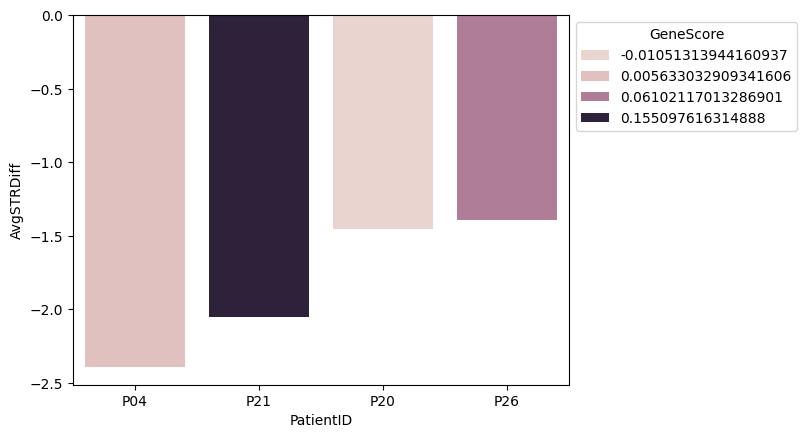

In [790]:
ax = sns.barplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & 
                                 (MSI_degree['TumorLocation']=='Ascending colon')], x='PatientID', y='AvgSTRDiff', 
                 hue='GeneScore', 
                 # palette=sns.diverging_palette(220, 20, as_cmap=True),
                 )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

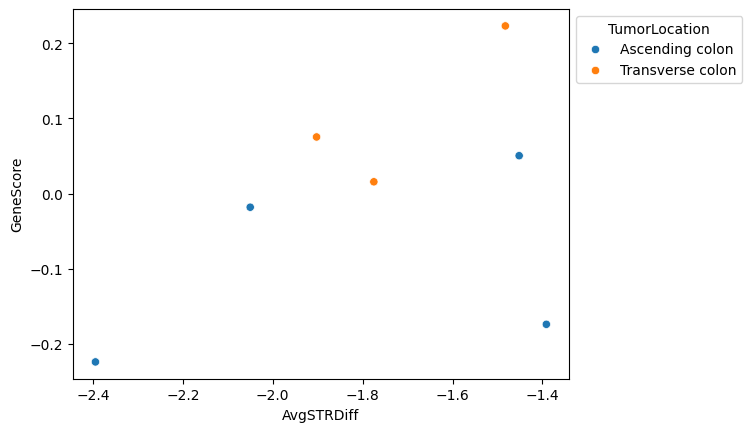

In [784]:
ax = sns.scatterplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & 
                                 (MSI_degree['TumorLocation']!='Sigmoid colon')], x='AvgSTRDiff', y='GeneScore', hue='TumorLocation')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

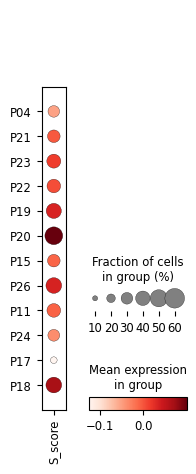

In [667]:
sc.pl.dotplot(adata_chen, var_names=['S_score', 'G2M_score'], groupby='PatientID', 
              categories_order=['P04', 'P21', 'P23', 'P22', 'P19', 'P20', 'P15', 'P26', 'P11', 'P24', 'P17', 'P18'],
              )

In [470]:
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_chen = adata_chen[adata_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial']

adata_chen = adata_chen.raw.to_adata()
adata_chen = adata_chen[(adata_chen.obs['MSI']=='MSI') & ~(adata_chen.obs['PatientID'].isin(['P08', 'P12']))] 

sc.pp.normalize_total(adata_chen)
sc.pp.log1p(adata_chen)
sc.pp.scale(adata_chen, max_value=10)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [557]:
dict_PatientID_to_AvgSTRDiff = dict()
for PatientID, edf in adata_chen.obs[(adata_chen.obs['NumSTRLoci']!=0)].groupby('PatientID'):
    dict_PatientID_to_AvgSTRDiff[PatientID] = np.mean(edf['AvgSTRDiff'])
dict_PatientID_to_AvgSTRDiff = dict(sorted(dict_PatientID_to_AvgSTRDiff.items(), key=lambda x:x[1]))
dict_PatientID_to_AvgSTRDiff

/tmp/ipykernel_209179/2765650158.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_chen.obs[(adata_chen.obs['NumSTRLoci']!=0)].groupby('PatientID'):


{'P04': -2.400360625105161,
 'P21': -2.0550661582522483,
 'P23': -1.9036044752133918,
 'P22': -1.819170687677332,
 'P19': -1.4978381501021447,
 'P20': -1.4562576993355703,
 'P15': -1.4167480147951217,
 'P26': -1.3940898449843884,
 'P11': -1.3013453458299546,
 'P24': -1.1220420625798324,
 'P17': -1.0553414293321977,
 'P18': -0.6639958362623589}

In [558]:
X_P04 = adata_chen[adata_chen.obs['PatientID']=='P04'].X.copy()
X_P21 = adata_chen[adata_chen.obs['PatientID']=='P21'].X.copy()
X_P23 = adata_chen[adata_chen.obs['PatientID']=='P23'].X.copy()
X_P22 = adata_chen[adata_chen.obs['PatientID']=='P22'].X.copy()
X_P19 = adata_chen[adata_chen.obs['PatientID']=='P19'].X.copy()
X_P20 = adata_chen[adata_chen.obs['PatientID']=='P20'].X.copy()
X_P15 = adata_chen[adata_chen.obs['PatientID']=='P15'].X.copy()
X_P26 = adata_chen[adata_chen.obs['PatientID']=='P26'].X.copy()
X_P11 = adata_chen[adata_chen.obs['PatientID']=='P11'].X.copy()
X_P24 = adata_chen[adata_chen.obs['PatientID']=='P24'].X.copy()
X_P17 = adata_chen[adata_chen.obs['PatientID']=='P17'].X.copy()
X_P18 = adata_chen[adata_chen.obs['PatientID']=='P18'].X.copy()

list_sig_gene = list()
for idx, tup in enumerate(adata_chen.var.itertuples()):
    
    P04_exp = np.mean( [arr.ravel()[idx] for arr in X_P04] )
    P21_exp = np.mean( [arr.ravel()[idx] for arr in X_P21] )
    P23_exp = np.mean( [arr.ravel()[idx] for arr in X_P23] )
    P22_exp = np.mean( [arr.ravel()[idx] for arr in X_P22] )
    P19_exp = np.mean( [arr.ravel()[idx] for arr in X_P19] )
    P20_exp = np.mean( [arr.ravel()[idx] for arr in X_P20] )
    P15_exp = np.mean( [arr.ravel()[idx] for arr in X_P15] )
    P26_exp = np.mean( [arr.ravel()[idx] for arr in X_P26] )
    P11_exp = np.mean( [arr.ravel()[idx] for arr in X_P11] )
    P24_exp = np.mean( [arr.ravel()[idx] for arr in X_P24] )
    P17_exp = np.mean( [arr.ravel()[idx] for arr in X_P17] )
    P18_exp = np.mean( [arr.ravel()[idx] for arr in X_P18] )

    
    pearsonr = stats.pearsonr( x=[-0.6639958362623589, -1.0548491991879196, -1.0959204484245346, -1.2873308574902476,
                                  -1.3912988743237589, -1.4012078171922502, -1.4518178892766203, -1.4825265153747023, 
                                  -1.7750695800972756, -1.902498371509026, -2.0501022303337644, -2.3943994646123503], 
                              y=[P18_exp, P17_exp, P24_exp, P11_exp, P26_exp, P15_exp, P20_exp, P19_exp, P22_exp, P23_exp, P21_exp, P04_exp, ] )
    list_sig_gene.append( [tup.Index, P18_exp, P17_exp, P24_exp, P11_exp, P26_exp, P15_exp, P20_exp, P19_exp, P22_exp, P23_exp, P21_exp, P04_exp, pearsonr[0], pearsonr[1]] )
    
sig_gene_chen = pd.DataFrame(list_sig_gene, columns=['gene', 
                                                     'P04_exp', 'P21_exp', 'P23_exp', 'P22_exp', 'P19_exp', 'P20_exp', 'P15_exp', 'P26_exp', 'P11_exp', 'P24_exp', 'P17_exp', 'P18_exp', 
                                                     'r', 'pval'])

/tmp/ipykernel_209179/3495753154.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr = stats.pearsonr( x=[-0.6639958362623589, -1.0548491991879196, -1.0959204484245346, -1.2873308574902476,


In [ ]:
sig_gene_chen.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/MSI-gene_correlation.tsv', sep='\t', index=False)

In [581]:
sig_gene_chen[sig_gene_chen['pval']<=0.05].sort_values('r')[['gene', 'r', 'pval']]

gene         r      pval
29071    CDK16 -0.941950  0.000005
29035    DDX3X -0.920652  0.000022
26732   ZNF808 -0.899089  0.000069
28851  AKAP17A -0.892307  0.000095
21209    CD276 -0.887529  0.000117
...        ...       ...       ...
27533  B4GALT5  0.817044  0.001177
6955   DCUN1D4  0.830270  0.000828
22067    USP31  0.835598  0.000713
16492    CLCF1  0.855323  0.000390
2339     ARL8A  0.927159  0.000014

[2063 rows x 3 columns]

In [602]:
for gene in sig_gene_chen[sig_gene_chen['pval']<=0.05].sort_values('r').head(50)['gene']:
    joanito_r = sig_gene[sig_gene['gene']==gene].iloc[0]['r']
    joanito_p = sig_gene[sig_gene['gene']==gene].iloc[0]['pval']
    if joanito_p <= 0.2:
        print(gene, round(joanito_r, 2))

ZNF808 -0.99
RUVBL1-AS1 -0.86
MBD1 -0.99
ZNF577 -0.85
CATSPERB 0.81
AL049830.3 -0.87
FN3K -0.85
COL14A1 -0.99
AEBP2 0.85
RGMB -0.98
MAP1LC3A -0.92
USP22 -0.89
BBOX1-AS1 -0.94
FGF5 0.84
ZFC3H1 0.99


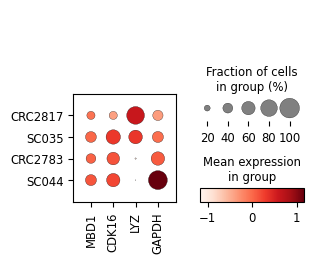

In [610]:
sc.pl.dotplot(adata_epi, var_names=['MBD1', 'CDK16', 'LYZ', 'GAPDH'], groupby='PatientID', categories_order=['CRC2817', 'SC035', 'CRC2783', 'SC044', ],)

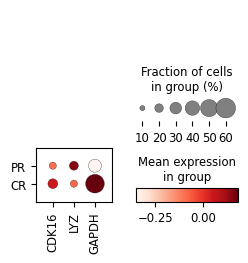

In [608]:
sc.pl.dotplot(adata_chen, var_names=['CDK16', 'LYZ', 'GAPDH'], groupby='Response', 
              categories_order=['PR', 'CR'],)

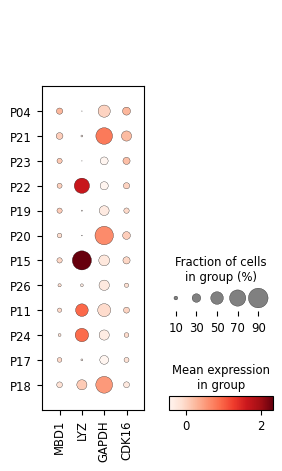

In [611]:
sc.pl.dotplot(adata_chen, var_names=['MBD1', 'LYZ', 'GAPDH', 'CDK16'], groupby='PatientID', 
              categories_order=['P04', 'P21', 'P23', 'P22', 'P19', 'P20', 'P15', 'P26', 'P11', 'P24', 'P17', 'P18'],)

In [1197]:
df = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/DEG_by_MSIclass.tsv', sep='\t')

import scipy.stats

candidateDriverGenes = list()
for gene, edf in df.groupby('gene'):
    if min(edf['pvals_adj'])>0.05: continue 
    
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    if (dict_MSI_class_to_avgExpression['Low'] < dict_MSI_class_to_avgExpression['Mid'] < dict_MSI_class_to_avgExpression['High']) or (dict_MSI_class_to_avgExpression['Low'] > dict_MSI_class_to_avgExpression['Mid'] > dict_MSI_class_to_avgExpression['High']):
        dict_MSI_class_to_lfc = { tup.MSI_class : tup.lfc for tup in edf.itertuples() }
        if (dict_MSI_class_to_lfc['Low'] < dict_MSI_class_to_lfc['Mid'] < dict_MSI_class_to_lfc['High']) or (dict_MSI_class_to_lfc['Low'] > dict_MSI_class_to_lfc['Mid'] > dict_MSI_class_to_lfc['High']):
            candidateDriverGenes.append( gene )
        else:
            pass 
    else:
        pass
df = df[(df['gene'].isin(candidateDriverGenes))].copy()
DEG_Summary = list()
for gene, edf in df.groupby('gene'):
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    r, pval = scipy.stats.pearsonr( [1,2,3], [dict_MSI_class_to_avgExpression['Low'], dict_MSI_class_to_avgExpression['Mid'], dict_MSI_class_to_avgExpression['High']] )
    DEG_Summary.append( [gene, r, pval] )

DEG_Summary = pd.DataFrame(DEG_Summary, columns=['gene', 'r', 'pval'])
# DEG_Summary = DEG_Summary[(DEG_Summary['pval']<=0.05) & (DEG_Summary['r']>=0.7)]


In [1198]:
df = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/DEG_by_MSIclass.tsv', sep='\t')

import scipy.stats

candidateDriverGenes = list()
for gene, edf in df.groupby('gene'):
    if min(edf['pvals_adj'])>0.05: continue 
    
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    if (dict_MSI_class_to_avgExpression['Low'] < dict_MSI_class_to_avgExpression['Mid'] < dict_MSI_class_to_avgExpression['High']) or (dict_MSI_class_to_avgExpression['Low'] > dict_MSI_class_to_avgExpression['Mid'] > dict_MSI_class_to_avgExpression['High']):
        dict_MSI_class_to_lfc = { tup.MSI_class : tup.lfc for tup in edf.itertuples() }
        if (dict_MSI_class_to_lfc['Low'] < dict_MSI_class_to_lfc['Mid'] < dict_MSI_class_to_lfc['High']) or (dict_MSI_class_to_lfc['Low'] > dict_MSI_class_to_lfc['Mid'] > dict_MSI_class_to_lfc['High']):
            candidateDriverGenes.append( gene )
        else:
            pass 
    else:
        pass
df = df[(df['gene'].isin(candidateDriverGenes))].copy()
DEG_Summary2 = list()
for gene, edf in df.groupby('gene'):
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    r, pval = scipy.stats.pearsonr( [1,2,3], [dict_MSI_class_to_avgExpression['Low'], dict_MSI_class_to_avgExpression['Mid'], dict_MSI_class_to_avgExpression['High']] )
    DEG_Summary2.append( [gene, r, pval] )

DEG_Summary2 = pd.DataFrame(DEG_Summary2, columns=['gene', 'r', 'pval'])
# DEG_Summary2 = DEG_Summary2[(DEG_Summary2['pval']<=0.05) & (DEG_Summary2['r']>=0.7)]

In [1199]:
a = set(DEG_Summary[(DEG_Summary['r']<=-0.7)]['gene'])
b = set(DEG_Summary2[(DEG_Summary2['r']<=-0.7)]['gene'])
c = a.intersection(b)
len(a), len(b), len(c)

(1223, 1973, 229)

In [1206]:
a = set(DEG_Summary[(DEG_Summary['r']>=0.7)]['gene'])
b = set(DEG_Summary2[(DEG_Summary2['r']>=0.7)]['gene'])
c = a.intersection(b)
len(a), len(b), len(c)

(3245, 1564, 394)

In [1207]:
for gene in DEG_Summary[DEG_Summary['gene'].isin(c)]['gene']:
    print(gene)

AC005062.1
AC006206.2
AC007952.4
AC025164.1
AC027288.3
ACAA1
ACAP3
ACLY
ACOT2
ADGRL1
AF064858.1
AGO2
AKT1S1
ALAS1
ALDH2
ALG12
ALKBH5
AMD1
ANK3
AP2A2
AP3M1
AP5Z1
APOLD1
APP
ARHGAP39
ARHGEF40
ARID1A
ARID5A
ASCL2
ATAD3A
ATAD3B
ATF2
ATF6B
ATG4D
ATP1A1
ATP6V1C2
ATRX
ATXN7L3B
BAG4
BAZ1B
BCKDHA
BCL2L12
BDH1
BID
BMP7
BOP1
BRAT1
BRD2
BRD3
BUD23
C12orf65
C19orf48
C4orf19
C5orf38
C7orf50
C8orf33
CABIN1
CASZ1
CCN2
CCND2
CD276
CD302
CDC42SE2
CDK14
CDK6
CDKN1B
CDKN2AIP
CEBPB
CEBPD
CELF2
CES3
CHD8
CHN1
CHRAC1
CHRNB1
CHTF18
CITED2
CLK3
CLK4
CLUAP1
CNKSR3
CNOT8
CNP
CPSF1
CPSF7
CREBZF
CRYBG1
CSKMT
CSNK1D
CSRNP2
CTBP2
CTTNBP2
CYB5R3
CYC1
CYHR1
CYP4X1
DACH1
DANCR
DBN1
DCAF12
DDB1
DDIT3
DIP2C
DIPK2A
DLD
DNAJB11
DNAJC2
DNAJC3-DT
DNMT3A
DPP7
DTNB
DUSP2
ECD
EIF4A3
EIF4G2
EMC2
ENTPD6
EPB41
EPB41L2
EPN1
EXOSC4
F11-AS1
FAM171A1
FAM53C
FAM83D
FLOT2
FN3K
FREM1
FTSJ1
G6PD
GADD45B
GALNS
GBE1
GGA2
GGT6
GMPR
GNGT1
GRB2
GRHL2
GRIP1
GRPEL1
GRTP1
GTF2B
H2AFX
HACL1
HBP1
HDAC1
HDAC3
HDAC7
HEIH
HGS
HILPDA
HIST1H1E
HIST1H2AG

/tmp/ipykernel_209179/1111436741.py:3: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
  adata_epi.layers["scaled"] = sc.pp.scale(adata_epi, copy=True).X
/tmp/ipykernel_209179/1111436741.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_epi.obs.groupby("SampleID"):


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


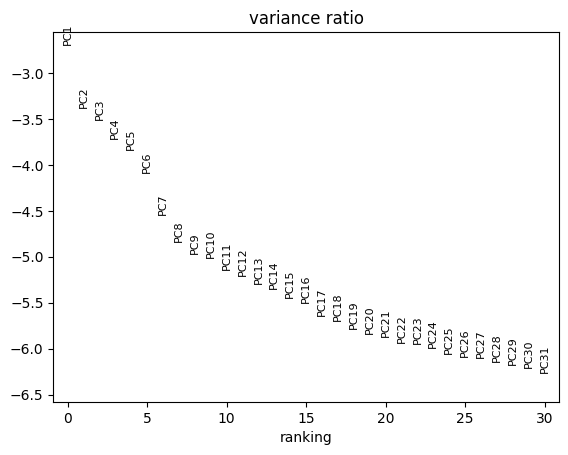

In [341]:
adata_epi = adata_epi.raw.to_adata()
adata_epi = adata_epi[(adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])) & 
                      (adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial')]
adata_epi.layers["scaled"] = sc.pp.scale(adata_epi, copy=True).X

onlySingleCellSample = list()
for SampleID, edf in adata_epi.obs.groupby("SampleID"):
    if len(edf) <= 1:
        print(SampleID)
        onlySingleCellSample.append(SampleID)
adata_epi = adata_epi[~(adata_epi.obs['SampleID'].isin(onlySingleCellSample))].copy()

sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
sc.pp.scale(adata_epi, max_value=10)

adata_epi.raw = adata_epi.copy()
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [342]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

In [343]:
for PatientID, edf in adata_epi[adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])].obs.groupby('PatientID'):
    print(PatientID,)

CRC2783
CRC2817
SC035
SC044


/tmp/ipykernel_209179/3236238909.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi[adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])].obs.groupby('PatientID'):


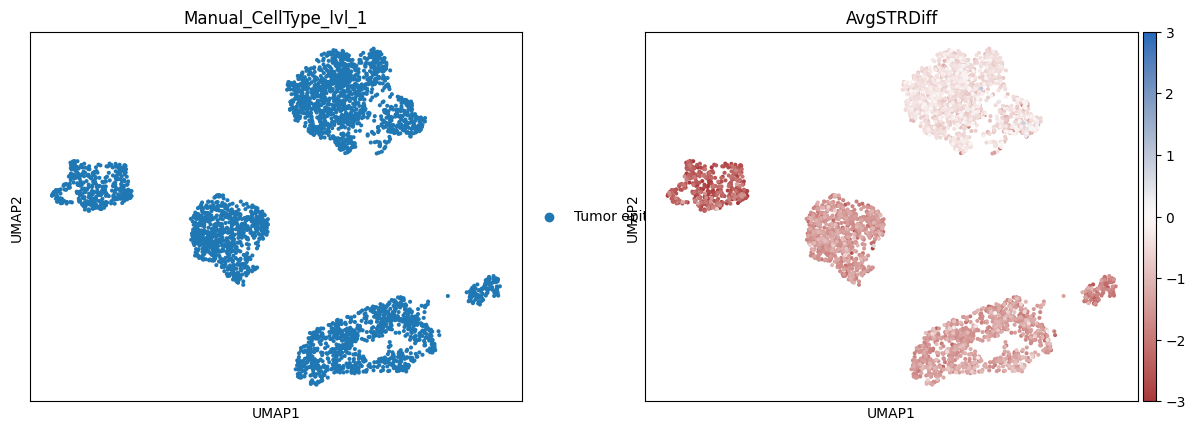

In [345]:
sc.pl.umap(adata_epi, color=['Manual_CellType_lvl_1', 'AvgSTRDiff'], cmap='vlag_r', vmin=-3, vmax=3)

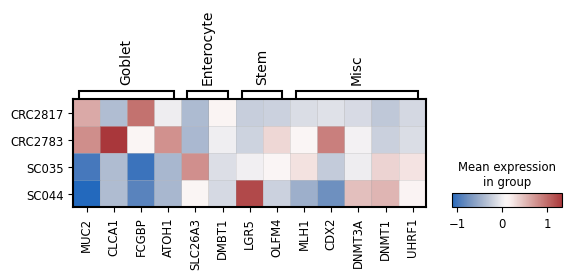

In [381]:
sc.pl.matrixplot(adata_epi, var_names={ 'Goblet' : ['MUC2', 'CLCA1', 'FCGBP', 'ATOH1'], 
                                    'Enterocyte' : ['SLC26A3', 'DMBT1', ], 
                                    'Stem' : ['LGR5', 'OLFM4', ], 
                                    'Misc' : ['MLH1', 'CDX2', 'DNMT3A', 'DNMT1', 'UHRF1', ] }, 
              groupby='PatientID', cmap='vlag',
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              )

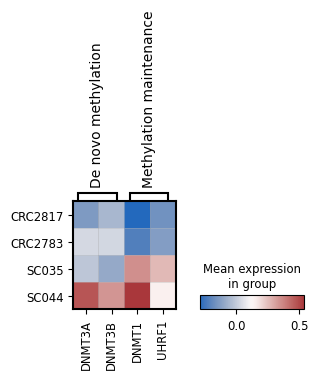

In [394]:
sc.pl.matrixplot(adata_epi, var_names={ 'De novo methylation' : ['DNMT3A', 'DNMT3B', ], 'Methylation maintenance' : ['DNMT1', 'UHRF1',], }, 
              groupby='PatientID', cmap='vlag',
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              )

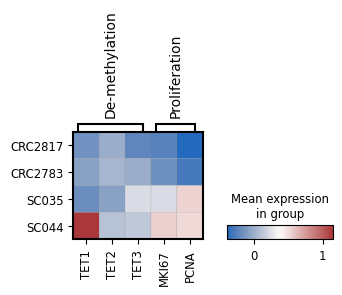

In [399]:
sc.pl.matrixplot(adata_epi, var_names={ 'De-methylation' : ['TET1', 'TET2', 'TET3', ], 'Proliferation' : ['MKI67', 'PCNA'] }, 
              groupby='PatientID', cmap='vlag',
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              )